#### Preparation
This notebook is only configured to use Weights & Biases for tracking metrics. Enabling this requires an account and api key, which can be set below. Unfortunately, the code below is not configured in such a way that it can easily be omitted. Feel free to remove this integration, though.  

Weights & Biases can be installed using: `pip install wandb`.  

This notebook requires the execution of:
- `Data Exporation and Preprocessing` 

In [1]:
import os
# Optional: set your W&B api key below. Looks like: 7ol65g3j2rulhg3af4o7m8wma8d9isyu3myqkdb8 (example)
os.environ['WANDB_API_KEY'] = ''
os.environ['WANDB_PROJECT'] = 'particle_process_discriminator'

if os.environ['WANDB_API_KEY'] is not '':
    # login to W&B account
    res = os.system('wandb login {}'.format(os.environ['WANDB_API_KEY']))
    print("Logged in to Weights & Biases")

#### Initialize

In [2]:
# For Google Colab:
%tensorflow_version 2.x

# (basic) dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gc
from tqdm import tqdm as tqdm

# sklearn dependencies
from sklearn.metrics import (auc, log_loss, confusion_matrix, accuracy_score,
                             recall_score, precision_score)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from scipy.stats.mstats import gmean

# tensorflow dependencies
from tensorflow.keras import datasets, layers, models, regularizers, backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

import wandb
from wandb.keras import WandbCallback
MODEL_DIR = 'models/'

In [3]:
# own dependencies
from helper import metrics, learn, select_features, load_data, cross_validation, ROC
from helper import make, save, make_args, build_architecture, train_net, train_args

In [4]:
# further settings
FIG_DIR = 'figures/'
plt.rcParams["figure.figsize"] = (10, 4.5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 14})
plt.rcParams["savefig.bbox"] = 'tight'

random_state = 576

In [5]:
def aug_wrapper(generator, flip_eta=False, skip_first_channel_flip=False, jointly_flip_phi=False, verbose=False):
    """Accept batches from an ImageDataGenerator, and apply cyclical shift augmentation.
    If flip_eta is True, 50% of the batches will be horizontally flipped, whih coincides
    with mirroring the pseudorapidity angle (eta) in the axis theta = pi/2.
    Note: if the first channel contains the missing transverse energy (MET),
    `skip_first_channel_flip` should be true, as the MET is set as x=0 because
    there is no pseudorapidity for the MET.
    """

    if flip_eta and not skip_first_channel_flip:
        print("Warning: flipping all channels, check if this is intentional (for MET)")

    for batch_x, batch_y in generator:
        # apply cyclical shift in y-direction
        batch_x_new = np.zeros_like(batch_x)

        # 1. determine number of pixels to shift
        h = batch_x.shape[1]
        shift_y = np.random.randint(h)

        # 2. insert orignal pixels [0:h-shift] into [shift:]
        batch_x_new[:, shift_y:, :, :] = batch_x[:, 0:h - shift_y, :, :]

        # 3. insert the other pixels at the top
        batch_x_new[:, 0:shift_y, :, :] = batch_x[:, h - shift_y:, :, :]

        # 4. flip psuedorapidity angle, if enabled, with a probability of 50%
        if flip_eta and np.random.choice([True, False]):
            if verbose:
                print("Flipping eta. Showing first 3 channels.")
                f, axes = plt.subplots(1, 2, figsize=(12, 5))
                ax = axes[0];
                ax.imshow(batch_x_new[0, :, :, :3]);
                ax.set_title("Original")

            if skip_first_channel_flip:
                if jointly_flip_phi:
                    batch_x_new[:, :, :, 1:] = batch_x_new[:, :, ::-1, 1:]  # flip pseudorapidity for objects
                    batch_x_new[:, :, :, :] = batch_x_new[:, ::-1, :, :]  # flip azimuth of objects & MET
                else:
                    batch_x_new[:, :, :, 1:] = batch_x_new[:, :, ::-1, 1:]
            else:
                if jointly_flip_phi:
                    batch_x_new[:, :, :, :] = batch_x_new[:, ::-1, ::-1, :]
                else:
                    batch_x_new[:, :, :, :] = batch_x_new[:, :, ::-1, :]

            if verbose:
                ax = axes[1];
                ax.imshow(batch_x_new[0, :, :, :3]);
                ax.set_title("Flipped")
                plt.show()

        yield batch_x_new, batch_y


def get_exp_lr_decay_scheduler(lr_start, lr_end, epochs_total, epochs_warmup):
    """LR test scheduler function. Decays exponentially from lr_start to lr_end.
    leaves the lr unchanged for the first epochs_warmup epochs.
    To be combined with tf.keras.callbacks.LearningRateScheduler"""

    def lr_exp_decay_scheduler(epoch, lr):
        if epoch < epochs_warmup:
            return lr_start

        # epoch >= epochs_warmup, so calculate exp. decay
        # want  lr_start * exp( -(epochs_total-epochs_warmup) * factor) ) = lr_end
        # so factor = -log(lr_end) / (epochs_total-epochs_warmup) / lr_start
        factor = -np.log(lr_end / lr_start) / (epochs_total - epochs_warmup)
        lr = lr_start * np.exp(-(epoch - epochs_warmup) * factor)
        return lr

    return lr_exp_decay_scheduler

In [ ]:
def plot_accuracy_gain(acc, labels, baseline, fn, figsize=(12, 5), label_rotation=0):
    f, axes = plt.subplots(1, 1, figsize=figsize)
    ax = axes

    # calculate means and std. between trails
    try:
        means, stds = np.mean(acc, axis=-1), np.std(acc, axis=-1)
    except:
        assert isinstance(acc, list), "Need ndarray or list"
        means, stds = [], []
        for acc_row in acc:
            means.append(np.mean(acc_row))
            stds.append(np.std(acc_row))
        means, stds = np.array(means), np.array(stds)

    # plot bar plot with height the mean and error bars the deviation
    # substract a baseline from all means
    y = means - means[baseline]
    ax.bar(range(len(labels)), height=y, yerr=stds)#, capsize=4)
    ax.axhline(0, color='k')
    ax.set_xticklabels(labels, rotation=label_rotation)
    ax.set_xticks(range(len(labels)))

    # write total accuracy above bars
    for i, (v, a) in enumerate(zip(y, means)):
        ax.text(i, v+np.max(stds[i]), f"{a:,.2%}", va='bottom', ha='center', fontweight='bold')

    # Set yticks to percentage
    vals = ax.get_yticks()
    # calculate the number of decimals to show without losing information
    num_decimals = max(0, int(np.ceil(np.mean(np.abs(np.log10(np.diff(vals)))) - 2)))
    labels = ['{x:,.{num}%}'.format(x=x, num=num_decimals) for x in vals]
    ax.set_yticklabels(labels)
    ax.set_ylabel("Validation accuracy gain")

    # Hide the right and top spines
    for loc in ['right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

    f.tight_layout()
    f.savefig('{}/{fn}'.format(FIG_DIR, fn=fn))
    plt.show()


def plot_history(history, limits=False):
    f, axes = plt.subplots(1, 1, figsize=(15, 8))
    ax = axes
    ax.plot(history.history['acc'], label='Train')

    # plot validation accuracy and maximal validation accuracy
    val_accs = history.history['val_acc']
    ax.plot(val_accs, label='Test')
    ax.plot(np.argmax(val_accs), np.max(val_accs), 'x', ms=15, color='r')
    ax.set_title("Accuracy (max. val. acc.: {:.2%})".format(np.max(val_accs)));
    ax.set_ylabel("Accuracy"); ax.set_xlabel("Epoch"); ax.legend();
    if limits:
        ax.set_ylim(bottom=0.833, top=1)
    plt.show()

# Particle Process Discriminator - Train Convolutional Neural Networks

This document will explore the convolutional neural network to work with the spatial data. 

In [6]:
# read train and validation data
data, features, target = load_data('data', trans='log', norm='minmax')
train, validation = train_test_split(data, test_size=0.2, random_state=random_state)

In [7]:
# read images from preprocessing notebook
images = np.load("data/images_1ch.npy")
train_images, val_images = train_test_split(images, test_size=0.2, random_state=random_state)

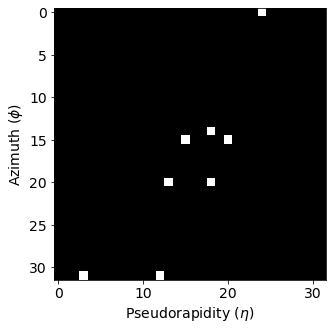

In [8]:
# preview an image
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(images[0].squeeze(), cmap='gray')
ax.set_xlabel('Pseudorapidity ($\eta$)')
ax.set_ylabel('Azimuth ($\phi$)')
plt.show()

# Part 1: Proof of concept
Test whether the network can extract information from the images at all.  

The code below does not use convolutional layers, but rather tries to extract information directly. If this approach is able to extract more than baseline accuracy (83.3%), the network is able to extract useful information. Also, test the capacity of the network by checking if the network can reach a training accuracy of 100%.

## Presence of information

In [0]:
args = make_args(name='Conv initial', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 epochs=30, verbose=False)

# define model architecture
model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_images, train[target].values, epochs=args.epochs,
                    validation_data=(val_images, validation[target].values),
                    callbacks=[WandbCallback()], verbose=0)

# save model online
model.save(os.path.join(wandb.run.dir, "model-trained.h5"))

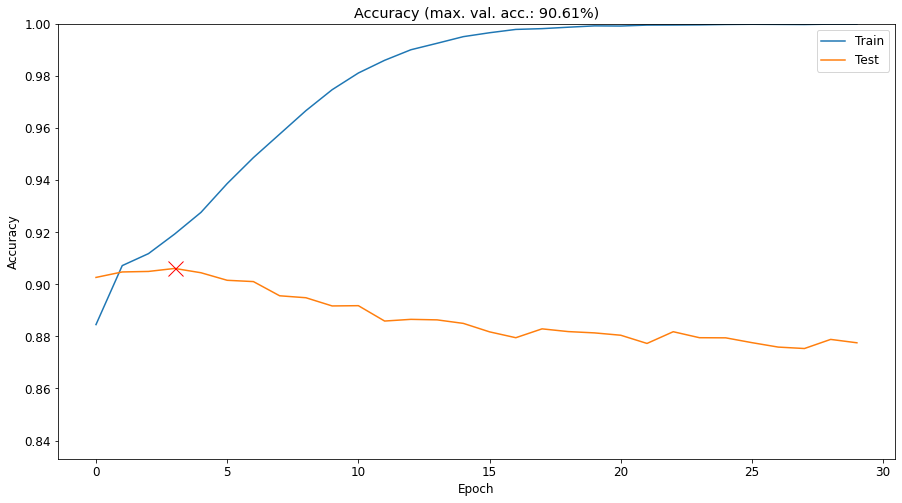

In [0]:
plot_history(history, limits=True)

The network can extract useful information, as the validation accuracy is above the baseline. Also, the capacity is high enough to fully overfit the training data. 

## Extraction of information with CNN

The model is able to learn, with training accuracy approaching 100% and validation accuray above baseline. The network is severely overfitting, but that is intentional/not the focus at this stage. The block below will add some convolutional layers. 

In [0]:
args = make_args(name='Conv initial 2', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 epochs=70, verbose=False, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 1)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

history = model.fit(train_images, train[target].values, epochs=args.epochs,
                    validation_data=(val_images, validation[target].values),
                    callbacks=[WandbCallback()])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)         

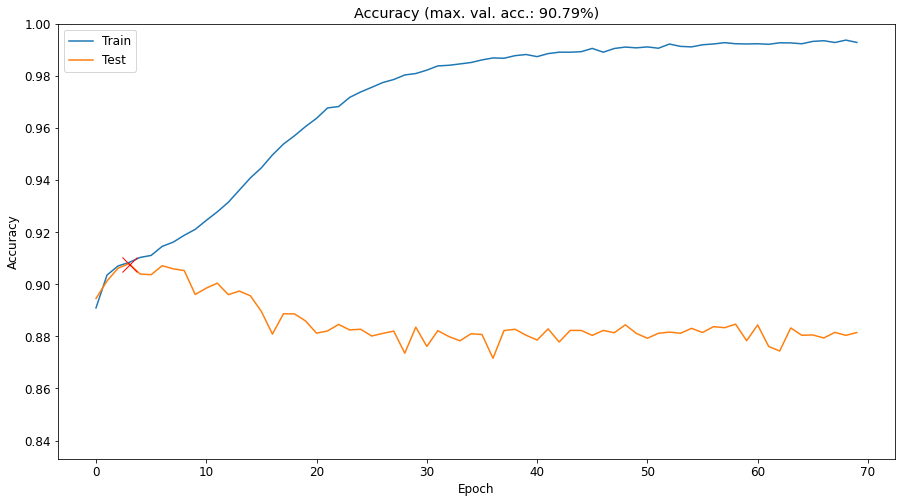

In [0]:
plot_history(history, limits=True)

With the addition of convolutional layers, the network is still able to extract useful features, achieving a bit higher maximal validation accuracy. Also, the network is able to overfit a lot, but does not reach as high as the previous (flat) network. 

# Part 2: Data augmentation
The processes are invariant under rotations of the azimuthal angle, I think. The symmetries of the pseudorapidity are investigated later. The `aug_wrapper` function shifts the images cyclical in the y-direction, which coindices with rotations of the azimuth. 

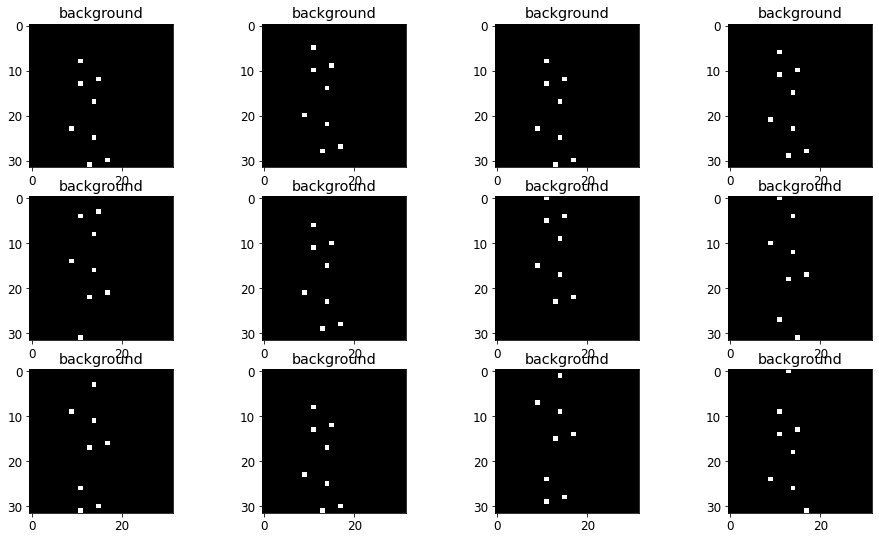

In [0]:
# create data generator
datagen = ImageDataGenerator({}) # cyclical shift not found, will implement it in a generator wrapper

# calculate statistics and create iterator
datagen.fit(train_images)
train_iterator = datagen.flow(train_images, train[target], 
                              batch_size = args.batch_size,
                              shuffle=False)

# show augmented images
f, axes = plt.subplots(3, 4, figsize=(16, 9))
for i, ax in enumerate(np.ravel(axes)):
    train_iterator.reset()
    x, y = next(aug_wrapper(train_iterator))
    process_type = "4-top event" if y[0] else "background"
    ax.imshow(x[0].squeeze(), cmap='gray'); ax.set_title(process_type)
plt.show()

In [0]:
args = make_args(name='Conv initial - aug', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 epochs=70, verbose=False, wandb_init=True)


# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 1)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs, 
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, validation[target].values),
                    callbacks=[WandbCallback()], verbose=0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 16)        160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 64)         

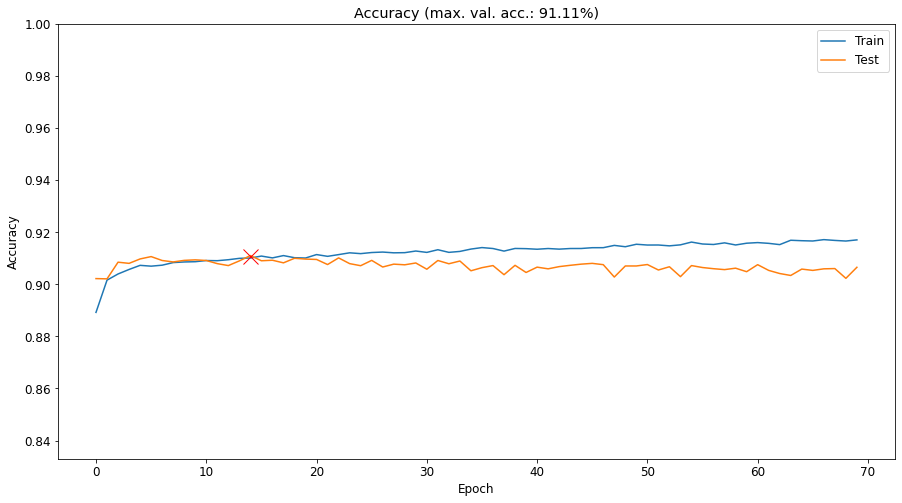

In [0]:
plot_history(history, limits=True)

**Result**: With the introduction of the cyclical permutation (rotation of azimuth), the validation accuracy increased and generalization error decreased significantly.  

# Part 3: Tie both networks together with the functional API
Overall performance is still inferior to the performance of a Random Forest/dense network on all features, but that is not necesairily a problem. The goal is to extract additional information. To this extend, the convolutional neural network will be paired with a dense network. 

In [0]:
from tensorflow.keras.layers import Dropout, Dense, Flatten, Input, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def get_model(args, input_shape_mlp, input_shape_cnn):
    print("Building model...")
    # clear previous sessions
    K.clear_session()

    # LeakyReLU cannot be used as string
    activation = args.activation
    if activation == 'LeakyReLU':
        activation = LeakyReLU()

    # add first layer with correct input size
    inp_mlp = Input(input_shape_mlp, name="mlp_input")
    x = Dense(128, activation=activation)(inp_mlp)
    x = Dropout(rate=0.15)(x)
    x = Dense(64, activation=activation)(x)
    # x = Dropout(rate=0.15)(x)
    # x = Dense(32, activation=activation)(x)

    ###### CNN PIPELINE #######
    inp_cnn = Input(input_shape_cnn, name="cnn_input")
    y = Conv2D(16, (3, 3), activation=args.activation)(inp_cnn)
    y = Conv2D(16, (3, 3), activation=args.activation)(y)
    y = MaxPooling2D((2, 2))(y)
    y = Conv2D(32, (3, 3), activation=args.activation)(y)
    y = Conv2D(32, (3, 3), activation=args.activation)(y)
    y = MaxPooling2D((2, 2))(y)
    y = Conv2D(64, (3, 3), activation=args.activation)(y)
    y = Flatten()(y)
    
    # concatenate MLP and CNN pipelines
    z = concatenate([x, y])
    z = Dropout(rate=0.15)(z)
    z = Dense(32, activation=activation)(z)
    z = Dropout(rate=0.15)(z)

    out = Dense(1, activation=args.final_activation, name='out')(z)
    
    model = Model(inputs=[inp_mlp, inp_cnn], outputs=out)

    model.compile(loss=args.loss,
                  optimizer=args.optimizer,
                  metrics=['acc'])
    
    return model

## Test 1: verify CNN pipeline

In [0]:
args = make_args(name='Combined - disabled MLP', architecture='Dual',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 batch_size = 128, trans='log', norm='minmax',
                 epochs=70, verbose=False, wandb_init=True)

model = get_model(args, input_shape_mlp=(len(features),),
                        input_shape_cnn=(32, 32, 1))

model.summary()

Building model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 16)   160         cnn_input[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 16)   0           conv2d_1[0][0]                   
____________________________________________________________________________

In [0]:
def generator_wrapper(generator):
    """Need two inputs: mlp_input and cnn_input, 
    of which the latter are augmented by an ImageDataGenerator.
    I've created an ImageDataGenerator with both mlp_input and target
    values as y values, so those need to be extracted before feeding
    to the neural network. 
    """
    
    for batch_x, batch_y in generator:
        # decode y to the correct inputs

        target = np.array([[yrow['y']] for yrow in batch_y])

        yield {'mlp_input': np.array([yrow['x_mlp'] for yrow in batch_y]), 
               'cnn_input': np.array(batch_x)}, target

In [0]:
datagen = ImageDataGenerator({})
train_iterator = datagen.flow(
    x = train_images,
    y = [{'x_mlp': xi, 'y': yi} for (xi, yi) in zip(np.ones_like(train[features].values), train[target].values.astype('float32'))],
    batch_size = args.batch_size
)

# x, y = next(generator_wrapper(train_iterator))
val_datagen = ImageDataGenerator({})
val_iterator = val_datagen.flow(
    x = val_images,
    y = [{'x_mlp': xi, 'y': yi} for (xi, yi) in zip(np.ones_like(validation[features].values), validation[target].values.astype('float32'))],
    batch_size = args.batch_size
)

In [0]:
# test performance of the model WITHOUT the MLP part by only feeding ones to the MLP network
# this is to test whether this pipeline is correctly set up within the model
train_generator = generator_wrapper(aug_wrapper(train_iterator))

history = model.fit(train_generator, epochs=args.epochs,
          steps_per_epoch=train_iterator.n // train_iterator.batch_size,
          validation_data=generator_wrapper(val_iterator),
          validation_steps=val_iterator.n // val_iterator.batch_size,
          verbose=1, callbacks=[WandbCallback()])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 625 steps, validate for 156 steps
Epoch 1/70
625/625 [==============================] - 5s 9ms/step - loss: 0.2996 - acc: 0.8771 - val_loss: 0.2463 - val_acc: 0.8945
Epoch 2/70
625/625 [==============================] - 4s 7ms/step - loss: 0.2458 - acc: 0.8998 - val_loss: 0.2405 - val_acc: 0.8985
Epoch 3/70
625/625 [==============================] - 5s 7ms/step - loss: 0.2329 - acc: 0.9044 - val_loss: 0.2177 - val_acc: 0.9109
Epoch 4/70
625/625 [==============================] - 4s 7ms/step - loss: 0.2301 - acc: 0.9061 - val_loss: 0.2184 - val_acc: 0.9104
Epoch 5/70
625/625 [==============================] - 4s 7ms/step - loss: 0.2274 - acc: 0.9058 - val_loss: 0.2188 - val_acc: 0.9090
Epoch 6/70
625/625 [==============================] - 5s 7ms/step - loss: 0.2273 - acc: 0.9068 - val_loss: 0.2172 - val_acc: 0.9082
Epoch 7/70
625/625 [==============================] - 4s 7ms/step - loss: 0.2267 - acc: 0.9071 - val_loss: 0.2265 

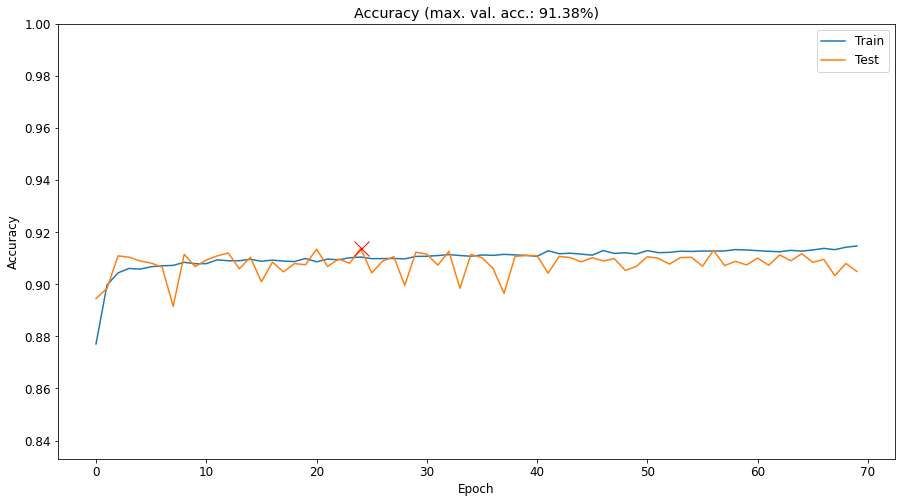

In [0]:
plot_history(history, limits=True)

Similar performance is achieved compared to the simple CNN from before, verifying the pipeline of the CNN is correct. 

## Test 2: verify MLP pipeline

In [0]:
args = make_args(name='Combined - disabled CNN', architecture='Dual',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 batch_size = 128, trans='log', norm='minmax',
                 epochs=70, verbose=False, wandb_init=True)

model = get_model(args, input_shape_mlp=(len(features),),
                        input_shape_cnn=(32, 32, 1))

model.summary()

Building model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 16)   160         cnn_input[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 16)   0           conv2d_1[0][0]                   
____________________________________________________________________________

In [0]:
datagen = ImageDataGenerator({})
train_iterator = datagen.flow(
    x = np.ones_like(train_images),
    y = [{'x_mlp': xi, 'y': yi} for (xi, yi) in zip(train[features].values, train[target].values.astype('float32'))],
    batch_size = args.batch_size
)

val_datagen = ImageDataGenerator({})
val_iterator = val_datagen.flow(
    x = np.ones_like(val_images),
    y = [{'x_mlp': xi, 'y': yi} for (xi, yi) in zip(validation[features].values, validation[target].values.astype('float32'))],
    batch_size = args.batch_size
)

In [0]:
# test performance of the model WITHOUT the CNN part by only feeding ones to the CNN network
# this is to test whether the MLP pipeline is correctly set up within the model
train_generator = generator_wrapper(aug_wrapper(train_iterator))

history = model.fit(train_generator, epochs=args.epochs,
          steps_per_epoch=train_iterator.n // train_iterator.batch_size,
          validation_data=generator_wrapper(val_iterator),
          validation_steps=val_iterator.n // val_iterator.batch_size,
          verbose=1, callbacks=[WandbCallback()])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 625 steps, validate for 156 steps
Epoch 1/70
625/625 [==============================] - 5s 8ms/step - loss: 0.2493 - acc: 0.9001 - val_loss: 0.2149 - val_acc: 0.9128
Epoch 2/70
625/625 [==============================] - 4s 7ms/step - loss: 0.2163 - acc: 0.9123 - val_loss: 0.2050 - val_acc: 0.9158
Epoch 3/70
625/625 [==============================] - 4s 7ms/step - loss: 0.2039 - acc: 0.9173 - val_loss: 0.2086 - val_acc: 0.9115
Epoch 4/70
625/625 [==============================] - 5s 7ms/step - loss: 0.1939 - acc: 0.9211 - val_loss: 0.1913 - val_acc: 0.9214
Epoch 5/70
625/625 [==============================] - 4s 7ms/step - loss: 0.1872 - acc: 0.9242 - val_loss: 0.1786 - val_acc: 0.9269
Epoch 6/70
625/625 [==============================] - 4s 7ms/step - loss: 0.1810 - acc: 0.9264 - val_loss: 0.1784 - val_acc: 0.9273
Epoch 7/70
625/625 [==============================] - 4s 7ms/step - loss: 0.1766 - acc: 0.9286 - val_loss: 0.1771 

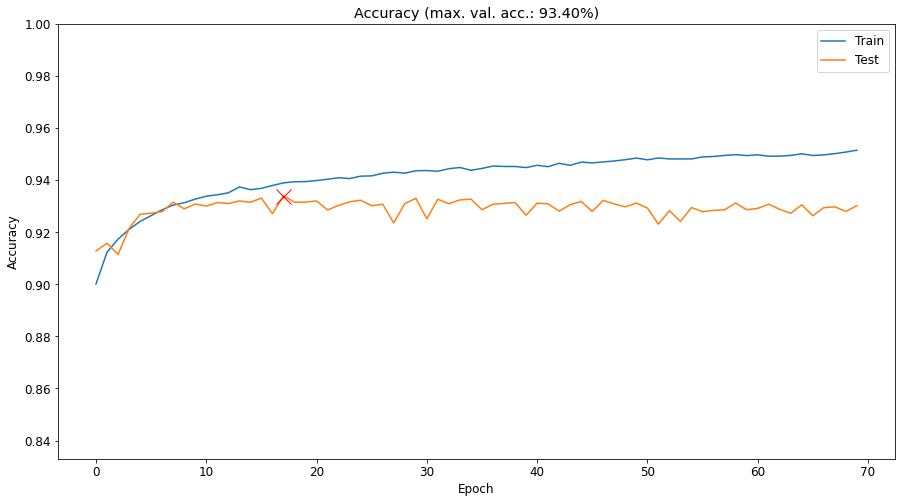

In [0]:
plot_history(history, limits=True)

Similar performance is achieved compared to the MLP network from `Train Deep Neural Networks`, verifying the pipeline of the MLP is correct. 

## Test 3: Baseline, enable both pipelines

In [0]:
args = make_args(name='Combined - baseline', architecture='Dual',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 batch_size = 128, trans='log', norm='minmax',
                 epochs=70, verbose=False, wandb_init=True)

model = get_model(args, input_shape_mlp=(len(features),),
                        input_shape_cnn=(32, 32, 1))

model.summary()

Building model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 16)   160         cnn_input[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 16)   0           conv2d_1[0][0]                   
____________________________________________________________________________

In [0]:
datagen = ImageDataGenerator({})
train_iterator = datagen.flow(
    x = train_images,
    y = [{'x_mlp': xi, 'y': yi} for (xi, yi) in zip(train[features].values, train[target].values.astype('float32'))],
    batch_size = args.batch_size
)

val_datagen = ImageDataGenerator({})
val_iterator = val_datagen.flow(
    x = val_images,
    y = [{'x_mlp': xi, 'y': yi} for (xi, yi) in zip(validation[features].values, validation[target].values.astype('float32'))],
    batch_size = args.batch_size
)

In [0]:
# test performance of the model WITHOUT the CNN part by only feeding ones to the CNN network
# this is to test whether the MLP pipeline is correctly set up within the model
train_generator = generator_wrapper(aug_wrapper(train_iterator))

history = model.fit(train_generator, epochs=args.epochs,
          steps_per_epoch=train_iterator.n // train_iterator.batch_size,
          validation_data=generator_wrapper(val_iterator),
          validation_steps=val_iterator.n // val_iterator.batch_size,
          verbose=1, callbacks=[WandbCallback()])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 625 steps, validate for 156 steps
Epoch 1/70
625/625 [==============================] - 6s 9ms/step - loss: 0.2446 - acc: 0.9019 - val_loss: 0.2135 - val_acc: 0.9110
Epoch 2/70
625/625 [==============================] - 5s 7ms/step - loss: 0.2159 - acc: 0.9134 - val_loss: 0.2028 - val_acc: 0.9157
Epoch 3/70
625/625 [==============================] - 4s 7ms/step - loss: 0.2065 - acc: 0.9161 - val_loss: 0.1999 - val_acc: 0.9157
Epoch 4/70
625/625 [==============================] - 4s 7ms/step - loss: 0.1968 - acc: 0.9194 - val_loss: 0.1889 - val_acc: 0.9235
Epoch 5/70
625/625 [==============================] - 4s 7ms/step - loss: 0.1890 - acc: 0.9240 - val_loss: 0.1836 - val_acc: 0.9236
Epoch 6/70
625/625 [==============================] - 4s 7ms/step - loss: 0.1826 - acc: 0.9254 - val_loss: 0.1790 - val_acc: 0.9272
Epoch 7/70
625/625 [==============================] - 4s 7ms/step - loss: 0.1763 - acc: 0.9276 - val_loss: 0.1751 

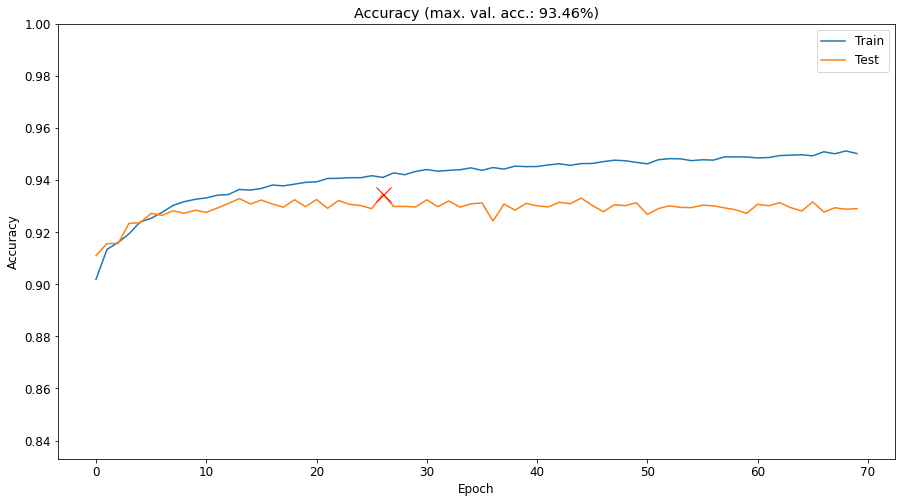

In [0]:
plot_history(history, limits=True)

**Result**: The maximal validation accuracy increased a bit, but the network suffers from overfitting. The data augmentation is not applied here. The CNN network is further investigated below. 

# Part 4: Optimization of CNN

## Provide object type as channel
The dataset contains seven types of objects (e+, e-, b-jet, etc.). Here we split the angle-information between seven channels, one for each object type. The resulting image with seven channels is fed to a CNN. 

In [0]:
norm_minmax = pd.read_csv("data/norm_minmax.csv", header=None, index_col=0)
norm_minmax.columns = ["factor"]
norm_minmax

factor
0                
obj18_j       1.0
obj17_b       1.0
obj17_j       1.0
obj17_m-      1.0
obj16_b       1.0
...           ...
obj14_num     6.0
obj15_num     6.0
obj16_num     6.0
obj17_num     2.0
obj18_num     1.0

[245 rows x 1 columns]

In [0]:
cols = train.filter(regex='num').columns
train[cols] = (train[cols] * norm_minmax.loc[cols].values.T + 1).astype(int)
validation[cols] = (validation[cols] * norm_minmax.loc[cols].values.T + 1).astype(int)

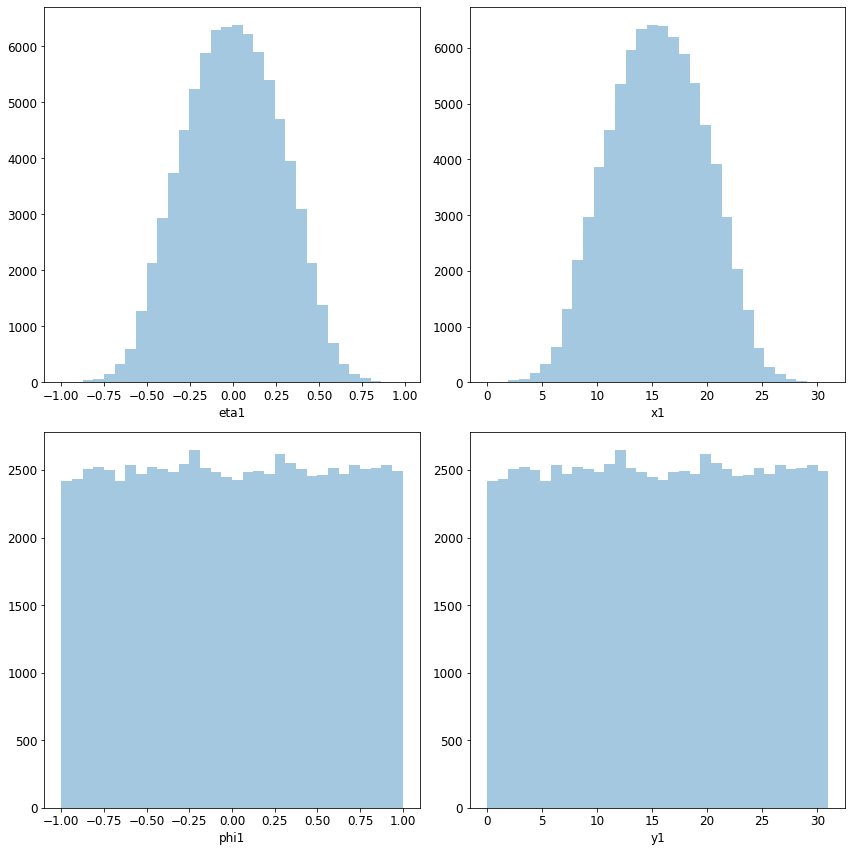

100%|██████████| 80000/80000 [00:44<00:00, 1811.50it/s]


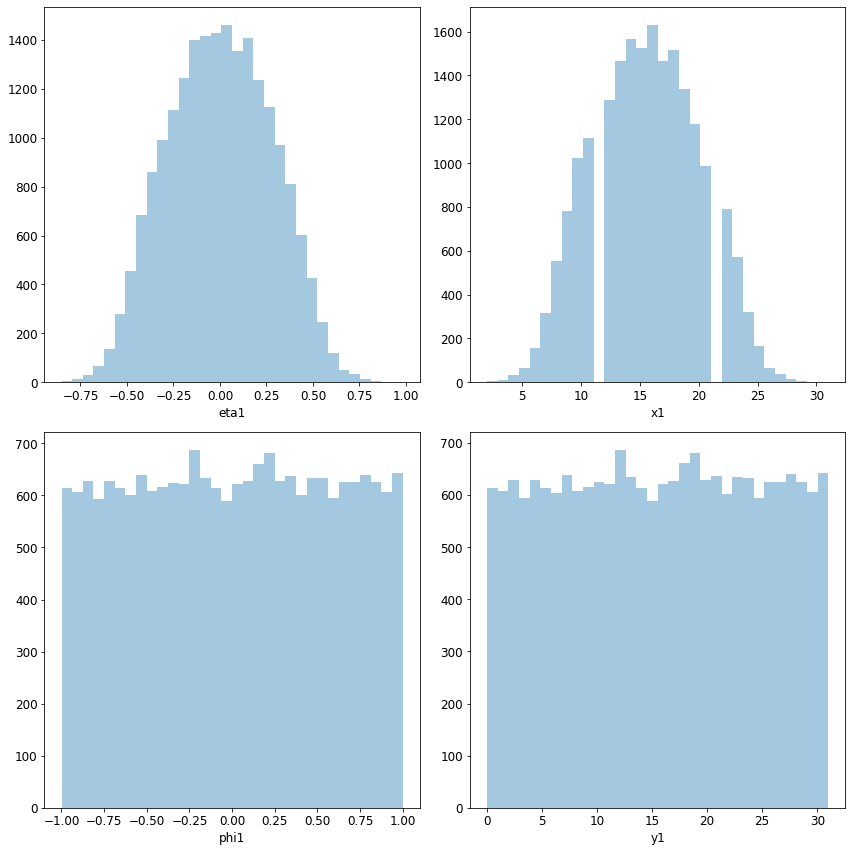

100%|██████████| 20000/20000 [00:10<00:00, 1867.15it/s]


In [0]:
def obj_angles_to_seven_channel_images(df, nx=32, ny=32, max_num_objects=25, xmin=-1, xmax=1, ymin=-1, ymax=1):
    # prevent changing input
    df = df.copy()

    # initialize images
    images = np.zeros(shape=(df.index.size, ny, nx, 7))

    # calculate pixel positions of objects
    # bin eta values onto the pixels in x-direction
    xbins = np.linspace(xmin, xmax, num=nx+1)
    xlabels = range(nx)
    # bin phi values onto the pixels in y-direction
    ybins = np.linspace(ymin, ymax, num=ny+1)
    ylabels = range(ny)

    # bin eta and phi to the bins specified above
    for i in range(1, 1+max_num_objects):
        # eta and phi need to be binned, for each object
        df['x{}'.format(i)] = pd.cut(df['eta{}'.format(i)], bins=xbins, labels=xlabels)
        df['y{}'.format(i)] = pd.cut(df['phi{}'.format(i)], bins=ybins, labels=ylabels)
    
    f, axes = plt.subplots(2, 2, figsize=(12, 12))
    sns.distplot(df['eta1'], bins=nx, ax=axes[0, 0], kde=False)
    sns.distplot(df['x1'], bins=nx, ax=axes[0, 1], kde=False)
    sns.distplot(df['phi1'], bins=ny, ax=axes[1, 0], kde=False)
    sns.distplot(df['y1'], bins=ny, ax=axes[1, 1], kde=False)
    plt.tight_layout()
    plt.show()

    # create images
    for nr, (idx, row) in tqdm(enumerate(df.iterrows()), total=df.index.size):
        # create image from event data
        for i in range(1, 1+max_num_objects):
            x, y = row['x{}'.format(i)], row['y{}'.format(i)]
            if not np.isnan(x) and not np.isnan(y):
                x, y = int(x), int(y)
                # due to the zero padding, many values are zero instead of NaN
                if not (x == 0 and y==0):
                    obj_num = row['obj{}_num'.format(i)]
                    if obj_num > 0:
                        # used obj_num = 0 as padding (with decoding of above cells)
                        images[nr, y, x, obj_num-1] = 1 

    return images

# calculate span of eta and phi
xmin, xmax = train.filter(regex='^eta').min().min(), train.filter(regex='^eta').max().max()
ymin, ymax = train.filter(regex='^phi').min().min(), train.filter(regex='^phi').max().max()

# create images
train_images = obj_angles_to_seven_channel_images(train, max_num_objects=18, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
val_images = obj_angles_to_seven_channel_images(validation, max_num_objects=18, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

### Test 1: CNN performance

In [0]:
# create data generator
datagen = ImageDataGenerator({}) # cyclical shift not found, will implement it in a generator wrapper

# calculate statistics and create iterator
datagen.fit(train_images)
train_iterator = datagen.flow(train_images, train[target], 
                              batch_size = args.batch_size)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 7) (7 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 7) (7 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
args = make_args(name='Conv - obj type (7 ch) - aug', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 epochs=70, verbose=False, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 7)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 16)        1024      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 64)          1

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs, 
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, validation[target].values),
                    callbacks=[WandbCallback()], verbose=0)

  ...
    to  
  ['...']


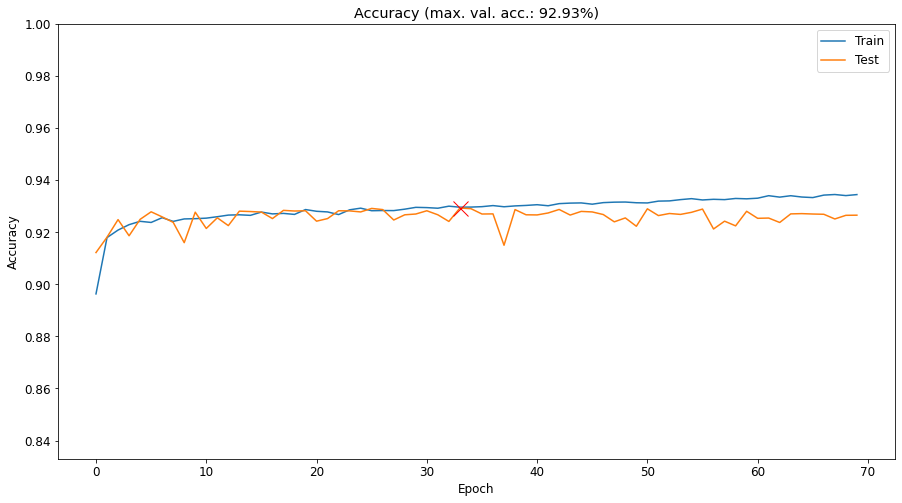

In [0]:
plot_history(history, limits=True)

**Result**: compared to the version without object type information (Part 2), the maximal validation accuracy increased from 91.11% to 92.93%. An increase of 1.82%.

In [0]:
# cleanup
del train_images
del val_images
gc.collect()

50279

## Provide energy as channel intensity

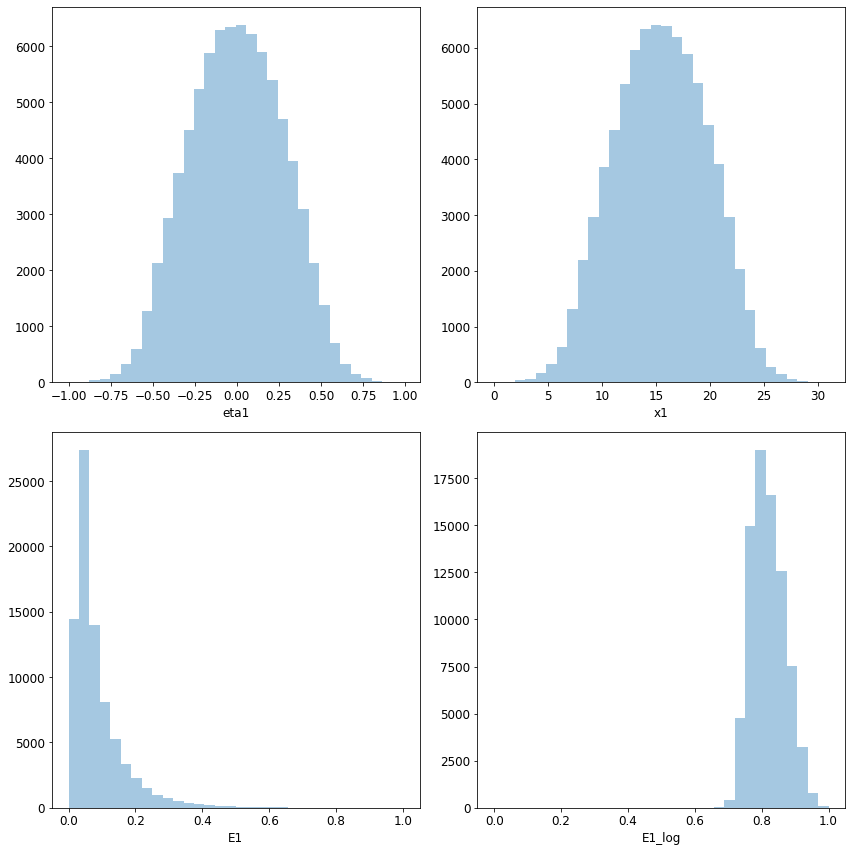

100%|██████████| 80000/80000 [00:53<00:00, 1485.42it/s]


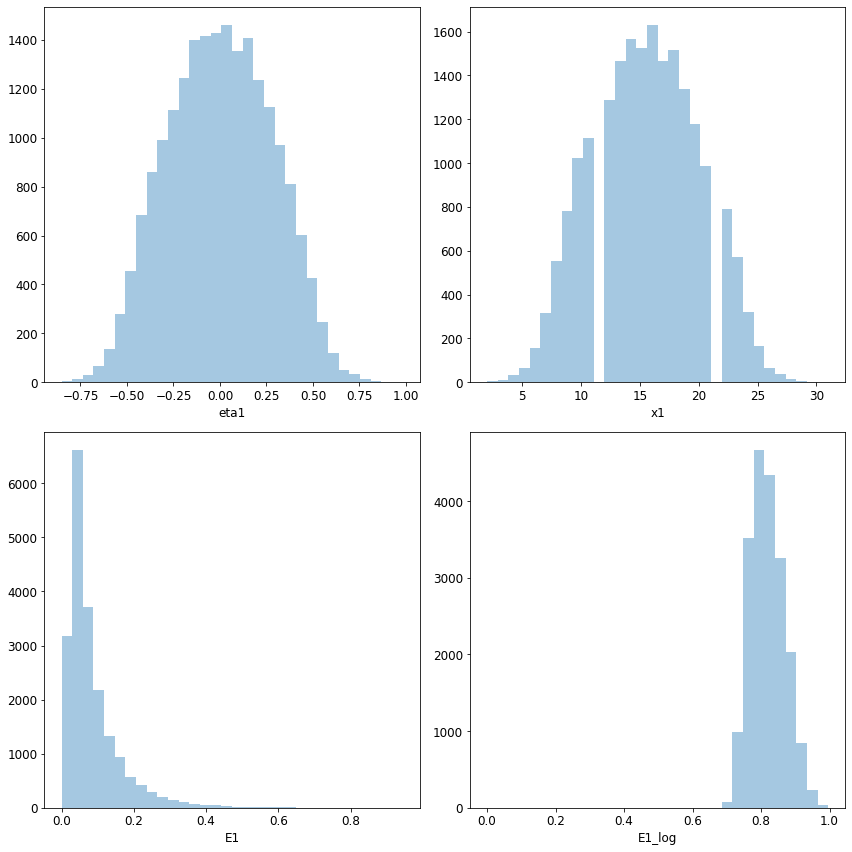

100%|██████████| 20000/20000 [00:13<00:00, 1483.62it/s]


In [0]:
def obj_angles_to_seven_channel_images_with_energy(df, nx=32, ny=32, max_num_objects=25, xmin=-1, xmax=1, ymin=-1, ymax=1):
    # prevent changing input
    df = df.copy()

    # initialize images
    images = np.zeros(shape=(df.index.size, ny, nx, 7))

    # calculate pixel positions of objects
    # bin eta values onto the pixels in x-direction
    xbins = np.linspace(xmin, xmax, num=nx+1)
    xlabels = range(nx)
    # bin phi values onto the pixels in y-direction
    ybins = np.linspace(ymin, ymax, num=ny+1)
    ylabels = range(ny)

    # bin eta and phi to the bins specified above
    for i in range(1, 1+max_num_objects):
        # eta and phi need to be binned, for each object
        df['x{}'.format(i)] = pd.cut(df['eta{}'.format(i)], bins=xbins, labels=xlabels)
        df['y{}'.format(i)] = pd.cut(df['phi{}'.format(i)], bins=ybins, labels=ylabels)
    
    f, axes = plt.subplots(2, 2, figsize=(12, 12))
    sns.distplot(df['eta1'], bins=nx, ax=axes[0, 0], kde=False)
    sns.distplot(df['x1'], bins=nx, ax=axes[0, 1], kde=False)
    sns.distplot(df['E1'], bins=ny, ax=axes[1, 0], kde=False)
    sns.distplot(df['E1_log'], bins=ny, ax=axes[1, 1], kde=False)
    plt.tight_layout()
    plt.show()

    # create images
    for nr, (idx, row) in tqdm(enumerate(df.iterrows()), total=df.index.size):
        # create image from event data
        for i in range(1, 1+max_num_objects):
            x, y = row['x{}'.format(i)], row['y{}'.format(i)]
            if not np.isnan(x) and not np.isnan(y):
                x, y = int(x), int(y)
                # due to the zero padding, many values are zero instead of NaN
                if not (x == 0 and y==0):
                    obj_num = row['obj{}_num'.format(i)]
                    energy = row['E{}_log'.format(i)]
                    if obj_num > 0:
                        # used obj_num = 0 as padding (with decoding of above cells)
                        images[nr, y, x, obj_num-1] = energy

    return images

# calculate span of eta and phi
xmin, xmax = train.filter(regex='^eta').min().min(), train.filter(regex='^eta').max().max()
ymin, ymax = train.filter(regex='^phi').min().min(), train.filter(regex='^phi').max().max()

# create images
train_images = obj_angles_to_seven_channel_images_with_energy(train, max_num_objects=18, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
val_images = obj_angles_to_seven_channel_images_with_energy(validation, max_num_objects=18, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

### Test 2: CNN performance

In [0]:
# create data generator
datagen = ImageDataGenerator({}) # cyclical shift not found, will implement it in a generator wrapper

# calculate statistics and create iterator
datagen.fit(train_images)
train_iterator = datagen.flow(train_images, train[target], 
                              batch_size = args.batch_size)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 7) (7 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 7) (7 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
args = make_args(name='Conv - obj type & energy (7 ch) - aug', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 epochs=70, verbose=False, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 7)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 16)        1024      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 64)         

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs, 
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, validation[target].values),
                    callbacks=[WandbCallback()], verbose=0)

  ...
    to  
  ['...']


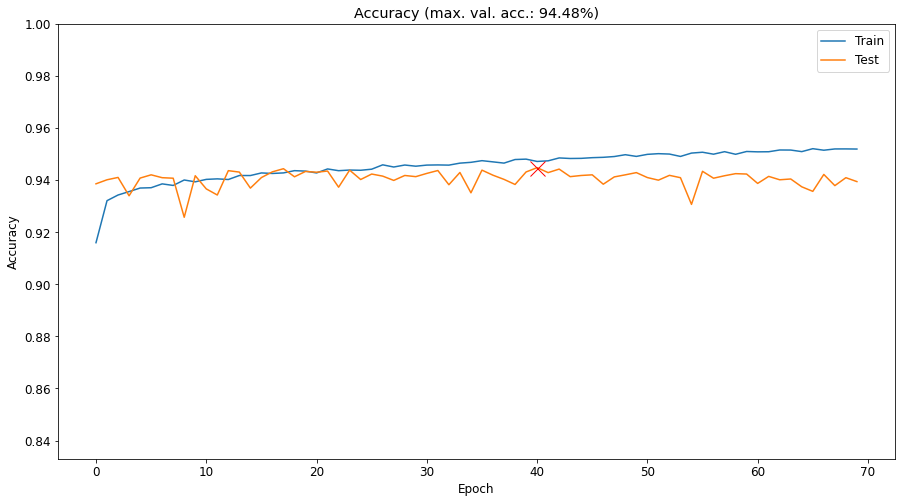

In [0]:
plot_history(history, limits=True)

**Result**: compared to the version without object-level energies (Part 4-Test 1), the maximal validation accuracy increased from 92.93% to 94.48%. An increase of 1.55%.

In [0]:
# cleanup
import gc
del train_images
del val_images
gc.collect()

47259

## Provide event-level information as additional channel


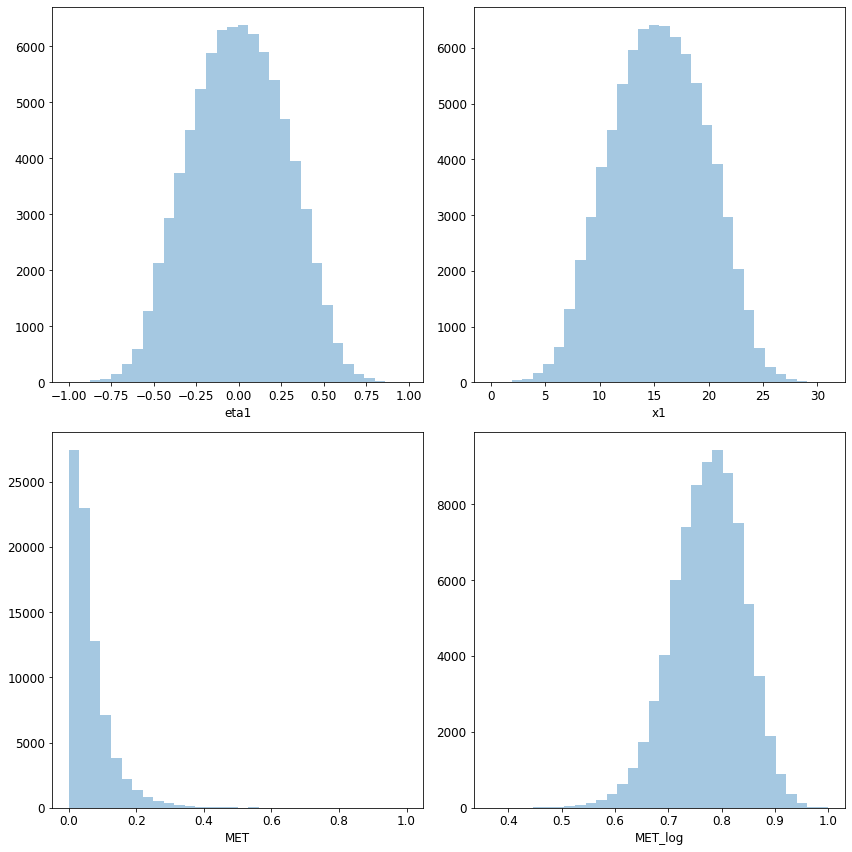

100%|██████████| 80000/80000 [00:55<00:00, 1441.44it/s]


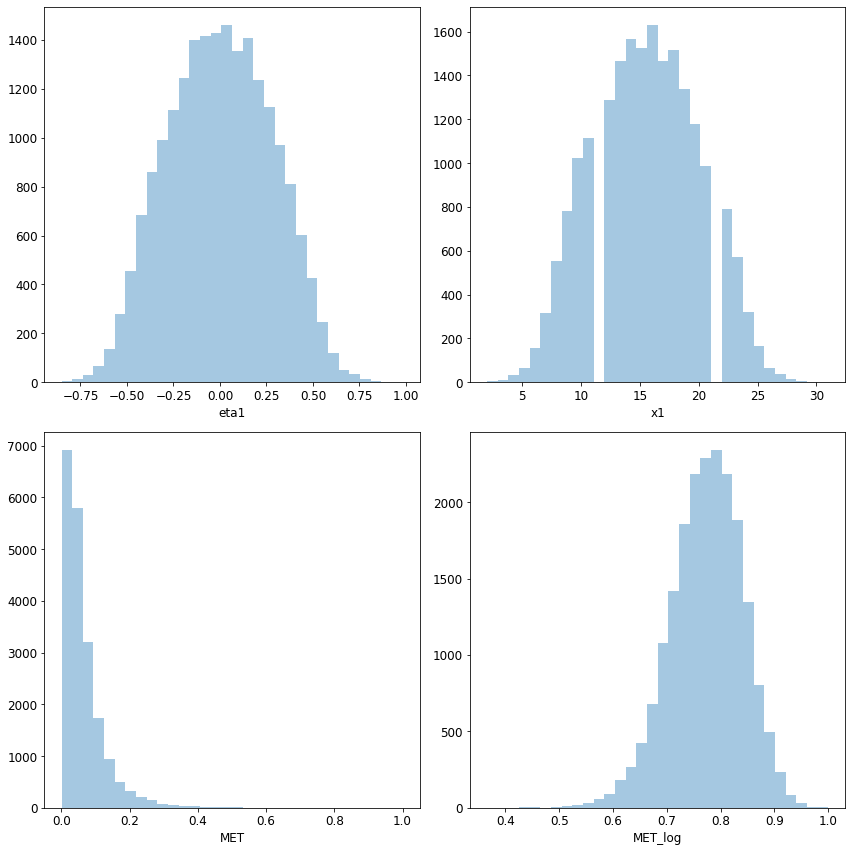

100%|██████████| 20000/20000 [00:13<00:00, 1488.29it/s]


In [0]:
def angles_to_eight_channel_images_with_energy(df, nx=32, ny=32, max_num_objects=25, xmin=-1, xmax=1, ymin=-1, ymax=1):
    # prevent changing input
    df = df.copy()

    # initialize images
    images = np.zeros(shape=(df.index.size, ny, nx, 8))

    # calculate pixel positions of objects
    # bin eta values onto the pixels in x-direction
    xbins = np.linspace(xmin, xmax, num=nx+1)
    xlabels = range(nx)
    # bin phi values onto the pixels in y-direction
    ybins = np.linspace(ymin, ymax, num=ny+1)
    ylabels = range(ny)

    # bin eta and phi to the bins specified above
    for i in range(1, 1+max_num_objects):
        # eta and phi need to be binned, for each object
        df['x{}'.format(i)] = pd.cut(df['eta{}'.format(i)], bins=xbins, labels=xlabels)
        df['y{}'.format(i)] = pd.cut(df['phi{}'.format(i)], bins=ybins, labels=ylabels)
    
    # also bin event-level phi angle
    df['y_MET'] = pd.cut(df['METphi'], bins=ybins, labels=ylabels)
    
    f, axes = plt.subplots(2, 2, figsize=(12, 12))
    sns.distplot(df['eta1'], bins=nx, ax=axes[0, 0], kde=False)
    sns.distplot(df['x1'], bins=nx, ax=axes[0, 1], kde=False)
    sns.distplot(df['MET'], bins=ny, ax=axes[1, 0], kde=False)
    sns.distplot(df['MET_log'], bins=ny, ax=axes[1, 1], kde=False)
    plt.tight_layout()
    plt.show()

    # create images
    for nr, (idx, row) in tqdm(enumerate(df.iterrows()), total=df.index.size):
        # add event-level energy to first channel
        y, energy = row['y_MET'], row['MET_log']
        if not np.isnan(y):
            y = int(y)
            images[nr, y, (nx+1)//2, 0] = energy

        # add object-level energies to subsequent channels
        for i in range(1, 1+max_num_objects):
            x, y = row['x{}'.format(i)], row['y{}'.format(i)]
            if not np.isnan(x) and not np.isnan(y):
                x, y = int(x), int(y)
                # due to the zero padding, many values are zero instead of NaN
                if not (x == 0 and y==0):
                    obj_num = row['obj{}_num'.format(i)]
                    energy = row['E{}_log'.format(i)]
                    if obj_num > 0:
                        # used obj_num = 0 as padding (with decoding of above cells)
                        images[nr, y, x, obj_num] = energy

    return images

# calculate span of eta and phi
xmin, xmax = train.filter(regex='^eta').min().min(), train.filter(regex='^eta').max().max()
ymin, ymax = train.filter(regex='^phi').min().min(), train.filter(regex='^phi').max().max()

# create images
train_images = angles_to_eight_channel_images_with_energy(train, max_num_objects=18, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
val_images = angles_to_eight_channel_images_with_energy(validation, max_num_objects=18, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

### Test 3: CNN performance

In [0]:
# create data generator
datagen = ImageDataGenerator({}) # cyclical shift not found, will implement it in a generator wrapper

# calculate statistics and create iterator
datagen.fit(train_images)
train_iterator = datagen.flow(train_images, train[target], 
                              batch_size = args.batch_size)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 8) (8 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 8) (8 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
args = make_args(name='Conv - event+obj type & energy (8 ch) - aug', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 epochs=70, verbose=False, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 8)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 30, 30, 16)        1168      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 3, 64)         

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs, 
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, validation[target].values),
                    callbacks=[WandbCallback()], verbose=0)

  ...
    to  
  ['...']


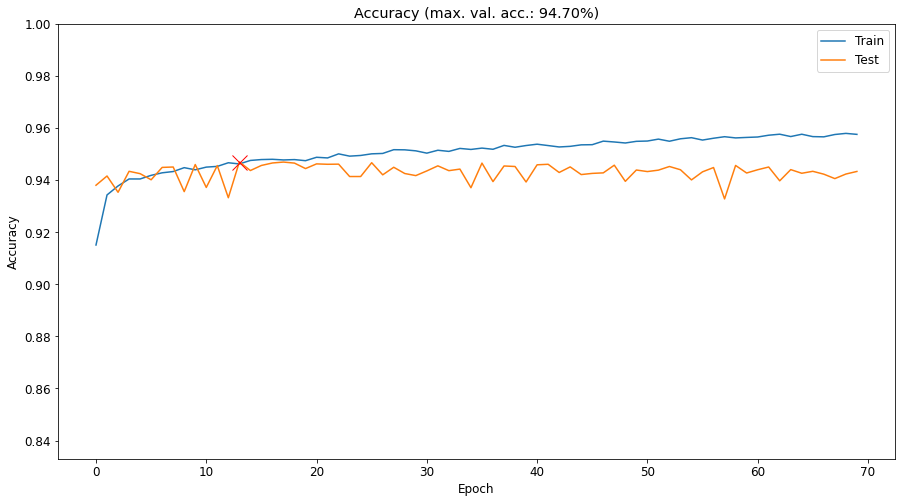

In [0]:
plot_history(history, limits=True)

**Result**: compared to the version without event-level energy and azimuth (Part 4-Test 2), the maximal validation accuracy increased from 94.48% to 94.70%. An increase of 0.22%.

In [0]:
# cleanup
import gc
del train_images
del val_images
gc.collect()

47358

## Provide transverse momentum as additional channels

In [0]:
train.filter(regex='pt').columns

Index(['pt1', 'pt2', 'pt3', 'pt4', 'pt5', 'pt6', 'pt7', 'pt8', 'pt9', 'pt10',
       'pt11', 'pt12', 'pt13', 'pt14', 'pt15', 'pt16', 'pt17', 'pt18',
       'pt1_log', 'pt2_log', 'pt3_log', 'pt4_log', 'pt5_log', 'pt6_log',
       'pt7_log', 'pt8_log', 'pt9_log', 'pt10_log', 'pt11_log', 'pt12_log',
       'pt13_log', 'pt14_log', 'pt15_log', 'pt16_log', 'pt17_log', 'pt18_log'],
      dtype='object')

In [0]:
def angles_to_15_channel_images_with_energy_and_momentum(df, nx=32, ny=32, max_num_objects=25, xmin=-1, xmax=1, ymin=-1, ymax=1):
    # prevent changing input
    df = df.copy()

    # initialize images
    images = np.zeros(shape=(df.index.size, ny, nx, 15))

    # calculate pixel positions of objects
    # bin eta values onto the pixels in x-direction
    xbins = np.linspace(xmin, xmax, num=nx+1)
    xlabels = range(nx)
    # bin phi values onto the pixels in y-direction
    ybins = np.linspace(ymin, ymax, num=ny+1)
    ylabels = range(ny)

    # bin eta and phi to the bins specified above
    for i in range(1, 1+max_num_objects):
        # eta and phi need to be binned, for each object
        df['x{}'.format(i)] = pd.cut(df['eta{}'.format(i)], bins=xbins, labels=xlabels)
        df['y{}'.format(i)] = pd.cut(df['phi{}'.format(i)], bins=ybins, labels=ylabels)
    
    # also bin event-level phi angle
    df['y_MET'] = pd.cut(df['METphi'], bins=ybins, labels=ylabels)
    
    # f, axes = plt.subplots(2, 2, figsize=(12, 12))
    # sns.distplot(df['eta1'], bins=nx, ax=axes[0, 0], kde=False)
    # sns.distplot(df['x1'], bins=nx, ax=axes[0, 1], kde=False)
    # sns.distplot(df['pt1'], bins=ny, ax=axes[1, 0], kde=False)
    # sns.distplot(df['pt1_log'], bins=ny, ax=axes[1, 1], kde=False)
    # plt.tight_layout()
    # plt.show()

    # create images
    for nr, (idx, row) in tqdm(enumerate(df.iterrows()), total=df.index.size):
        # add event-level energy to first channel
        y, energy = row['y_MET'], row['MET_log']
        if not np.isnan(y):
            y = int(y)
            images[nr, y, (nx+1)//2, 0] = energy

        # add object-level energies to subsequent channels
        for i in range(1, 1+max_num_objects):
            x, y = row['x{}'.format(i)], row['y{}'.format(i)]
            if not np.isnan(x) and not np.isnan(y):
                x, y = int(x), int(y)
                # due to the zero padding, many values are zero instead of NaN
                if not (x == 0 and y==0):
                    obj_num = row['obj{}_num'.format(i)]
                    energy = row['E{}_log'.format(i)]
                    momentum = row['pt{}_log'.format(i)]
                    if obj_num > 0:
                        # used obj_num = 0 as padding (with decoding of above cells)
                        images[nr, y, x, obj_num] = energy
                        images[nr, y, x, obj_num+7] = momentum

    del df
    gc.collect()
    return images

In [0]:
# calculate span of eta and phi
xmin, xmax = train.filter(regex='^eta').min().min(), train.filter(regex='^eta').max().max()
ymin, ymax = train.filter(regex='^phi').min().min(), train.filter(regex='^phi').max().max()

# create images
train_images = angles_to_15_channel_images_with_energy_and_momentum(train, max_num_objects=18, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
val_images = angles_to_15_channel_images_with_energy_and_momentum(validation, max_num_objects=18, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

100%|██████████| 20000/20000 [00:16<00:00, 1238.56it/s]


### Test 4: CNN performance

In [0]:
args = make_args(name='Conv - event+obj type & energy & momentum (15 ch) - aug', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 epochs=70, verbose=False, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        2176      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)          1

In [0]:
# create data generator
datagen = ImageDataGenerator({}) # cyclical shift not found, will implement it in a generator wrapper

# calculate statistics and create iterator
datagen.fit(train_images)
train_iterator = datagen.flow(train_images, train[target], 
                              batch_size = args.batch_size)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 15) (15 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 15) (15 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs, 
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, validation[target].values),
                    callbacks=[WandbCallback()], verbose=0)

  ...
    to  
  ['...']


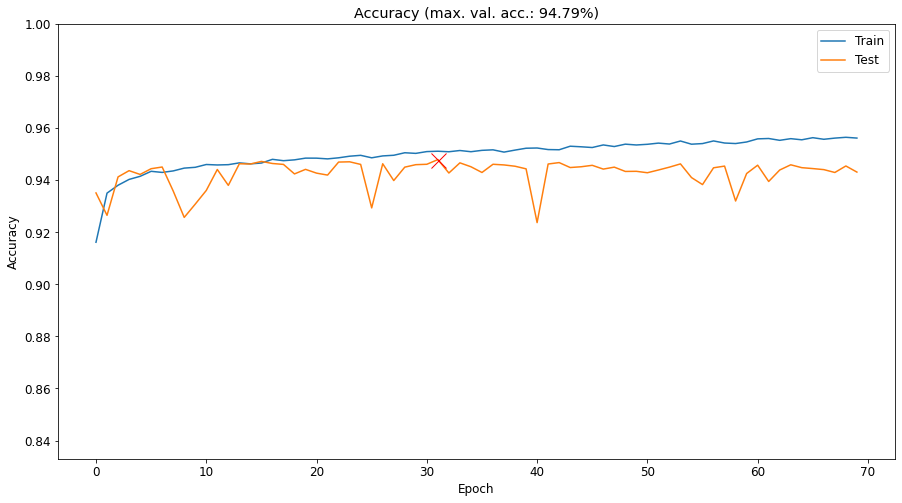

In [0]:
plot_history(history, limits=True)

**Result**: compared to the version without object-level momentum (Part 4-Test 3), the maximal validation accuracy increased from 94.70% to 94.79%. An increase of 0.09%.

## Architecture

### Test 5: Shallow CNN

In [0]:
args = make_args(name='Conv 16,16,24,24,32+32 - aug', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 epochs=70, verbose=False, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(24, (3, 3), activation=args.activation))
model.add(layers.Conv2D(24, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation=args.activation))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 16)        2176      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 24)        3480      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 24)        5208      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 24)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 32)         

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs, 
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, validation[target].values),
                    callbacks=[WandbCallback()], verbose=0)

  ...
    to  
  ['...']


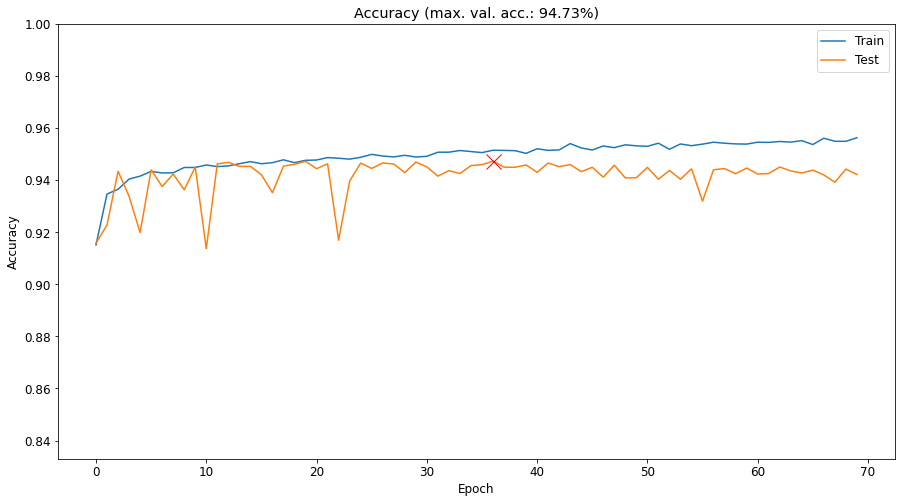

In [0]:
plot_history(history, limits=True)

**Result**: compared to the wider CNN (Part 4-Test 4), the maximal validation accuracy decreased from 94.79% to 94.73%. A decrease of 0.06%.

### Test 6: Shallower CNN

In [0]:
args = make_args(name='Conv 15,15,15,15,15+15 - aug', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 epochs=70, verbose=False, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(15, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(15, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(15, (3, 3), activation=args.activation))
model.add(layers.Conv2D(15, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(15, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dense(15, activation=args.activation))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 15)        2040      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 15)        2040      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 15)        2040      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 15)        2040      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 15)         

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs, 
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, validation[target].values),
                    callbacks=[WandbCallback()], verbose=0)

  ...
    to  
  ['...']


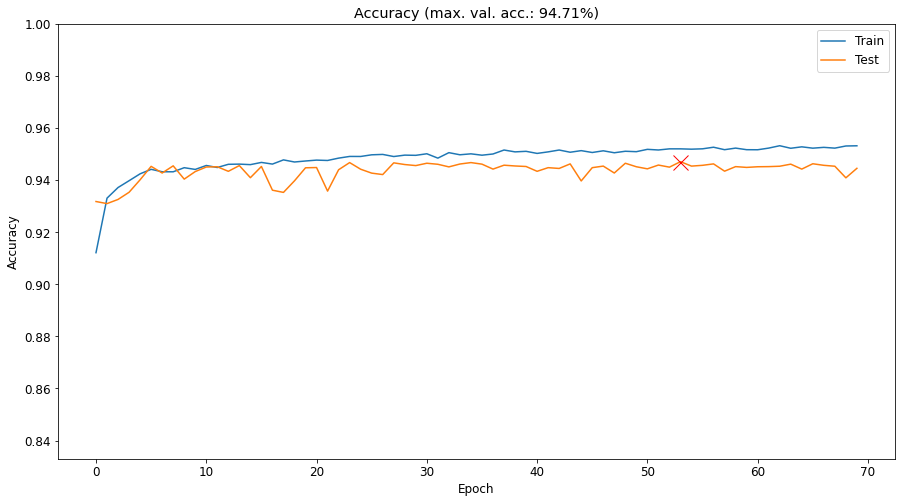

In [0]:
plot_history(history, limits=True)

**Result**: compared to the wider CNN (Part 4-Test 4), the maximal validation accuracy decreased from 94.79% to 94.71%. A decrease of 0.08%.

### Test 7: Dropout

#### 15%: Shallow CNN

In [0]:
args = make_args(name='Conv 16,16,24,24,32+32 - aug - dropout 15%', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 epochs=70, verbose=False, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.15))
model.add(layers.Conv2D(24, (3, 3), activation=args.activation))
model.add(layers.Conv2D(24, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.15))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.15))
model.add(layers.Dense(32, activation=args.activation))
model.add(layers.Dropout(rate=0.15))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 30, 30, 16)        2176      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 24)        3480      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 24)        5208      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 24)         

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs, 
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, validation[target].values),
                    callbacks=[WandbCallback()], verbose=0)

  ...
    to  
  ['...']


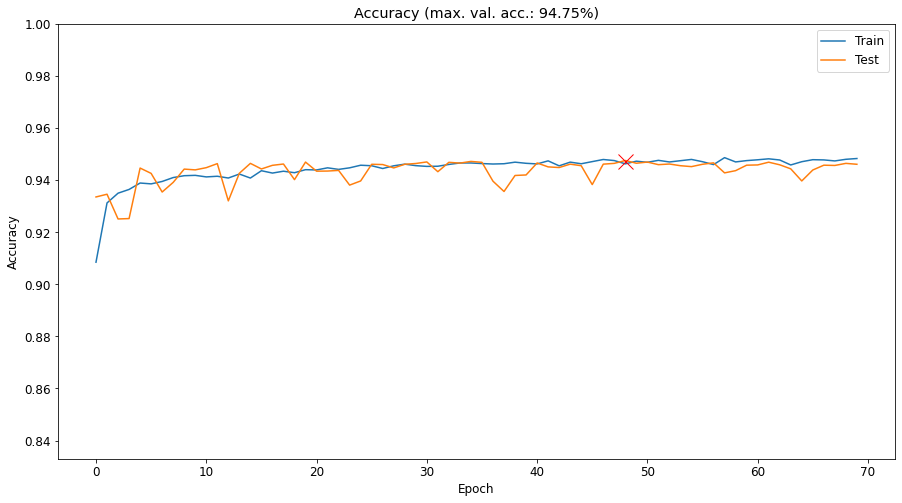

In [0]:
plot_history(history, limits=True)

**Result**: compared to the wider CNN (Part 4-Test 4), the maximal validation accuracy decreased from 94.79% to 94.75%. A decrease of 0.04%.

#### 15%: Network of Part 4-Test 4
Add dropout to the network used in Part4-Test 4 for direct comparison with the highest maximal validation accuracy so far. 

In [0]:
args = make_args(name='Conv 16,16,32,32,64+64 - aug - dropout 15%', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 epochs=70, verbose=False, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.15))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.15))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.15))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.15))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        2176      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs, 
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, validation[target].values),
                    callbacks=[WandbCallback()], verbose=0)

  ...
    to  
  ['...']


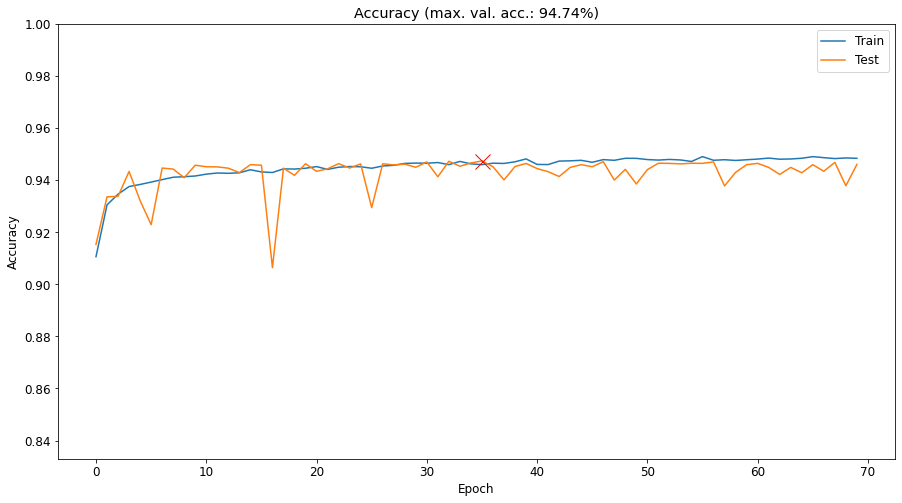

In [0]:
plot_history(history, limits=True)

**Result**: compared to the wider CNN (Part 4-Test 4), the maximal validation accuracy decreased from 94.79% to 94.74%. A decrease of 0.05%.

#### 10%: Network of Part 4-Test 4
Add dropout to the network used in Part4-Test 4 for direct comparison with the highest maximal validation accuracy so far. 

In [0]:
args = make_args(name='Conv 16,16,32,32,64+64 - aug - dropout 10%', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 epochs=70, verbose=False, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 16)        2176      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)         

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs, 
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, validation[target].values),
                    callbacks=[WandbCallback()], verbose=0)

  ...
    to  
  ['...']


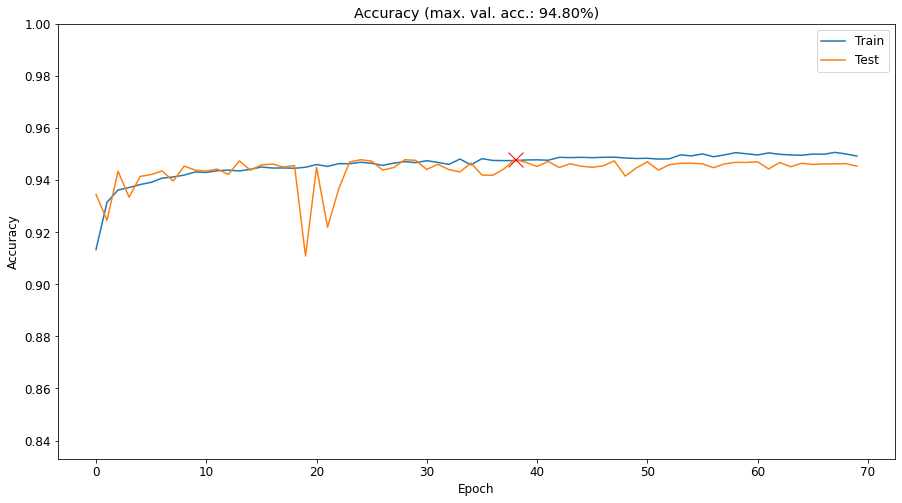

In [0]:
plot_history(history, limits=True)

**Result**: compared to the wider CNN (Part 4-Test 4), the maximal validation accuracy increaed from 94.79% to 94.80%. An increase of 0.01%. Especially with a metric which has high variance like the maximal validation accuracy, this does not signify much though. 

### Test 8: Trechter architecture

In [0]:
args = make_args(name='Conv 128,64,64,32,32+32 - aug - dropout 15%', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', 
                 epochs=50, verbose=False, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.15))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.15))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Flatten())
# model.add(layers.Dropout(rate=0.15))
model.add(layers.Dense(32, activation=args.activation))
model.add(layers.Dropout(rate=0.15))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 30, 30, 128)       17408     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 64)        73792     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 10, 10, 32)        18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 32)         

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs, 
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, validation[target].values),
                    callbacks=[WandbCallback()], verbose=0)

  ...
    to  
  ['...']


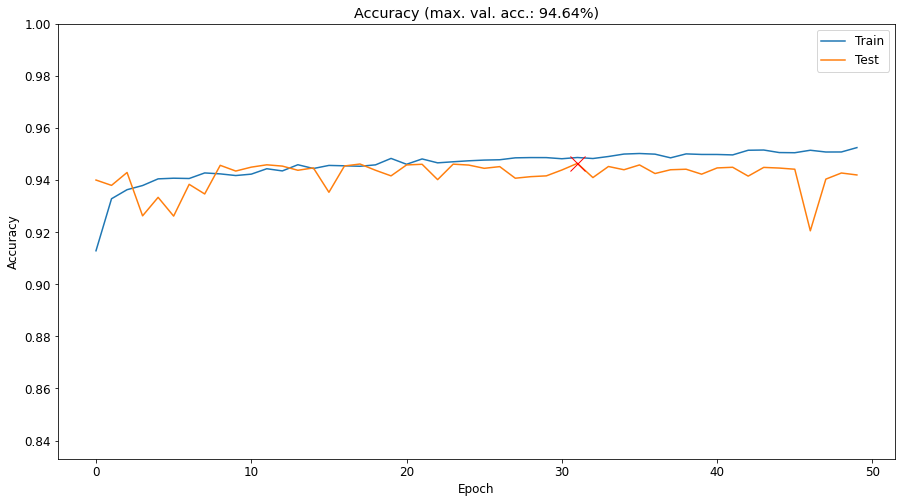

In [0]:
plot_history(history, limits=True)

**Result**: compared to the wider CNN (Part 4-Test 4), the maximal validation accuracy decreased from 94.79% to 94.64%. A decrease of 0.15%.

# Part 5: Towards final CNN model
Training these models requires a lot of RAM, about 25GB. This can be done in Google Colab with the High-RAM runtime (available with Colab Pro or after crashing due to RAM issues). For these blocks to work, the blocks at the start (above the title) and the function `angles_to_15_channel_images_with_energy_and_momentum` needs to be defined, in section **Provide transverse momentum as additional channels**.  

After this, the three blocks below can be run with any of the folds. (For me, the notebook crashed after sequentially running multiple folds, due to memory leaks/constraints). This problem has been fixed in Part 6. 

## Train models with cross validation and save best checkpoints
Employ Simulated Annealing for convergence.

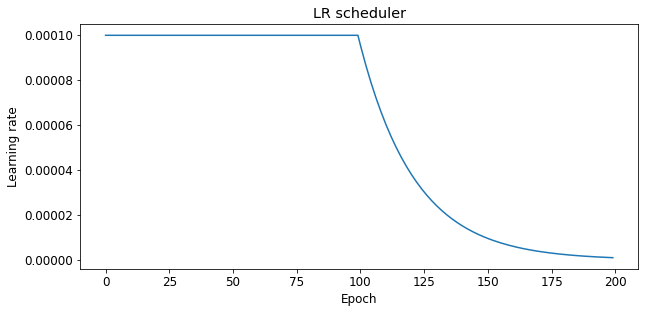

In [0]:
lr_start = 1e-4
lr_end = 1e-6
epochs_total = 200
epochs_warmup = 100

vals = []
for epoch in range(1, 1+epochs_total):
    if epoch < epochs_warmup:
        vals.append(lr_start)
    else:
        # want  lr_start * exp( -(epochs_total-epochs_warmup) * factor) ) = lr_end
        # so factor = -log(lr_end) / (epochs_total-epochs_warmup) / lr_start
        factor = -np.log(lr_end / lr_start) / (epochs_total - epochs_warmup)
        lr = lr_start * np.exp(-(epoch-epochs_warmup)*factor)
        vals.append(lr)

plt.plot(vals); plt.title("LR scheduler");
plt.xlabel('Epoch'); plt.ylabel("Learning rate"); plt.show()

In [0]:
def get_cv_images(args, cv_it=1, cv_splits=5):
    # read data
    data_df, features, target = load_data('data', trans=args.trans, norm='minmax') # only tested images with minmax

    print("Performing {}-fold cross validation with {} samples".format(
        cv_splits, data_df.index.size))

    # employ cross validation splits
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    # bit wacky, but this selects the cv-th set of train/test indices (with cv starting at ONE)
    for i in range(cv_it):
        train_indices, val_indices = next(kf.split(data_df))
    
    # (re)define train and validation sets
    train_df, val_df = data_df.iloc[train_indices], data_df.iloc[val_indices]
    del data_df
    gc.collect()
    print("Selected fold {}/{} with {} train samples and {} validation samples".format(
        cv_it, cv_splits, len(train_indices), len(val_indices)
    ))

    # denorm. obj nums
    norm_minmax = pd.read_csv("data/norm_minmax.csv", header=None, index_col=0)
    norm_minmax.columns = ["factor"]
    cols = train_df.filter(regex='num').columns
    train_df[cols] = (train_df[cols] * norm_minmax.loc[cols].values.T + 1).astype(int)
    val_df[cols] = (val_df[cols] * norm_minmax.loc[cols].values.T + 1).astype(int)

    # calculate span of eta and phi
    xmin, xmax = train_df.filter(regex='^eta').min().min(), train_df.filter(regex='^eta').max().max()
    ymin, ymax = train_df.filter(regex='^phi').min().min(), train_df.filter(regex='^phi').max().max()

    # create images
    train_images = angles_to_15_channel_images_with_energy_and_momentum(train_df, max_num_objects=18, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    val_images = angles_to_15_channel_images_with_energy_and_momentum(val_df, max_num_objects=18, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

    return train_images, val_images, train_df[target].values, val_df[target].values

## Fold 1/5

In [0]:
args = make_args(name='Towards final CNN - Fold 1/5 - exp decay 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                      Towards final CNN - Fold 1/5 - exp decay 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [0]:
# create images
train_images, val_images, y_train, y_val = get_cv_images(args, cv_it=1, cv_splits=5)

# create data generator
datagen = ImageDataGenerator({}) # cyclical shift not found, will implement it in a generator wrapper

# calculate statistics and create iterator
datagen.fit(train_images)
train_iterator = datagen.flow(train_images, y_train, 
                              batch_size = args.batch_size)

Performing 5-fold cross validation with 100000 samples
Selected fold 1/5 with 80000 train samples and 20000 validation samples


100%|██████████| 20000/20000 [00:16<00:00, 1237.12it/s]
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 15) (15 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 15) (15 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'weights_towards_final_cnn_fold1.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs,
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, y_val),
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

  ...
    to  
  ['...']
Train for 1250 steps, validate on 20000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1243/1250 [============================>.] - ETA: 0s - loss: 0.2353 - acc: 0.9073
Epoch 00001: val_loss improved from inf to 0.19382, saving model to weights_towards_final_cnn_fold1.h5
1250/1250 [==============================] - 12s 9ms/step - loss: 0.2350 - acc: 0.9074 - val_loss: 0.1938 - val_acc: 0.9236

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1243/1250 [============================>.] - ETA: 0s - loss: 0.1734 - acc: 0.9318
Epoch 00002: val_loss improved from 0.19382 to 0.17002, saving model to weights_towards_final_cnn_fold1.h5
1250/1250 [==============================] - 10s 8ms/step - loss: 0.1733 - acc: 0.9319 - val_loss: 0.1700 - val_acc: 0.9283

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/200
1249/1250 [============================>.] - ETA: 0s - loss: 0

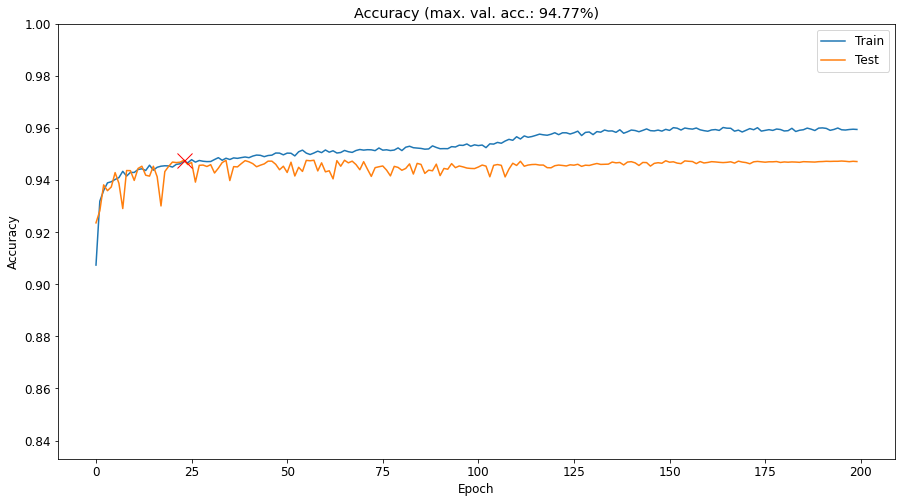

In [0]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_towards_final_cnn_fold1.h5")

In [0]:
# cleanup
del train_iterator
del train_images
del val_images
gc.collect()

## Fold 2/5

In [0]:
args = make_args(name='Towards final CNN - Fold 2/5 - exp decay 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                      Towards final CNN - Fold 2/5 - exp decay 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [0]:
# create images
train_images, val_images, y_train, y_val = get_cv_images(args, cv_it=2, cv_splits=5)

# create data generator
datagen = ImageDataGenerator({}) # cyclical shift not found, will implement it in a generator wrapper

# calculate statistics and create iterator
datagen.fit(train_images)
train_iterator = datagen.flow(train_images, y_train, 
                              batch_size = args.batch_size)

Performing 5-fold cross validation with 100000 samples
Selected fold 2/5 with 80000 train samples and 20000 validation samples


100%|██████████| 20000/20000 [00:16<00:00, 1243.98it/s]
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 15) (15 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 15) (15 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'weights_towards_final_cnn_fold2.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs,
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, y_val),
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

  ...
    to  
  ['...']
Train for 1250 steps, validate on 20000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.2322 - acc: 0.9084
Epoch 00001: val_loss improved from inf to 0.16895, saving model to weights_towards_final_cnn_fold2.h5
1250/1250 [==============================] - 12s 9ms/step - loss: 0.2319 - acc: 0.9085 - val_loss: 0.1690 - val_acc: 0.9321

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1248/1250 [============================>.] - ETA: 0s - loss: 0.1717 - acc: 0.9328
Epoch 00002: val_loss improved from 0.16895 to 0.15330, saving model to weights_towards_final_cnn_fold2.h5
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1717 - acc: 0.9328 - val_loss: 0.1533 - val_acc: 0.9376

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/200
1245/1250 [============================>.] - ETA: 0s - loss: 0.

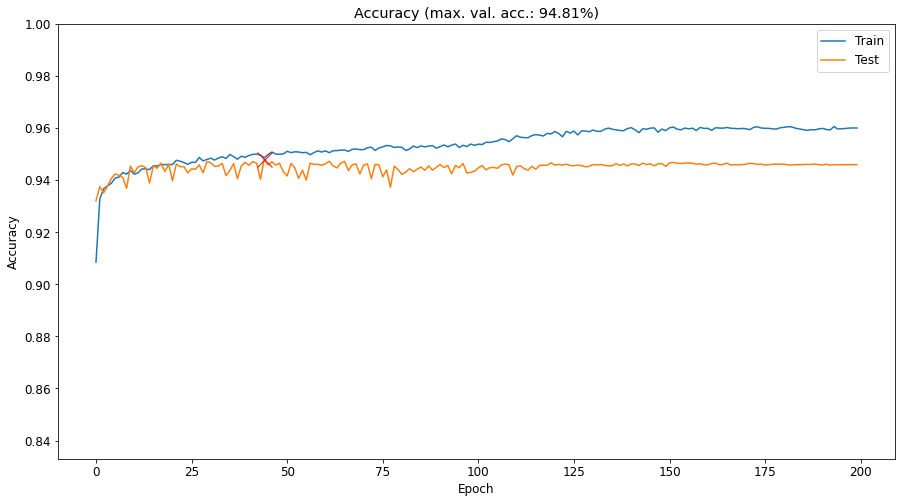

In [0]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_towards_final_cnn_fold2.h5")

## Fold 3/5

In [0]:
args = make_args(name='Towards final CNN - Fold 3/5 - exp decay 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                      Towards final CNN - Fold 3/5 - exp decay 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [0]:
# create images
train_images, val_images, y_train, y_val = get_cv_images(args, cv_it=3, cv_splits=5)

# create data generator
datagen = ImageDataGenerator({}) # cyclical shift not found, will implement it in a generator wrapper

# calculate statistics and create iterator
datagen.fit(train_images)
train_iterator = datagen.flow(train_images, y_train, 
                              batch_size = args.batch_size)

Performing 5-fold cross validation with 100000 samples
Selected fold 3/5 with 80000 train samples and 20000 validation samples


100%|██████████| 20000/20000 [00:16<00:00, 1237.42it/s]
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 15) (15 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 15) (15 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'weights_towards_final_cnn_fold3.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs,
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, y_val),
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

  ...
    to  
  ['...']
Train for 1250 steps, validate on 20000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1241/1250 [============================>.] - ETA: 0s - loss: 0.2288 - acc: 0.9099
Epoch 00001: val_loss improved from inf to 0.23059, saving model to weights_towards_final_cnn_fold3.h5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.2286 - acc: 0.9099 - val_loss: 0.2306 - val_acc: 0.9093

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1248/1250 [============================>.] - ETA: 0s - loss: 0.1715 - acc: 0.9321
Epoch 00002: val_loss improved from 0.23059 to 0.16938, saving model to weights_towards_final_cnn_fold3.h5
1250/1250 [==============================] - 10s 8ms/step - loss: 0.1716 - acc: 0.9320 - val_loss: 0.1694 - val_acc: 0.9295

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/200
1241/1250 [============================>.] - ETA: 0s - loss: 

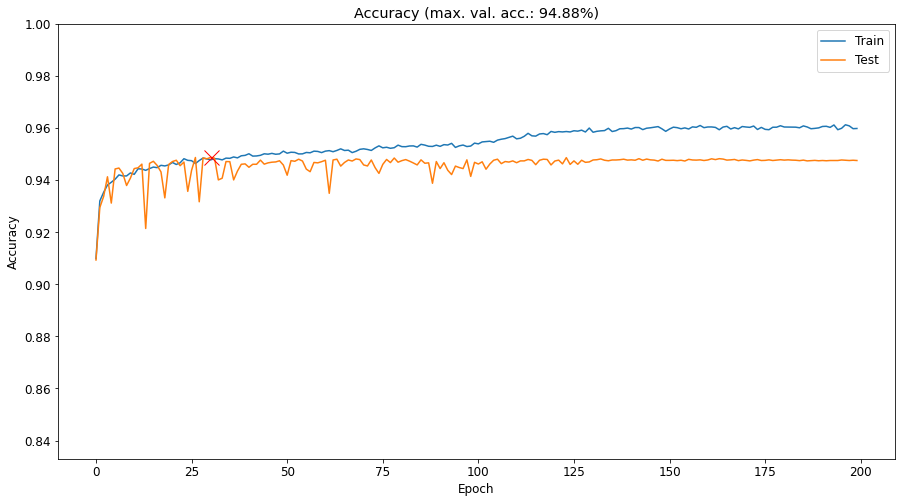

In [0]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_towards_final_cnn_fold3.h5")

## Fold 4/5

In [0]:
args = make_args(name='Towards final CNN - Fold 4/5 - exp decay 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                      Towards final CNN - Fold 4/5 - exp decay 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [0]:
# create images
train_images, val_images, y_train, y_val = get_cv_images(args, cv_it=4, cv_splits=5)

# create data generator
datagen = ImageDataGenerator({}) # cyclical shift not found, will implement it in a generator wrapper

# calculate statistics and create iterator
datagen.fit(train_images)
train_iterator = datagen.flow(train_images, y_train, 
                              batch_size = args.batch_size)

Performing 5-fold cross validation with 100000 samples
Selected fold 4/5 with 80000 train samples and 20000 validation samples


100%|██████████| 20000/20000 [00:15<00:00, 1298.11it/s]
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 15) (15 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 15) (15 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'weights_towards_final_cnn_fold4.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs,
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, y_val),
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

  ...
    to  
  ['...']
Train for 1250 steps, validate on 20000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1244/1250 [============================>.] - ETA: 0s - loss: 0.2290 - acc: 0.9085
Epoch 00001: val_loss improved from inf to 0.16818, saving model to weights_towards_final_cnn_fold4.h5
1250/1250 [==============================] - 12s 9ms/step - loss: 0.2286 - acc: 0.9087 - val_loss: 0.1682 - val_acc: 0.9358

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1244/1250 [============================>.] - ETA: 0s - loss: 0.1742 - acc: 0.9310
Epoch 00002: val_loss improved from 0.16818 to 0.15116, saving model to weights_towards_final_cnn_fold4.h5
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1740 - acc: 0.9311 - val_loss: 0.1512 - val_acc: 0.9394

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/200
1243/1250 [============================>.] - ETA: 0s - loss: 0.

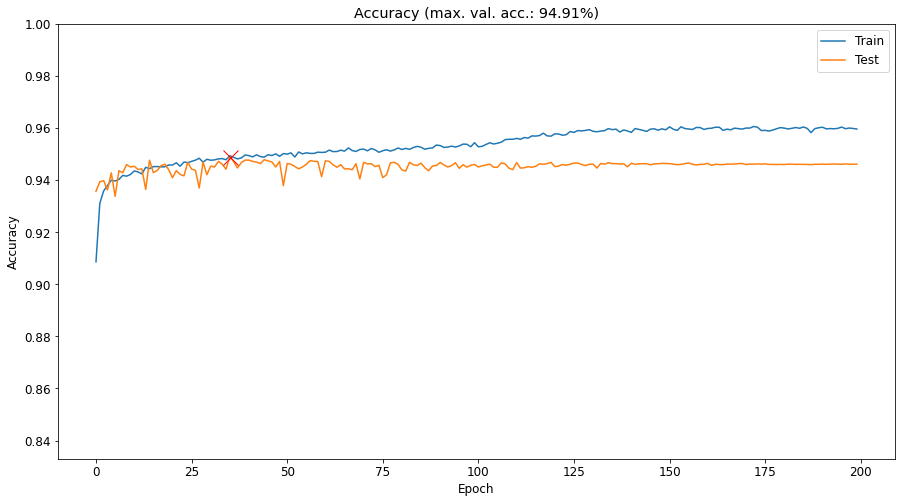

In [0]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_towards_final_cnn_fold4.h5")

## Fold 5/5

In [0]:
args = make_args(name='Towards final CNN - Fold 5/5 - exp decay 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                      Towards final CNN - Fold 4/5 - exp decay 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [0]:
# create images
train_images, val_images, y_train, y_val = get_cv_images(args, cv_it=5, cv_splits=5)

# create data generator
datagen = ImageDataGenerator({}) # cyclical shift not found, will implement it in a generator wrapper

# calculate statistics and create iterator
datagen.fit(train_images)
train_iterator = datagen.flow(train_images, y_train, 
                              batch_size = args.batch_size)

Performing 5-fold cross validation with 100000 samples
Selected fold 5/5 with 80000 train samples and 20000 validation samples


100%|██████████| 20000/20000 [00:16<00:00, 1249.04it/s]
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 15) (15 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (80000, 32, 32, 15) (15 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'weights_towards_final_cnn_fold5.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [0]:
# perform training
history = model.fit(aug_wrapper(train_iterator), epochs=args.epochs,
                    steps_per_epoch = train_iterator.n // train_iterator.batch_size,
                    validation_data=(val_images, y_val),
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

  ...
    to  
  ['...']
Train for 1250 steps, validate on 20000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1245/1250 [============================>.] - ETA: 0s - loss: 0.2367 - acc: 0.9058
Epoch 00001: val_loss improved from inf to 0.18993, saving model to weights_towards_final_cnn_fold5.h5
1250/1250 [==============================] - 12s 9ms/step - loss: 0.2363 - acc: 0.9060 - val_loss: 0.1899 - val_acc: 0.9222

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.1722 - acc: 0.9324
Epoch 00002: val_loss did not improve from 0.18993
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1725 - acc: 0.9323 - val_loss: 0.1944 - val_acc: 0.9186

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.1644 - acc: 0.9350
Epoch 00003: val_loss improved from 0

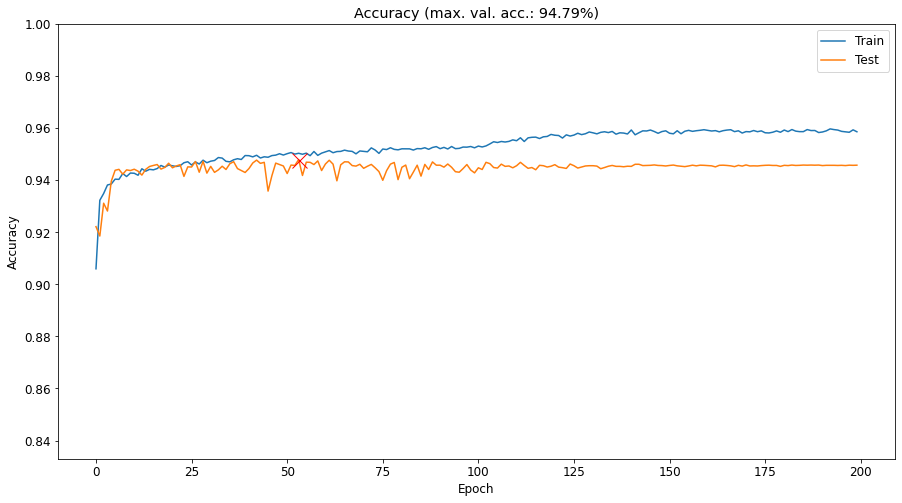

In [0]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_towards_final_cnn_fold5.h5")

# Part 6: inversion symmetry of pseudorapidity
Analysis of the experiment and the plot below suggest that the experiments are invariant under inversion of the pseudorapidity (with pi/2 as reflection axis). This translates to horizontal flipping of the generated images. 

In [0]:
# read train and validation data
data, features, target = load_data('data', trans='log', norm='minmax')
train, validation = train_test_split(data, test_size=0.2, random_state=random_state)

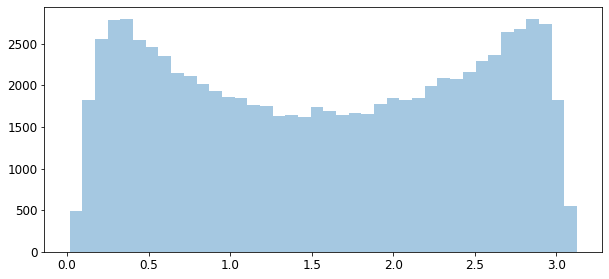

In [0]:
# Pseudorapidity: https://en.wikipedia.org/wiki/Pseudorapidity
train_norm = pd.read_csv('data/norm_minmax.csv', index_col=0, header=None).iloc[:,0]
x = train['eta1'].values * train_norm['eta1']
y = np.exp(-x)
z = 2*np.arctan(y)

sns.distplot(z, kde=False)

## Get general train/validation/test generator

In [15]:
def create_all_images(transformation='log'):
    # read train and validation data
    data_df, features, target = load_data('data', trans=transformation, norm='minmax') # only tested images with minmax

    # denormalize object numbers
    norm_minmax = pd.read_csv("data/norm_minmax.csv", header=None, index_col=0)
    norm_minmax.columns = ["factor"]
    cols = data_df.filter(regex='num').columns
    data_df[cols] = (data_df[cols] * norm_minmax.loc[cols].values.T + 1).astype(int)

    # calculate span of eta and phi
    xmin, xmax = data_df.filter(regex='^eta').min().min(), data_df.filter(regex='^eta').max().max()
    ymin, ymax = data_df.filter(regex='^phi').min().min(), data_df.filter(regex='^phi').max().max()

    # create images
    data_images = angles_to_15_channel_images_with_energy_and_momentum(data_df, max_num_objects=18, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

    return data_images, data_df[target].values

data_images, data_labels = create_all_images()

100%|██████████| 100000/100000 [01:20<00:00, 1248.60it/s]


In [0]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, all_images, all_labels, list_IDs, batch_size=64, dim=(32,32), 
                 n_channels=15, shuffle=True, ensure_all_samples=False):
        'Initialization'
        self.all_images = all_images
        self.all_labels = all_labels
        self.list_IDs = list_IDs

        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.ensure_all_samples = ensure_all_samples
        self.on_epoch_end()

        self.n = len(list_IDs)

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.ensure_all_samples:
            return int(np.ceil(self.n / self.batch_size ))
        return self.n // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp =  self.list_IDs[indexes] # [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)

        X = self.all_images[list_IDs_temp]
        y = self.all_labels[list_IDs_temp]

        return X, y

    def flow(self):
        while True:
            for index in range(self.__len__()):
                batch_x, batch_y = self.__getitem__(index)
                yield batch_x, batch_y
            self.on_epoch_end()

class GeneralGenerator(object):
    def __init__(self, all_images, all_labels, cv_splits=5, add_test_set=False, 
                 test_cv_it=1, batch_size=128, random_state=576, verbose=True):
        # store reference to images and labels
        self.all_images = all_images
        self.all_labels = all_labels
        self.n = len(all_labels)
        self.batch_size = batch_size
        self.all_indices = np.arange(len(all_images))
        self.random_state = random_state

        # set numer of cross-validation splits and whether a local test set should be kept apart
        self.cv_splits = cv_splits
        self.add_test_set = add_test_set

        # placeholders
        self.test_indices = None
        self.trainval_indices = None
        self.train_indices = None
        self.val_indices = None

        if add_test_set:
            # select test set
            kf = KFold(n_splits=cv_splits+1, shuffle=True, random_state=self.random_state)
            # bit wacky, but this selects the cv_test_it-th set of trainval/test indices (starting at ONE)
            for i in range(test_cv_it):
                self.trainval_indices, self.test_indices = next(kf.split(all_labels))
        else:
            self.trainval_indices = self.all_indices
        
        if verbose:
            if add_test_set:
                print("Performing {}-fold cross-validation with {} test samples".format(self.cv_splits, len(self.test_indices)))
            else:
                print("Performing {}-fold cross-validation".format(self.cv_splits))
            

    def get_generators(self, cv_it, verbose=True):
        # employ cross validation splits
        kf = KFold(n_splits=self.cv_splits, shuffle=True, random_state=self.random_state)
        # bit wacky, but this selects the cv-th set of train/val indices (starting at ONE)
        for i in range(cv_it):
            self.train_indices, self.val_indices = next(kf.split(self.trainval_indices))
        
        if verbose:
            print("Selected fold {}/{} with {} train samples and {} validation samples".format(
                cv_it, self.cv_splits, len(self.train_indices), len(self.val_indices)))
        
        if self.add_test_set:
            test_generator = DataGenerator(self.all_images, self.all_labels, self.test_indices, 
                                           batch_size=self.batch_size, shuffle=False,
                                           ensure_all_samples=True)
        else:
            test_generator = None
        train_generator = DataGenerator(self.all_images, self.all_labels, self.train_indices, 
                                       batch_size=self.batch_size)
        val_generator = DataGenerator(self.all_images, self.all_labels, self.val_indices, 
                                      batch_size=self.batch_size, shuffle=False,
                                      ensure_all_samples=True)

        return test_generator, train_generator, val_generator

In [17]:
# get general generator
general_generator = GeneralGenerator(all_images=data_images, all_labels=data_labels,
                                     cv_splits=5, add_test_set=False, batch_size=64)

Performing 5-fold cross-validation


## Flip pseudorapidity

Selected fold 1/5 with 80000 train samples and 20000 validation samples
Flipping eta. Showing first 3 channels.


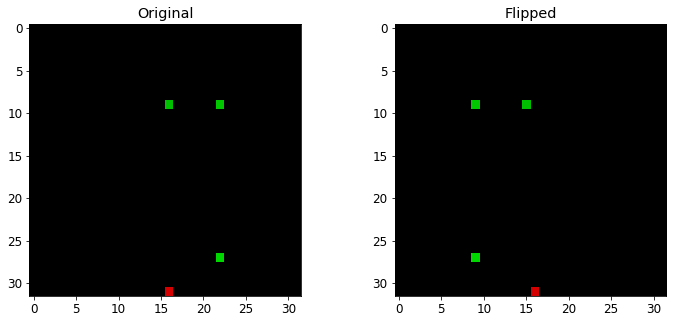

In [0]:
# get generators
test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=1)
# preview
gen = aug_wrapper(train_generator.flow(), flip_eta=True, skip_first_channel_flip=True, verbose=True)
x, y = next(gen)

### Fold 1/5

In [0]:
args = make_args(name='Pseudorapidity inversion - Fold 1/5 - exp 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                     Pseudorapidity inversion - Fold 1/5 - exp 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [0]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'pseudorapidity_inversion_skip_MET_fold1.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [0]:
# get generators
test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=1)

# perform training
history = model.fit(aug_wrapper(train_generator.flow(), flip_eta=True, skip_first_channel_flip=True), epochs=args.epochs,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_data=val_generator.flow(),
                    validation_steps=val_generator.n // val_generator.batch_size,
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

Selected fold 1/5 with 80000 train samples and 20000 validation samples
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1250 steps, validate for 312 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1247/1250 [============================>.] - ETA: 0s - loss: 0.2318 - acc: 0.9075
Epoch 00001: val_loss improved from inf to 0.17116, saving model to pseudorapidity_inversion_skip_MET_fold1.h5
1250/1250 [==============================] - 20s 16ms/step - loss: 0.2317 - acc: 0.9075 - val_loss: 0.1712 - val_acc: 0.9329

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1243/1250 [============================>.] - ETA: 0s - loss: 0.1762 - acc: 0.9304
Epoch 00002: val_loss improved from 0.17116 to 0.15161, saving model to pseudorapidity_inversion_skip_MET_fold1.h5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.1762 - acc: 0.9304 - val_loss: 0.1516 - val_acc: 0.9398

Epoch 00003: LearningRateSched

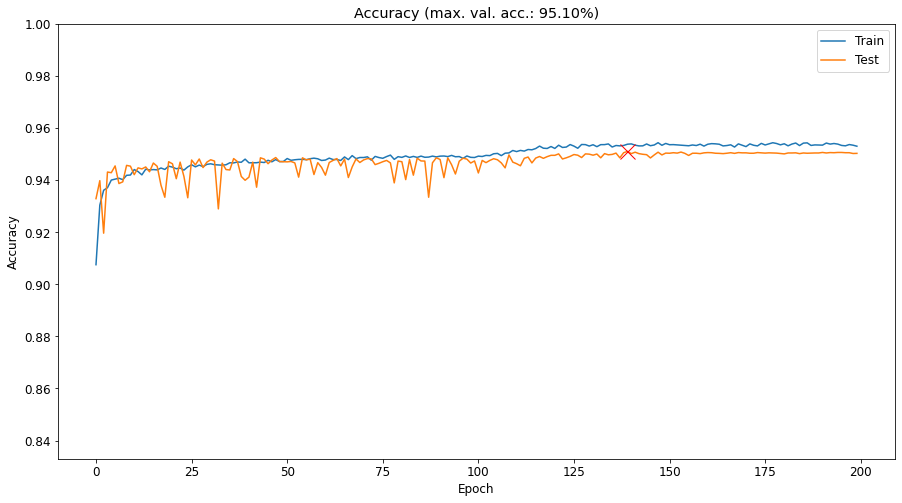

In [0]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_pseudorapidity_inversion_skip_MET_fold1.h5")

### Fold 2/5

In [0]:
args = make_args(name='Pseudorapidity inversion - Fold 2/5 - exp 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                     Pseudorapidity inversion - Fold 2/5 - exp 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [0]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'pseudorapidity_inversion_skip_MET_fold2.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [0]:
# get generators
test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=2)

# perform training
history = model.fit(aug_wrapper(train_generator.flow(), flip_eta=True, skip_first_channel_flip=True), epochs=args.epochs,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_data=val_generator.flow(),
                    validation_steps=val_generator.n // val_generator.batch_size,
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

Selected fold 2/5 with 80000 train samples and 20000 validation samples
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1250 steps, validate for 312 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1245/1250 [============================>.] - ETA: 0s - loss: 0.2286 - acc: 0.9091
Epoch 00001: val_loss improved from inf to 0.16295, saving model to pseudorapidity_inversion_skip_MET_fold2.h5
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2285 - acc: 0.9091 - val_loss: 0.1629 - val_acc: 0.9337

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1244/1250 [============================>.] - ETA: 0s - loss: 0.1725 - acc: 0.9318
Epoch 00002: val_loss did not improve from 0.16295
1250/1250 [==============================] - 13s 10ms/step - loss: 0.1724 - acc: 0.9318 - val_loss: 0.2353 - val_acc: 0.9169

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/200
1248/1250 [===

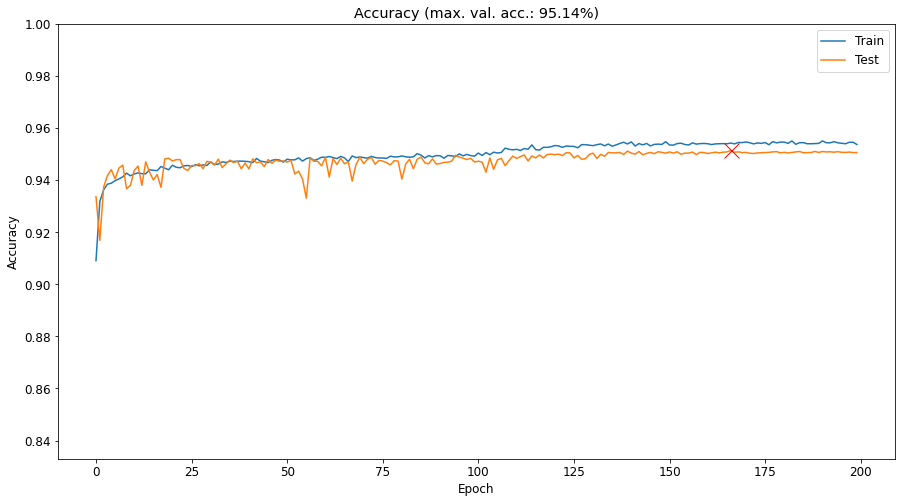

In [0]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_pseudorapidity_inversion_skip_MET_fold2.h5")

### Fold 3/5

In [0]:
args = make_args(name='Pseudorapidity inversion - Fold 3/5 - exp 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                     Pseudorapidity inversion - Fold 3/5 - exp 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [0]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'pseudorapidity_inversion_skip_MET_fold3.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [0]:
# get generators
test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=3)

# perform training
history = model.fit(aug_wrapper(train_generator.flow(), flip_eta=True, skip_first_channel_flip=True), epochs=args.epochs,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_data=val_generator.flow(),
                    validation_steps=val_generator.n // val_generator.batch_size,
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

Selected fold 3/5 with 80000 train samples and 20000 validation samples
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1250 steps, validate for 312 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.2274 - acc: 0.9098
Epoch 00001: val_loss improved from inf to 0.17016, saving model to pseudorapidity_inversion_skip_MET_fold3.h5
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2271 - acc: 0.9100 - val_loss: 0.1702 - val_acc: 0.9324

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.1710 - acc: 0.9319
Epoch 00002: val_loss did not improve from 0.17016
1250/1250 [==============================] - 12s 10ms/step - loss: 0.1712 - acc: 0.9318 - val_loss: 0.1763 - val_acc: 0.9260

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/200
1249/1250 [===

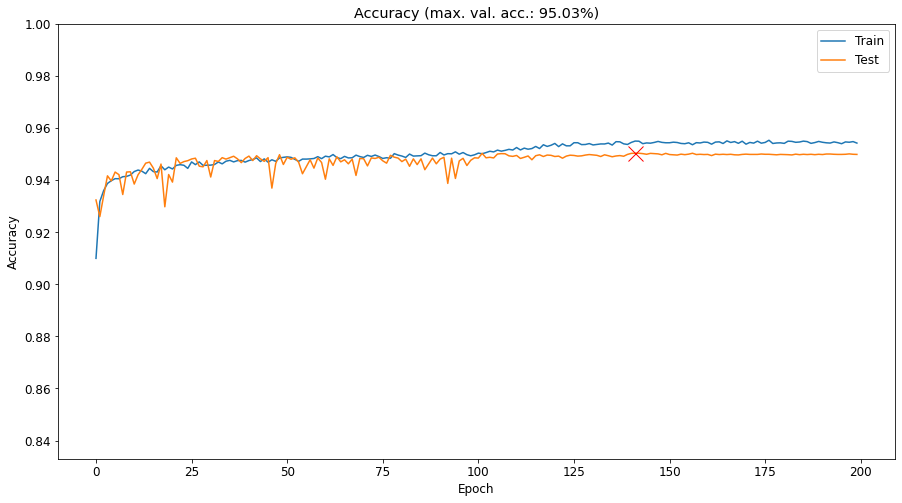

In [0]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_pseudorapidity_inversion_skip_MET_fold3.h5")

### Fold 4/5

In [0]:
args = make_args(name='Pseudorapidity inversion - Fold 4/5 - exp 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                     Pseudorapidity inversion - Fold 4/5 - exp 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [0]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'pseudorapidity_inversion_skip_MET_fold4.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [0]:
# get generators
test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=4)

# perform training
history = model.fit(aug_wrapper(train_generator.flow(), flip_eta=True, skip_first_channel_flip=True), epochs=args.epochs,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_data=val_generator.flow(),
                    validation_steps=val_generator.n // val_generator.batch_size,
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

Selected fold 4/5 with 80000 train samples and 20000 validation samples
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1250 steps, validate for 312 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1248/1250 [============================>.] - ETA: 0s - loss: 0.2225 - acc: 0.9117
Epoch 00001: val_loss improved from inf to 0.16249, saving model to pseudorapidity_inversion_skip_MET_fold4.h5
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2225 - acc: 0.9117 - val_loss: 0.1625 - val_acc: 0.9352

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.1693 - acc: 0.9331
Epoch 00002: val_loss improved from 0.16249 to 0.15583, saving model to pseudorapidity_inversion_skip_MET_fold4.h5
1250/1250 [==============================] - 13s 10ms/step - loss: 0.1694 - acc: 0.9331 - val_loss: 0.1558 - val_acc: 0.9369

Epoch 00003: LearningRateSched

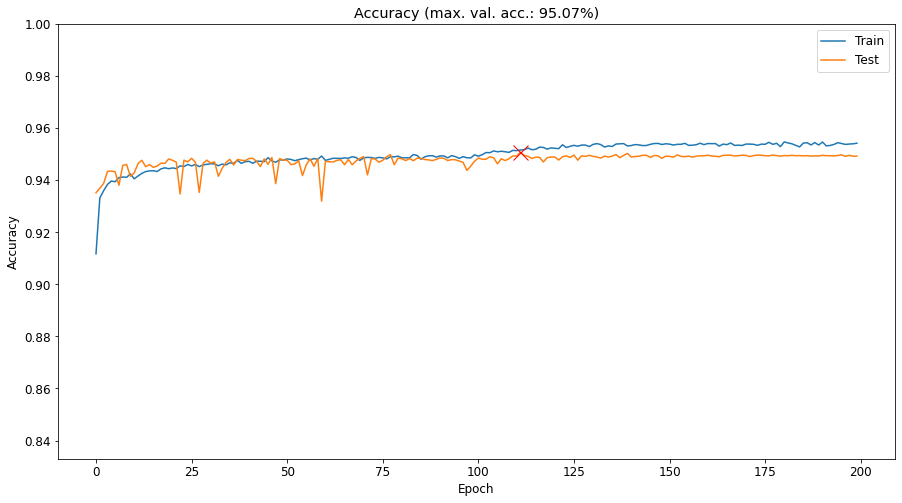

In [0]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_pseudorapidity_inversion_skip_MET_fold4.h5")

### Fold 5/5

In [0]:
args = make_args(name='Pseudorapidity inversion - Fold 5/5 - exp 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                     Pseudorapidity inversion - Fold 5/5 - exp 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [0]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'pseudorapidity_inversion_skip_MET_fold5.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [0]:
# get generators
test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=5)

# perform training
history = model.fit(aug_wrapper(train_generator.flow(), flip_eta=True, skip_first_channel_flip=True), epochs=args.epochs,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_data=val_generator.flow(),
                    validation_steps=val_generator.n // val_generator.batch_size,
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

Selected fold 5/5 with 80000 train samples and 20000 validation samples
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1250 steps, validate for 312 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1248/1250 [============================>.] - ETA: 0s - loss: 0.2303 - acc: 0.9089
Epoch 00001: val_loss improved from inf to 0.20204, saving model to pseudorapidity_inversion_skip_MET_fold5.h5
1250/1250 [==============================] - 15s 12ms/step - loss: 0.2301 - acc: 0.9090 - val_loss: 0.2020 - val_acc: 0.9229

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1248/1250 [============================>.] - ETA: 0s - loss: 0.1728 - acc: 0.9313
Epoch 00002: val_loss improved from 0.20204 to 0.16901, saving model to pseudorapidity_inversion_skip_MET_fold5.h5
1250/1250 [==============================] - 14s 11ms/step - loss: 0.1728 - acc: 0.9313 - val_loss: 0.1690 - val_acc: 0.9339

Epoch 00003: LearningRateSched

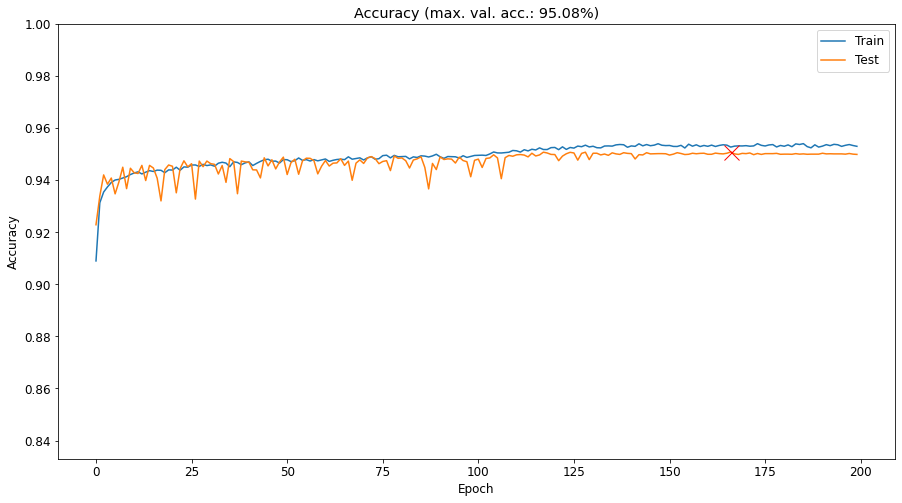

In [0]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_pseudorapidity_inversion_skip_MET_fold5.h5")

## Fip pseudorapidity and azimuth

Selected fold 1/5 with 80000 train samples and 20000 validation samples
Flipping eta. Showing first 3 channels.


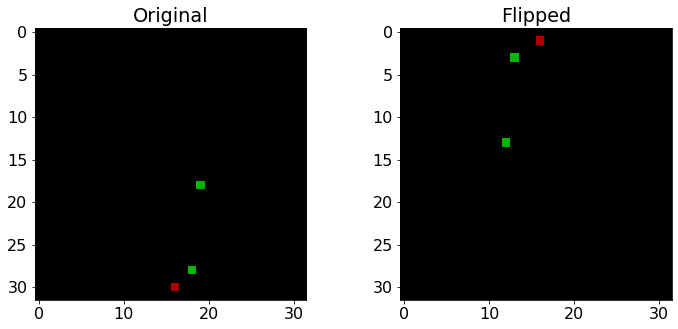

In [23]:
# get generators
test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=1)
# preview
gen = aug_wrapper(train_generator.flow(), flip_eta=True, skip_first_channel_flip=True,
                  jointly_flip_phi=True, verbose=True)
x, y = next(gen)

### Fold 1/5

In [24]:
args = make_args(name='Flip eta & phi - Fold 1/5 - exp 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                               Flip eta & phi - Fold 1/5 - exp 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [25]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'flip_eta_phi_fold1.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [26]:
# get generators
test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=1)

# perform training
history = model.fit(aug_wrapper(train_generator.flow(), flip_eta=True, 
                                skip_first_channel_flip=True, jointly_flip_phi=True), 
                    epochs=args.epochs,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_data=val_generator.flow(),
                    validation_steps=val_generator.n // val_generator.batch_size,
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

Selected fold 1/5 with 80000 train samples and 20000 validation samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1247/1250 [============================>.] - ETA: 0s - loss: 0.2256 - acc: 0.9119
Epoch 00001: val_loss improved from inf to 0.16104, saving model to flip_eta_phi_fold1.h5
1250/1250 [==============================] - 12s 9ms/step - loss: 0.2254 - acc: 0.9120 - val_loss: 0.1610 - val_acc: 0.9370 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1244/1250 [============================>.] - ETA: 0s - loss: 0.1690 - acc: 0.9326
Epoch 00002: val_loss improved from 0.16104 to 0.15313, saving model to flip_eta_phi_fold1.h5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.1689 - acc: 0.9326 - val_loss: 0.1531 - val_acc: 0.9417 - lr: 0.0010

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/200
1247/1250 [============================>.] - ETA: 0s - loss: 0

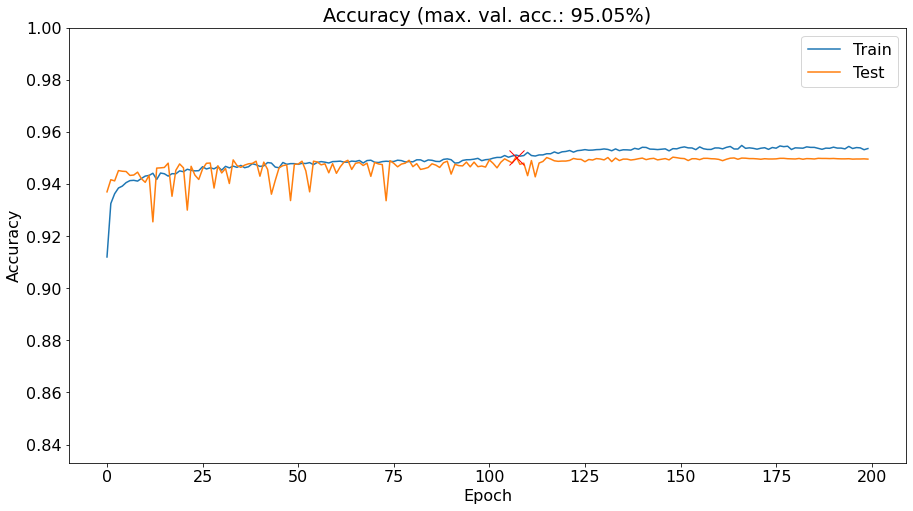

In [27]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_flip_eta_phi_fold1.h5")

### Fold 2/5

In [29]:
args = make_args(name='Flip eta & phi - Fold 2/5 - exp 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                               Flip eta & phi - Fold 2/5 - exp 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [30]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'flip_eta_phi_fold2.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [31]:
# get generators
test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=2)

# perform training
history = model.fit(aug_wrapper(train_generator.flow(), flip_eta=True, 
                                skip_first_channel_flip=True, jointly_flip_phi=True), 
                    epochs=args.epochs,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_data=val_generator.flow(),
                    validation_steps=val_generator.n // val_generator.batch_size,
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

Selected fold 2/5 with 80000 train samples and 20000 validation samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1245/1250 [============================>.] - ETA: 0s - loss: 0.2265 - acc: 0.9093
Epoch 00001: val_loss improved from inf to 0.17870, saving model to flip_eta_phi_fold2.h5
1250/1250 [==============================] - 12s 9ms/step - loss: 0.2263 - acc: 0.9093 - val_loss: 0.1787 - val_acc: 0.9292 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1245/1250 [============================>.] - ETA: 0s - loss: 0.1739 - acc: 0.9312
Epoch 00002: val_loss improved from 0.17870 to 0.15049, saving model to flip_eta_phi_fold2.h5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.1738 - acc: 0.9313 - val_loss: 0.1505 - val_acc: 0.9405 - lr: 0.0010

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.

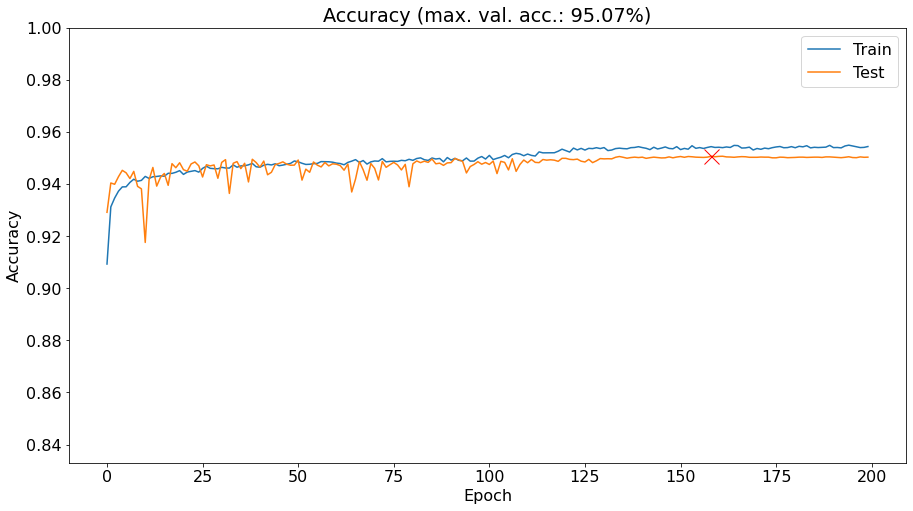

In [32]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_flip_eta_phi_fold2.h5")

### Fold 3/5

In [34]:
args = make_args(name='Flip eta & phi - Fold 3/5 - exp 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                               Flip eta & phi - Fold 3/5 - exp 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [35]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'flip_eta_phi_fold3.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [36]:
# get generators
test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=3)

# perform training
history = model.fit(aug_wrapper(train_generator.flow(), flip_eta=True, 
                                skip_first_channel_flip=True, jointly_flip_phi=True), 
                    epochs=args.epochs,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_data=val_generator.flow(),
                    validation_steps=val_generator.n // val_generator.batch_size,
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

Selected fold 3/5 with 80000 train samples and 20000 validation samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.2285 - acc: 0.9088
Epoch 00001: val_loss improved from inf to 0.16400, saving model to flip_eta_phi_fold3.h5
1250/1250 [==============================] - 12s 9ms/step - loss: 0.2285 - acc: 0.9088 - val_loss: 0.1640 - val_acc: 0.9358 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.1715 - acc: 0.9319
Epoch 00002: val_loss improved from 0.16400 to 0.15524, saving model to flip_eta_phi_fold3.h5
1250/1250 [==============================] - 12s 9ms/step - loss: 0.1715 - acc: 0.9319 - val_loss: 0.1552 - val_acc: 0.9367 - lr: 0.0010

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.

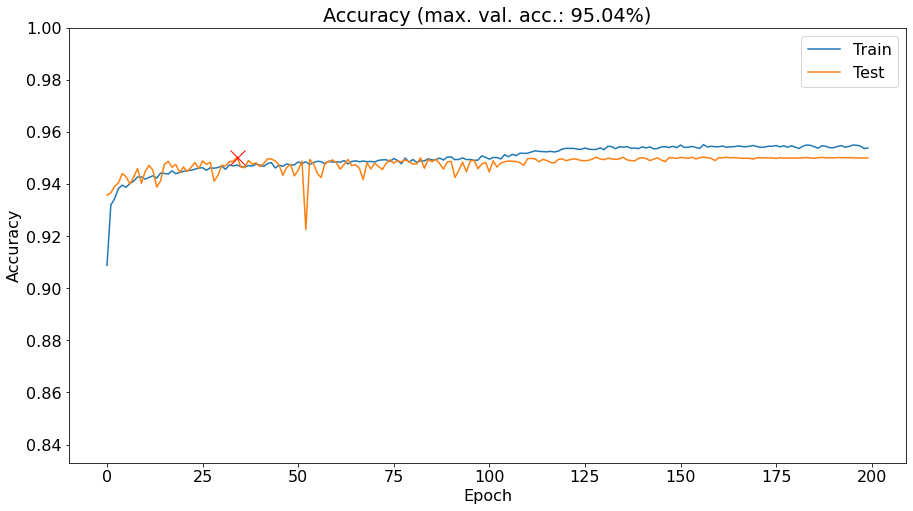

In [37]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_flip_eta_phi_fold3.h5")

### Fold 4/5

In [39]:
args = make_args(name='Flip eta & phi - Fold 4/5 - exp 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                               Flip eta & phi - Fold 4/5 - exp 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [40]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'flip_eta_phi_fold4.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [41]:
# get generators
test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=4)

# perform training
history = model.fit(aug_wrapper(train_generator.flow(), flip_eta=True, 
                                skip_first_channel_flip=True, jointly_flip_phi=True), 
                    epochs=args.epochs,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_data=val_generator.flow(),
                    validation_steps=val_generator.n // val_generator.batch_size,
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

Selected fold 4/5 with 80000 train samples and 20000 validation samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1248/1250 [============================>.] - ETA: 0s - loss: 0.2338 - acc: 0.9070
Epoch 00001: val_loss improved from inf to 0.24909, saving model to flip_eta_phi_fold4.h5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.2337 - acc: 0.9070 - val_loss: 0.2491 - val_acc: 0.8899 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.1769 - acc: 0.9302
Epoch 00002: val_loss improved from 0.24909 to 0.16589, saving model to flip_eta_phi_fold4.h5
1250/1250 [==============================] - 12s 10ms/step - loss: 0.1766 - acc: 0.9304 - val_loss: 0.1659 - val_acc: 0.9329 - lr: 0.0010

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/200
1248/1250 [============================>.] - ETA: 0s - loss: 0

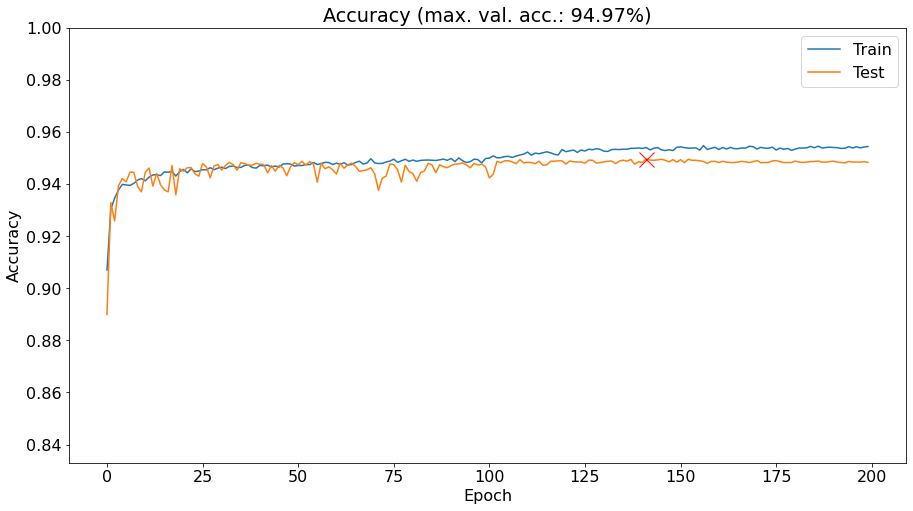

In [42]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_flip_eta_phi_fold4.h5")

### Fold 5/5

In [44]:
args = make_args(name='Flip eta & phi - Fold 5/5 - exp 1e-6', architecture='Conv',
                 activation=LeakyReLU(0.01), final_activation='sigmoid', batch_size=64,
                 epochs=200, verbose=True, wandb_init=True)

# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(64, activation=args.activation))
model.add(layers.Dropout(rate=0.10))
model.add(layers.Dense(1, activation=args.final_activation))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

id                               Flip eta & phi - Fold 5/5 - exp 1e-6
architecture                                                     Conv
loss                                              binary_crossentropy
activation          <tensorflow.python.keras.layers.advanced_activ...
final_activation                                              sigmoid
dropout                                                             0
epochs                                                            200
batch_size                                                         64
lr                                                              0.001
lr_decay                                                            0
optimizer                                                        adam
norm                                                           minmax
trans                                                             log
nodes1                                                            128
nodes2              

In [45]:
lr_scheduler = LearningRateScheduler(
    get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=1)

checkpoint = ModelCheckpoint(MODEL_DIR+'flip_eta_phi_fold5.h5',
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [46]:
# get generators
test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=5)

# perform training
history = model.fit(aug_wrapper(train_generator.flow(), flip_eta=True, 
                                skip_first_channel_flip=True, jointly_flip_phi=True), 
                    epochs=args.epochs,
                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                    validation_data=val_generator.flow(),
                    validation_steps=val_generator.n // val_generator.batch_size,
                    callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=1)

Selected fold 5/5 with 80000 train samples and 20000 validation samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/200
1244/1250 [============================>.] - ETA: 0s - loss: 0.2290 - acc: 0.9094
Epoch 00001: val_loss improved from inf to 0.18394, saving model to flip_eta_phi_fold5.h5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.2290 - acc: 0.9094 - val_loss: 0.1839 - val_acc: 0.9255 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/200
1245/1250 [============================>.] - ETA: 0s - loss: 0.1714 - acc: 0.9319
Epoch 00002: val_loss improved from 0.18394 to 0.15755, saving model to flip_eta_phi_fold5.h5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.1713 - acc: 0.9319 - val_loss: 0.1576 - val_acc: 0.9370 - lr: 0.0010

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/200
1246/1250 [============================>.] - ETA: 0s - loss: 0.

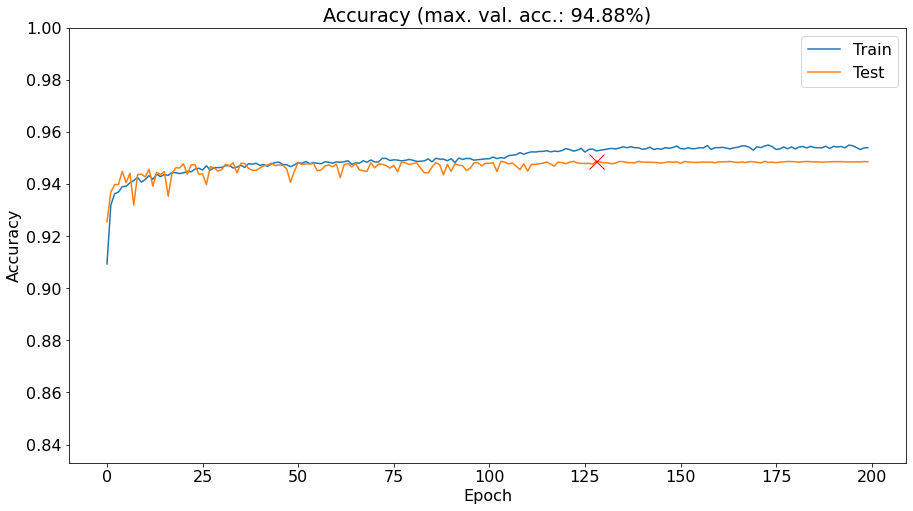

In [47]:
plot_history(history, limits=True)

In [0]:
model.save(MODEL_DIR+"final_weights_flip_eta_phi_fold5.h5")

# Part 8: test-CV on ensemble performance
Proper evaluation of the ensemble accuracy involves training the models for each of the six test folds, with five validation folds each. With 40 min each, this takes about $6\cdot 5 \cdot 40 / 60 = 20$ hours. With the new implementation of the generators, these runs can be queued without memory issues.  

For this block, the initialization cells at the start, `angles_to_15_channel_images_with_energy_and_momentum`, `create_all_images` and the definition of `DataGenerator` and `GeneralGenerator` is required.

## Train models

Performing 5-fold cross-validation with 16667 test samples
=============== STARTING TEST FOLD 2/6, ENSEMBLE FOLD 4/5 ===============
Selected fold 4/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.16649, saving model to results/ensemble_test/ensemble_test2_fold4.h5

Epoch 00002: val_loss improved from 0.16649 to 0.15106, saving model to results/ensemble_test/ensemble_test2_fold4.h5

Epoch 00003: val_loss improved from 0.15106 to 0.14548, saving model to results/ensemble_test/ensemble_test2_fold4.h5

Epoch 00004: val_loss improved from 0.14548 to 0.13909, saving model to results/ensemble_test/ensemble_test2_fold4.h5

Epoch 00005: val_loss did not improve from 0.13909

Epoch 00006: val_loss improved from 0.13909 to 0.13380, saving model to results/ensemble_test/ensemble_test2_fold4.h5

Epoch 00007: val_loss did not improve from 0.13380

Epoch 00008: val_loss did not improve from 0.13380

Epoch 00009: val_loss did not improve from 0.13380

Epoch 00010: val_loss did not improve from 0.13380

Epoch 00011: val_loss improved from 0.13380 to 0.13063, saving model to results/ensemble_test/ense

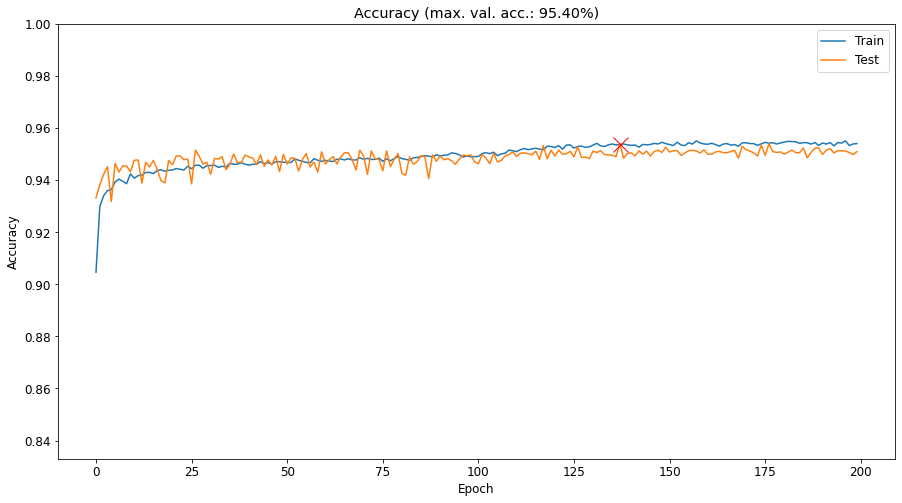

=============== STARTING TEST FOLD 2/6, ENSEMBLE FOLD 5/5 ===============
Selected fold 5/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.16304, saving model to results/ensemble_test/ensemble_test2_fold5.h5

Epoch 00002: val_loss did not improve from 0.16304

Epoch 00003: val_loss improved from 0.16304 to 0.14546, saving model to results/ensemble_test/ensemble_test2_fold5.h5

Epoch 00004: val_loss improved from 0.14546 to 0.13833, saving model to results/ensemble_test/ensemble_test2_fold5.h5

Epoch 00005: val_loss improved from 0.13833 to 0.13632, saving model to results/ensemble_test/ensemble_test2_fold5.h5

Epoch 00006: val_loss did not improve from 0.13632

Epoch 00007: val_loss improved from 0.13632 to 0.13587, saving model to results/ensemble_test/ensemble_test2_fold5.h5

Epoch 00008: val_loss did not improve from 0.13587

Epoch 00009: val_loss did not improve from 0.13587

Epoch 00010: val_loss did not improve from 0.13587

Epoch 00011: val_loss improved from 0.13587 to 0.13439, saving model to results/ensemble_test/ense

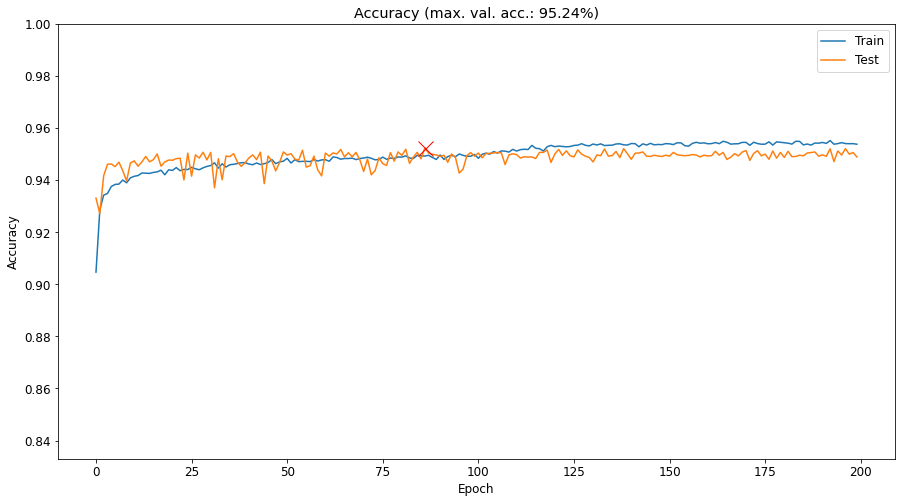

Performing 5-fold cross-validation with 16667 test samples
=============== STARTING TEST FOLD 3/6, ENSEMBLE FOLD 1/5 ===============
Selected fold 1/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.16117, saving model to results/ensemble_test/ensemble_test3_fold1.h5

Epoch 00002: val_loss improved from 0.16117 to 0.14750, saving model to results/ensemble_test/ensemble_test3_fold1.h5

Epoch 00003: val_loss improved from 0.14750 to 0.13978, saving model to results/ensemble_test/ensemble_test3_fold1.h5

Epoch 00004: val_loss did not improve from 0.13978

Epoch 00005: val_loss did not improve from 0.13978

Epoch 00006: val_loss did not improve from 0.13978

Epoch 00007: val_loss did not improve from 0.13978

Epoch 00008: val_loss did not improve from 0.13978

Epoch 00009: val_loss did not improve from 0.13978

Epoch 00010: val_loss improved from 0.13978 to 0.13145, saving model to results/ensemble_test/ensemble_test3_fold1.h5

Epoch 00011: val_loss did not improve from 0.13145

Epoch 00012: val_loss did not improve from 0.13145

Epoch 00013: val_loss did not improve from 0.13145

Epoch 000

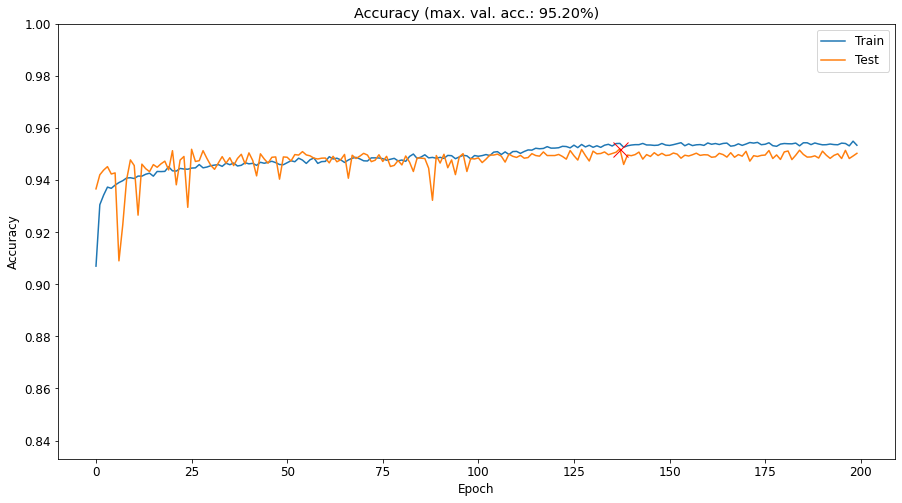

=============== STARTING TEST FOLD 3/6, ENSEMBLE FOLD 2/5 ===============
Selected fold 2/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.17313, saving model to results/ensemble_test/ensemble_test3_fold2.h5

Epoch 00002: val_loss improved from 0.17313 to 0.14670, saving model to results/ensemble_test/ensemble_test3_fold2.h5

Epoch 00003: val_loss did not improve from 0.14670

Epoch 00004: val_loss improved from 0.14670 to 0.14351, saving model to results/ensemble_test/ensemble_test3_fold2.h5

Epoch 00005: val_loss improved from 0.14351 to 0.13740, saving model to results/ensemble_test/ensemble_test3_fold2.h5

Epoch 00006: val_loss did not improve from 0.13740

Epoch 00007: val_loss did not improve from 0.13740

Epoch 00008: val_loss did not improve from 0.13740

Epoch 00009: val_loss improved from 0.13740 to 0.12667, saving model to results/ensemble_test/ensemble_test3_fold2.h5

Epoch 00010: val_loss did not improve from 0.12667

Epoch 00011: val_loss did not improve from 0.12667

Epoch 00012: val_loss did not improve from 0.1

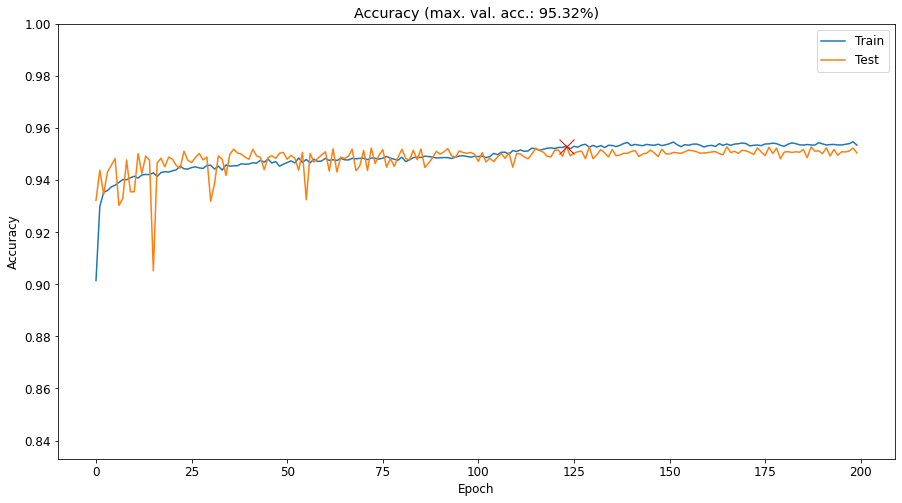

=============== STARTING TEST FOLD 3/6, ENSEMBLE FOLD 3/5 ===============
Selected fold 3/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.16618, saving model to results/ensemble_test/ensemble_test3_fold3.h5

Epoch 00002: val_loss did not improve from 0.16618

Epoch 00003: val_loss improved from 0.16618 to 0.14283, saving model to results/ensemble_test/ensemble_test3_fold3.h5

Epoch 00004: val_loss did not improve from 0.14283

Epoch 00005: val_loss improved from 0.14283 to 0.13459, saving model to results/ensemble_test/ensemble_test3_fold3.h5

Epoch 00006: val_loss did not improve from 0.13459

Epoch 00007: val_loss did not improve from 0.13459

Epoch 00008: val_loss did not improve from 0.13459

Epoch 00009: val_loss did not improve from 0.13459

Epoch 00010: val_loss did not improve from 0.13459

Epoch 00011: val_loss did not improve from 0.13459

Epoch 00012: val_loss did not improve from 0.13459

Epoch 00013: val_loss improved from 0.13459 to 0.13327, saving model to results/ensemble_test/ensemble_test3_fold3.h5

Epoch 000

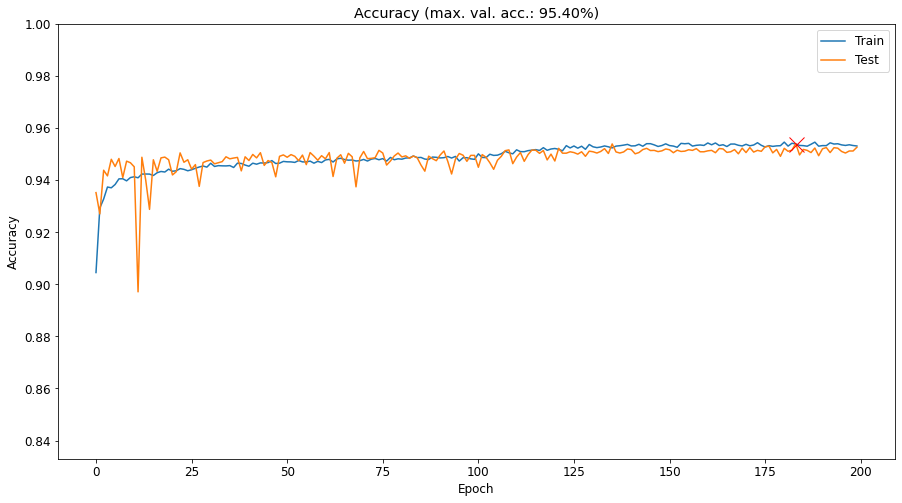

=============== STARTING TEST FOLD 3/6, ENSEMBLE FOLD 4/5 ===============
Selected fold 4/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.17006, saving model to results/ensemble_test/ensemble_test3_fold4.h5

Epoch 00002: val_loss improved from 0.17006 to 0.14630, saving model to results/ensemble_test/ensemble_test3_fold4.h5

Epoch 00003: val_loss improved from 0.14630 to 0.14587, saving model to results/ensemble_test/ensemble_test3_fold4.h5

Epoch 00004: val_loss improved from 0.14587 to 0.13724, saving model to results/ensemble_test/ensemble_test3_fold4.h5

Epoch 00005: val_loss improved from 0.13724 to 0.13710, saving model to results/ensemble_test/ensemble_test3_fold4.h5

Epoch 00006: val_loss did not improve from 0.13710

Epoch 00007: val_loss did not improve from 0.13710

Epoch 00008: val_loss did not improve from 0.13710

Epoch 00009: val_loss improved from 0.13710 to 0.13132, saving model to results/ensemble_test/ensemble_test3_fold4.h5

Epoch 00010: val_loss did not improve from 0.13132

Epoch 00011: val_loss improved 

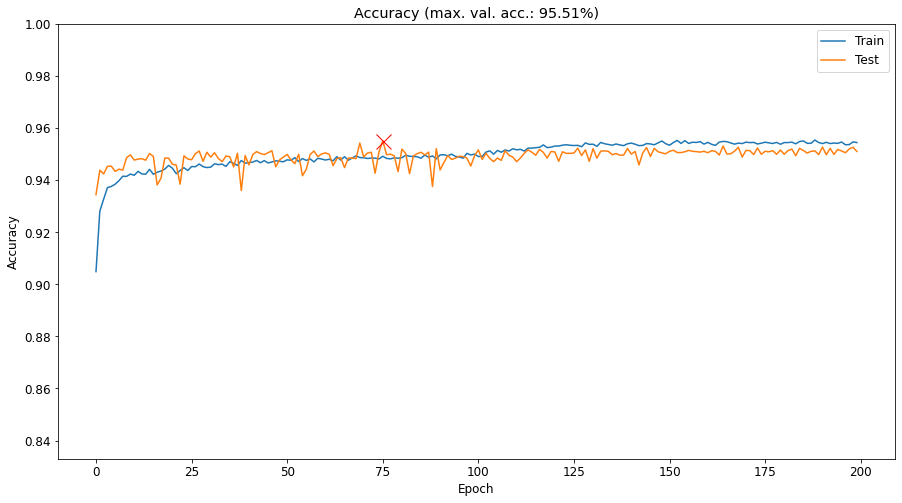

=============== STARTING TEST FOLD 3/6, ENSEMBLE FOLD 5/5 ===============
Selected fold 5/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.17628, saving model to results/ensemble_test/ensemble_test3_fold5.h5

Epoch 00002: val_loss improved from 0.17628 to 0.14566, saving model to results/ensemble_test/ensemble_test3_fold5.h5

Epoch 00003: val_loss improved from 0.14566 to 0.14413, saving model to results/ensemble_test/ensemble_test3_fold5.h5

Epoch 00004: val_loss improved from 0.14413 to 0.13761, saving model to results/ensemble_test/ensemble_test3_fold5.h5

Epoch 00005: val_loss improved from 0.13761 to 0.13304, saving model to results/ensemble_test/ensemble_test3_fold5.h5

Epoch 00006: val_loss did not improve from 0.13304

Epoch 00007: val_loss improved from 0.13304 to 0.13179, saving model to results/ensemble_test/ensemble_test3_fold5.h5

Epoch 00008: val_loss did not improve from 0.13179

Epoch 00009: val_loss improved from 0.13179 to 0.12974, saving model to results/ensemble_test/ensemble_test3_fold5.h5

Epoch 00010: val

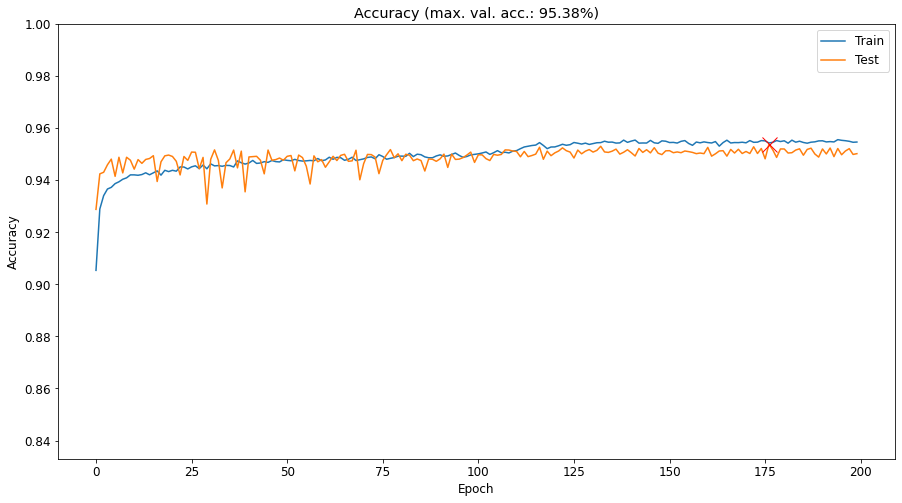

Performing 5-fold cross-validation with 16667 test samples
=============== STARTING TEST FOLD 4/6, ENSEMBLE FOLD 1/5 ===============
Selected fold 1/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.16964, saving model to results/ensemble_test/ensemble_test4_fold1.h5

Epoch 00002: val_loss improved from 0.16964 to 0.14888, saving model to results/ensemble_test/ensemble_test4_fold1.h5

Epoch 00003: val_loss improved from 0.14888 to 0.14242, saving model to results/ensemble_test/ensemble_test4_fold1.h5

Epoch 00004: val_loss improved from 0.14242 to 0.13884, saving model to results/ensemble_test/ensemble_test4_fold1.h5

Epoch 00005: val_loss did not improve from 0.13884

Epoch 00006: val_loss improved from 0.13884 to 0.13468, saving model to results/ensemble_test/ensemble_test4_fold1.h5

Epoch 00007: val_loss did not improve from 0.13468

Epoch 00008: val_loss did not improve from 0.13468

Epoch 00009: val_loss improved from 0.13468 to 0.13387, saving model to results/ensemble_test/ensemble_test4_fold1.h5

Epoch 00010: val_loss improved from 0.13387 to 0.12936, saving model to results/ens

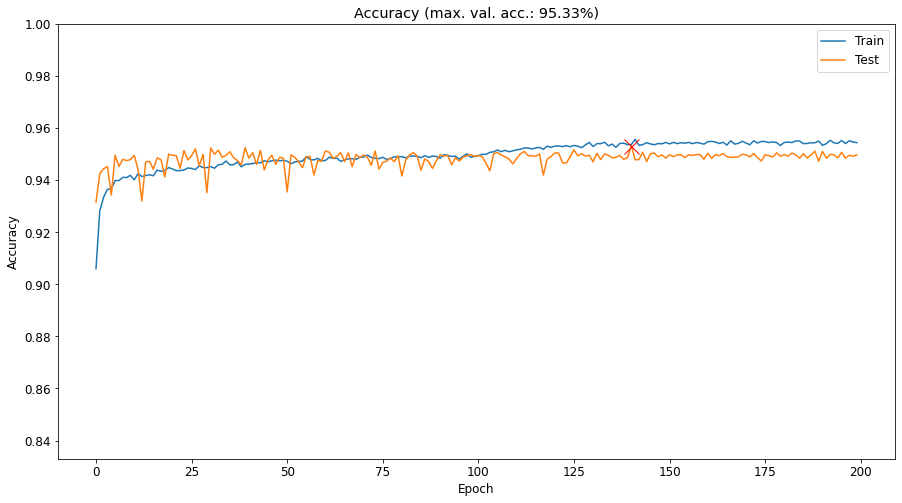

=============== STARTING TEST FOLD 4/6, ENSEMBLE FOLD 2/5 ===============
Selected fold 2/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.25579, saving model to results/ensemble_test/ensemble_test4_fold2.h5

Epoch 00002: val_loss improved from 0.25579 to 0.14402, saving model to results/ensemble_test/ensemble_test4_fold2.h5

Epoch 00003: val_loss did not improve from 0.14402

Epoch 00004: val_loss improved from 0.14402 to 0.14314, saving model to results/ensemble_test/ensemble_test4_fold2.h5

Epoch 00005: val_loss improved from 0.14314 to 0.13336, saving model to results/ensemble_test/ensemble_test4_fold2.h5

Epoch 00006: val_loss did not improve from 0.13336

Epoch 00007: val_loss did not improve from 0.13336

Epoch 00008: val_loss did not improve from 0.13336

Epoch 00009: val_loss improved from 0.13336 to 0.13193, saving model to results/ensemble_test/ensemble_test4_fold2.h5

Epoch 00010: val_loss did not improve from 0.13193

Epoch 00011: val_loss did not improve from 0.13193

Epoch 00012: val_loss improved from 0.13193 to

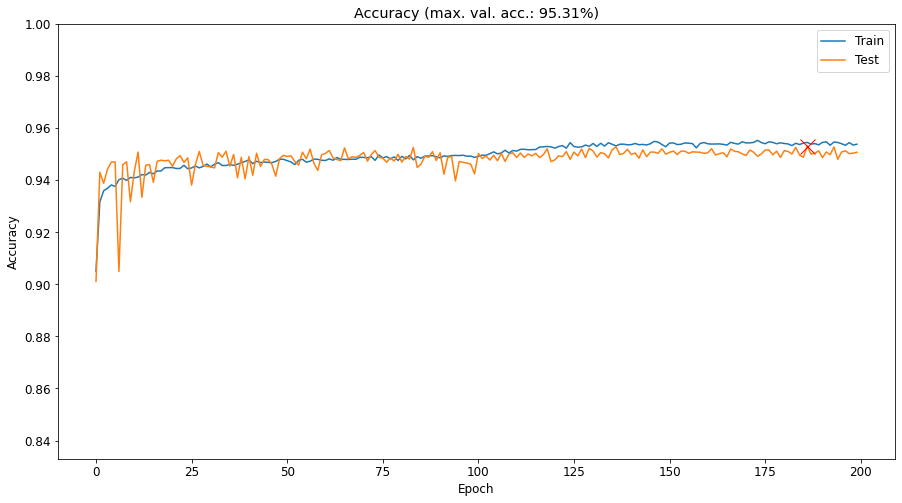

=============== STARTING TEST FOLD 4/6, ENSEMBLE FOLD 3/5 ===============
Selected fold 3/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.18760, saving model to results/ensemble_test/ensemble_test4_fold3.h5

Epoch 00002: val_loss improved from 0.18760 to 0.14511, saving model to results/ensemble_test/ensemble_test4_fold3.h5

Epoch 00003: val_loss did not improve from 0.14511

Epoch 00004: val_loss did not improve from 0.14511

Epoch 00005: val_loss did not improve from 0.14511

Epoch 00006: val_loss improved from 0.14511 to 0.13479, saving model to results/ensemble_test/ensemble_test4_fold3.h5

Epoch 00007: val_loss did not improve from 0.13479

Epoch 00008: val_loss improved from 0.13479 to 0.13121, saving model to results/ensemble_test/ensemble_test4_fold3.h5

Epoch 00009: val_loss did not improve from 0.13121

Epoch 00010: val_loss did not improve from 0.13121

Epoch 00011: val_loss did not improve from 0.13121

Epoch 00012: val_loss did not improve from 0.13121

Epoch 00013: val_loss did not improve from 0.13121

Epoch 000

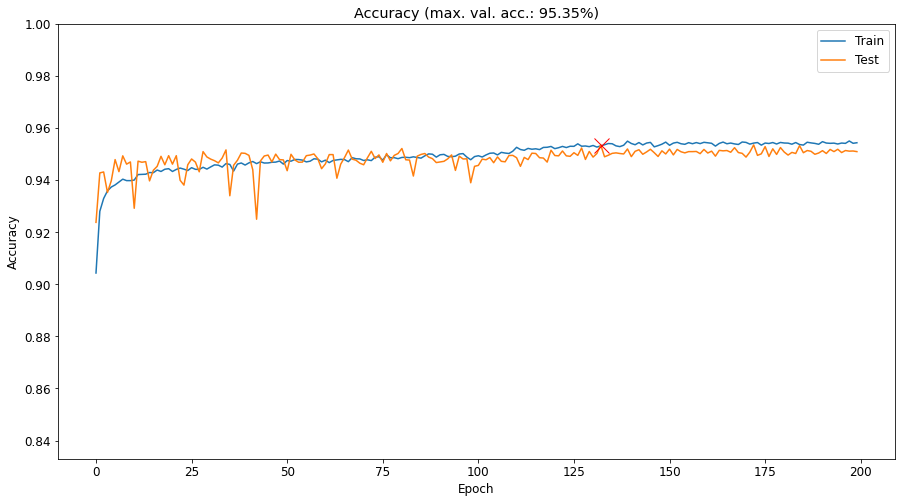

=============== STARTING TEST FOLD 4/6, ENSEMBLE FOLD 4/5 ===============
Selected fold 4/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.17105, saving model to results/ensemble_test/ensemble_test4_fold4.h5

Epoch 00002: val_loss did not improve from 0.17105

Epoch 00003: val_loss improved from 0.17105 to 0.15315, saving model to results/ensemble_test/ensemble_test4_fold4.h5

Epoch 00004: val_loss improved from 0.15315 to 0.14138, saving model to results/ensemble_test/ensemble_test4_fold4.h5

Epoch 00005: val_loss improved from 0.14138 to 0.13152, saving model to results/ensemble_test/ensemble_test4_fold4.h5

Epoch 00006: val_loss did not improve from 0.13152

Epoch 00007: val_loss improved from 0.13152 to 0.13123, saving model to results/ensemble_test/ensemble_test4_fold4.h5

Epoch 00008: val_loss did not improve from 0.13123

Epoch 00009: val_loss did not improve from 0.13123

Epoch 00010: val_loss did not improve from 0.13123

Epoch 00011: val_loss did not improve from 0.13123

Epoch 00012: val_loss did not improve from 0.1

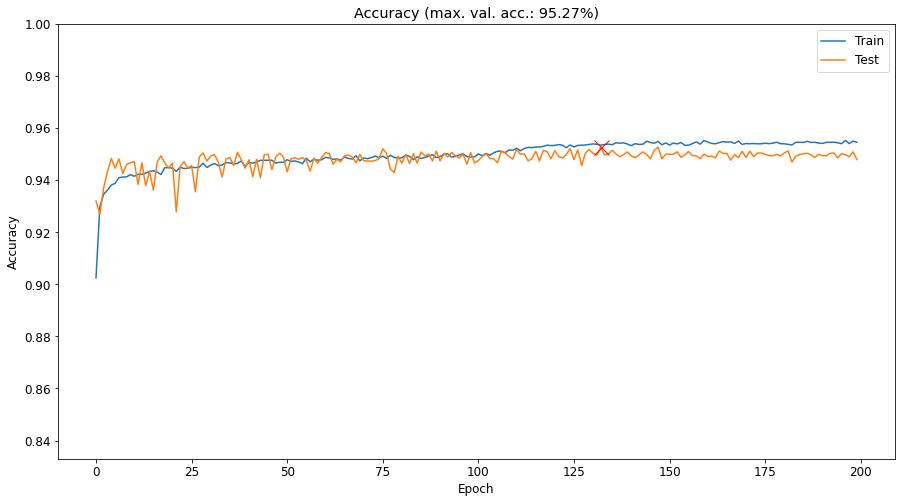

=============== STARTING TEST FOLD 4/6, ENSEMBLE FOLD 5/5 ===============
Selected fold 5/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.16575, saving model to results/ensemble_test/ensemble_test4_fold5.h5

Epoch 00002: val_loss improved from 0.16575 to 0.15232, saving model to results/ensemble_test/ensemble_test4_fold5.h5

Epoch 00003: val_loss improved from 0.15232 to 0.14674, saving model to results/ensemble_test/ensemble_test4_fold5.h5

Epoch 00004: val_loss did not improve from 0.14674

Epoch 00005: val_loss improved from 0.14674 to 0.14028, saving model to results/ensemble_test/ensemble_test4_fold5.h5

Epoch 00006: val_loss did not improve from 0.14028

Epoch 00007: val_loss improved from 0.14028 to 0.13933, saving model to results/ensemble_test/ensemble_test4_fold5.h5

Epoch 00008: val_loss did not improve from 0.13933

Epoch 00009: val_loss did not improve from 0.13933

Epoch 00010: val_loss improved from 0.13933 to 0.13533, saving model to results/ensemble_test/ensemble_test4_fold5.h5

Epoch 00011: val_loss did not i

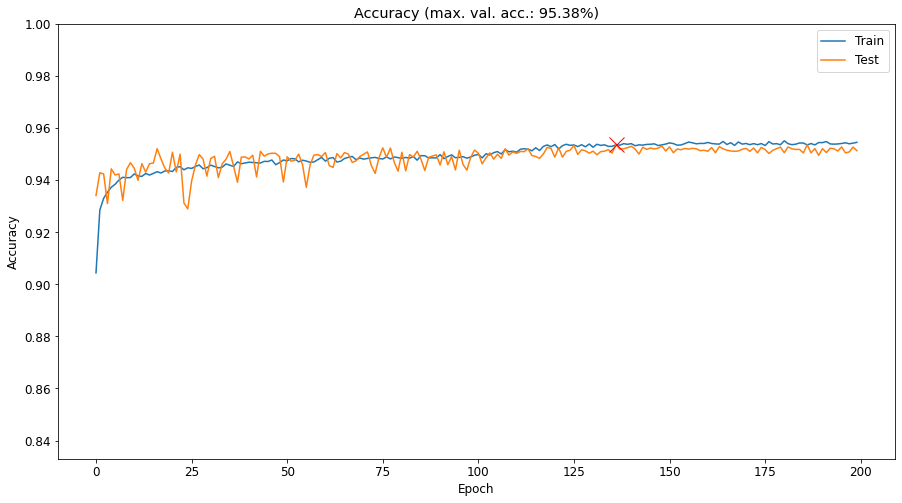

Performing 5-fold cross-validation with 16667 test samples
=============== STARTING TEST FOLD 5/6, ENSEMBLE FOLD 1/5 ===============
Selected fold 1/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.17728, saving model to results/ensemble_test/ensemble_test5_fold1.h5

Epoch 00002: val_loss improved from 0.17728 to 0.15588, saving model to results/ensemble_test/ensemble_test5_fold1.h5

Epoch 00003: val_loss improved from 0.15588 to 0.15161, saving model to results/ensemble_test/ensemble_test5_fold1.h5

Epoch 00004: val_loss improved from 0.15161 to 0.13818, saving model to results/ensemble_test/ensemble_test5_fold1.h5

Epoch 00005: val_loss did not improve from 0.13818

Epoch 00006: val_loss improved from 0.13818 to 0.13241, saving model to results/ensemble_test/ensemble_test5_fold1.h5

Epoch 00007: val_loss did not improve from 0.13241

Epoch 00008: val_loss did not improve from 0.13241

Epoch 00009: val_loss improved from 0.13241 to 0.13182, saving model to results/ensemble_test/ensemble_test5_fold1.h5

Epoch 00010: val_loss did not improve from 0.13182

Epoch 00011: val_loss did not i

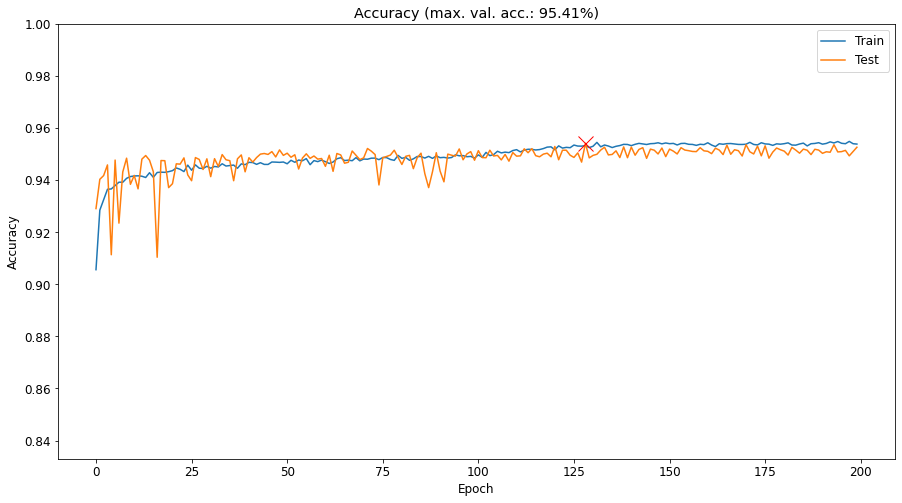

=============== STARTING TEST FOLD 5/6, ENSEMBLE FOLD 2/5 ===============
Selected fold 2/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.17717, saving model to results/ensemble_test/ensemble_test5_fold2.h5

Epoch 00002: val_loss improved from 0.17717 to 0.15149, saving model to results/ensemble_test/ensemble_test5_fold2.h5

Epoch 00003: val_loss improved from 0.15149 to 0.14669, saving model to results/ensemble_test/ensemble_test5_fold2.h5

Epoch 00004: val_loss improved from 0.14669 to 0.13825, saving model to results/ensemble_test/ensemble_test5_fold2.h5

Epoch 00005: val_loss did not improve from 0.13825

Epoch 00006: val_loss improved from 0.13825 to 0.13597, saving model to results/ensemble_test/ensemble_test5_fold2.h5

Epoch 00007: val_loss improved from 0.13597 to 0.13364, saving model to results/ensemble_test/ensemble_test5_fold2.h5

Epoch 00008: val_loss improved from 0.13364 to 0.13360, saving model to results/ensemble_test/ensemble_test5_fold2.h5

Epoch 00009: val_loss did not improve from 0.13360

Epoch 00010: val

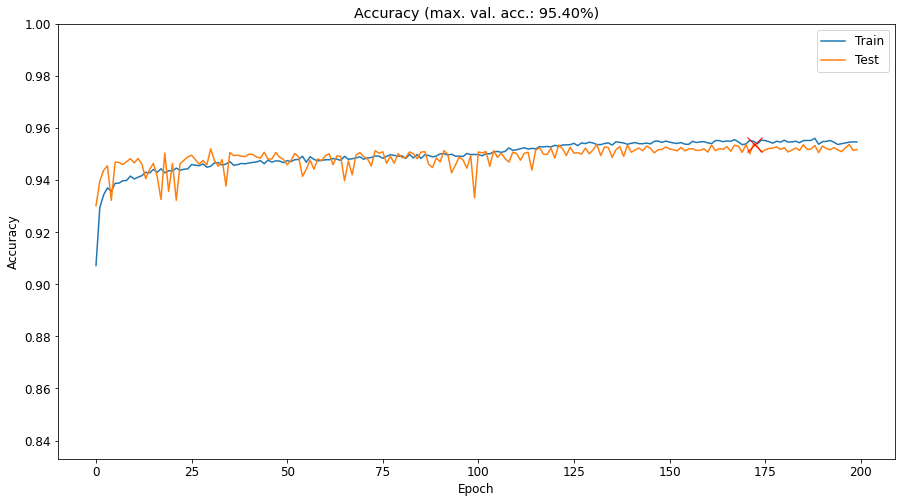

=============== STARTING TEST FOLD 5/6, ENSEMBLE FOLD 3/5 ===============
Selected fold 3/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.19587, saving model to results/ensemble_test/ensemble_test5_fold3.h5

Epoch 00002: val_loss improved from 0.19587 to 0.14990, saving model to results/ensemble_test/ensemble_test5_fold3.h5

Epoch 00003: val_loss improved from 0.14990 to 0.13907, saving model to results/ensemble_test/ensemble_test5_fold3.h5

Epoch 00004: val_loss did not improve from 0.13907

Epoch 00005: val_loss did not improve from 0.13907

Epoch 00006: val_loss improved from 0.13907 to 0.13393, saving model to results/ensemble_test/ensemble_test5_fold3.h5

Epoch 00007: val_loss improved from 0.13393 to 0.12838, saving model to results/ensemble_test/ensemble_test5_fold3.h5

Epoch 00008: val_loss did not improve from 0.12838

Epoch 00009: val_loss did not improve from 0.12838

Epoch 00010: val_loss did not improve from 0.12838

Epoch 00011: val_loss did not improve from 0.12838

Epoch 00012: val_loss did not improve from 0.1

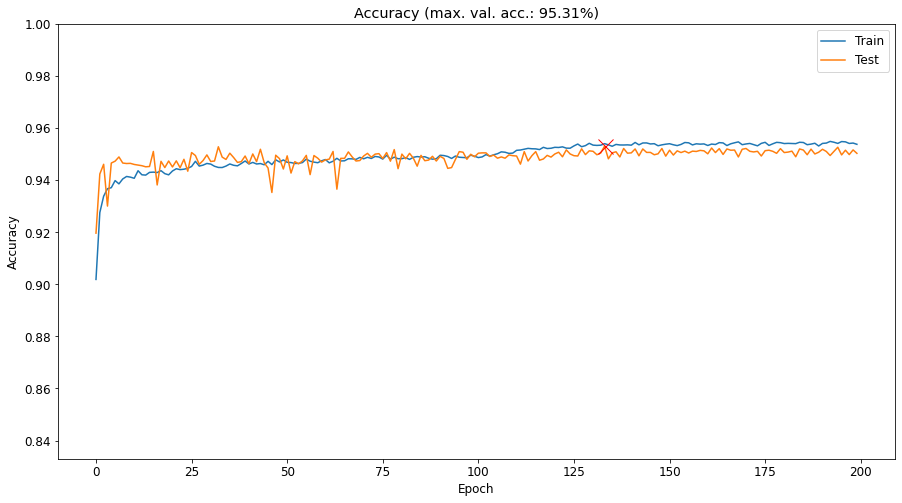

=============== STARTING TEST FOLD 5/6, ENSEMBLE FOLD 4/5 ===============
Selected fold 4/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.16536, saving model to results/ensemble_test/ensemble_test5_fold4.h5

Epoch 00002: val_loss did not improve from 0.16536

Epoch 00003: val_loss did not improve from 0.16536

Epoch 00004: val_loss improved from 0.16536 to 0.13672, saving model to results/ensemble_test/ensemble_test5_fold4.h5

Epoch 00005: val_loss did not improve from 0.13672

Epoch 00006: val_loss did not improve from 0.13672

Epoch 00007: val_loss did not improve from 0.13672

Epoch 00008: val_loss did not improve from 0.13672

Epoch 00009: val_loss did not improve from 0.13672

Epoch 00010: val_loss improved from 0.13672 to 0.12958, saving model to results/ensemble_test/ensemble_test5_fold4.h5

Epoch 00011: val_loss did not improve from 0.12958

Epoch 00012: val_loss improved from 0.12958 to 0.12764, saving model to results/ensemble_test/ensemble_test5_fold4.h5

Epoch 00013: val_loss did not improve from 0.12764

Epoch 000

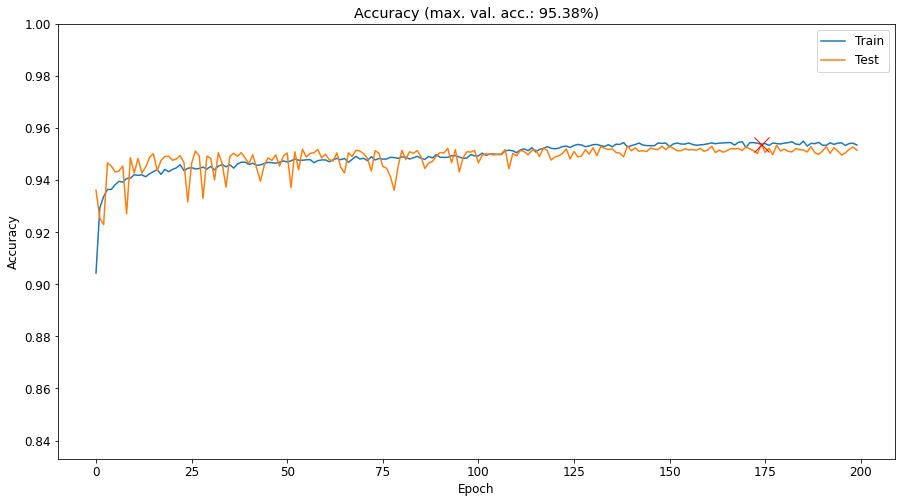

=============== STARTING TEST FOLD 5/6, ENSEMBLE FOLD 5/5 ===============
Selected fold 5/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.16670, saving model to results/ensemble_test/ensemble_test5_fold5.h5

Epoch 00002: val_loss improved from 0.16670 to 0.16219, saving model to results/ensemble_test/ensemble_test5_fold5.h5

Epoch 00003: val_loss improved from 0.16219 to 0.13975, saving model to results/ensemble_test/ensemble_test5_fold5.h5

Epoch 00004: val_loss did not improve from 0.13975

Epoch 00005: val_loss did not improve from 0.13975

Epoch 00006: val_loss did not improve from 0.13975

Epoch 00007: val_loss improved from 0.13975 to 0.13335, saving model to results/ensemble_test/ensemble_test5_fold5.h5

Epoch 00008: val_loss did not improve from 0.13335

Epoch 00009: val_loss did not improve from 0.13335

Epoch 00010: val_loss did not improve from 0.13335

Epoch 00011: val_loss did not improve from 0.13335

Epoch 00012: val_loss did not improve from 0.13335

Epoch 00013: val_loss did not improve from 0.13335

Epoch 000

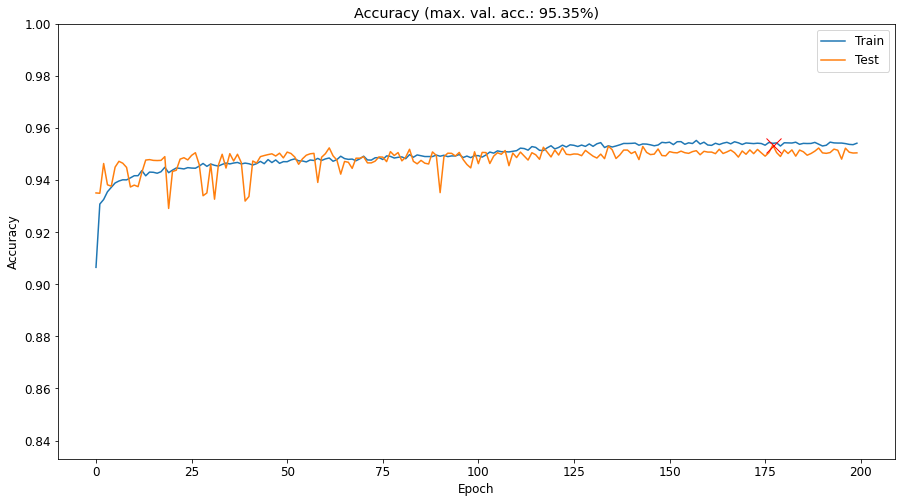

Performing 5-fold cross-validation with 16667 test samples
=============== STARTING TEST FOLD 6/6, ENSEMBLE FOLD 1/5 ===============
Selected fold 1/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.16641, saving model to results/ensemble_test/ensemble_test6_fold1.h5

Epoch 00002: val_loss did not improve from 0.16641

Epoch 00003: val_loss improved from 0.16641 to 0.14704, saving model to results/ensemble_test/ensemble_test6_fold1.h5

Epoch 00004: val_loss did not improve from 0.14704

Epoch 00005: val_loss did not improve from 0.14704

Epoch 00006: val_loss improved from 0.14704 to 0.14093, saving model to results/ensemble_test/ensemble_test6_fold1.h5

Epoch 00007: val_loss did not improve from 0.14093

Epoch 00008: val_loss improved from 0.14093 to 0.13316, saving model to results/ensemble_test/ensemble_test6_fold1.h5

Epoch 00009: val_loss did not improve from 0.13316

Epoch 00010: val_loss improved from 0.13316 to 0.13311, saving model to results/ensemble_test/ensemble_test6_fold1.h5

Epoch 00011: val_loss did not improve from 0.13311

Epoch 00012: val_loss did not improve from 0.1

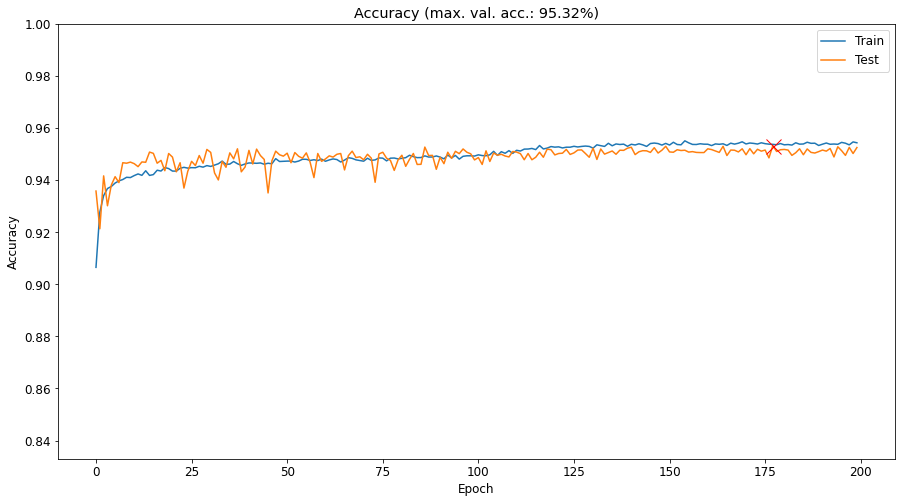

=============== STARTING TEST FOLD 6/6, ENSEMBLE FOLD 2/5 ===============
Selected fold 2/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.16467, saving model to results/ensemble_test/ensemble_test6_fold2.h5

Epoch 00002: val_loss improved from 0.16467 to 0.15816, saving model to results/ensemble_test/ensemble_test6_fold2.h5

Epoch 00003: val_loss improved from 0.15816 to 0.14402, saving model to results/ensemble_test/ensemble_test6_fold2.h5

Epoch 00004: val_loss improved from 0.14402 to 0.14218, saving model to results/ensemble_test/ensemble_test6_fold2.h5

Epoch 00005: val_loss did not improve from 0.14218

Epoch 00006: val_loss improved from 0.14218 to 0.13590, saving model to results/ensemble_test/ensemble_test6_fold2.h5

Epoch 00007: val_loss did not improve from 0.13590

Epoch 00008: val_loss improved from 0.13590 to 0.13042, saving model to results/ensemble_test/ensemble_test6_fold2.h5

Epoch 00009: val_loss did not improve from 0.13042

Epoch 00010: val_loss did not improve from 0.13042

Epoch 00011: val_loss did not i

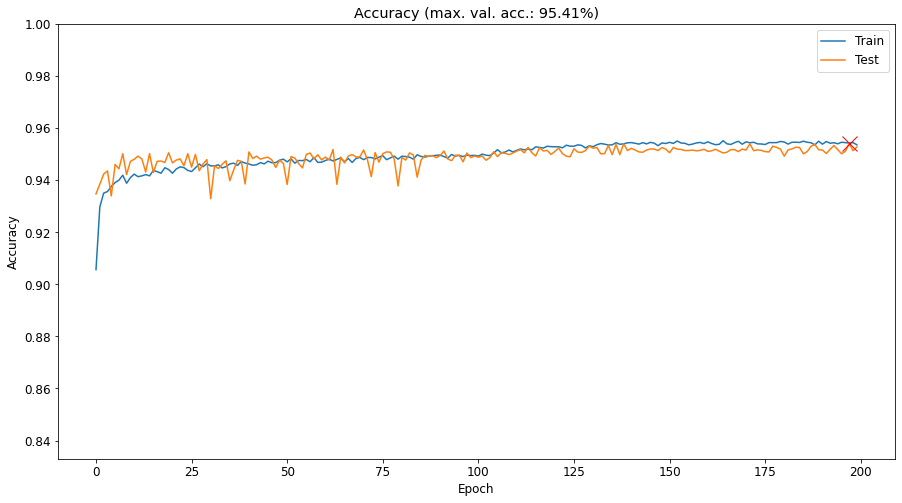

=============== STARTING TEST FOLD 6/6, ENSEMBLE FOLD 3/5 ===============
Selected fold 3/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.18364, saving model to results/ensemble_test/ensemble_test6_fold3.h5

Epoch 00002: val_loss improved from 0.18364 to 0.16367, saving model to results/ensemble_test/ensemble_test6_fold3.h5

Epoch 00003: val_loss did not improve from 0.16367

Epoch 00004: val_loss improved from 0.16367 to 0.13925, saving model to results/ensemble_test/ensemble_test6_fold3.h5

Epoch 00005: val_loss did not improve from 0.13925

Epoch 00006: val_loss improved from 0.13925 to 0.13651, saving model to results/ensemble_test/ensemble_test6_fold3.h5

Epoch 00007: val_loss improved from 0.13651 to 0.13576, saving model to results/ensemble_test/ensemble_test6_fold3.h5

Epoch 00008: val_loss improved from 0.13576 to 0.13559, saving model to results/ensemble_test/ensemble_test6_fold3.h5

Epoch 00009: val_loss improved from 0.13559 to 0.13256, saving model to results/ensemble_test/ensemble_test6_fold3.h5

Epoch 00010: val

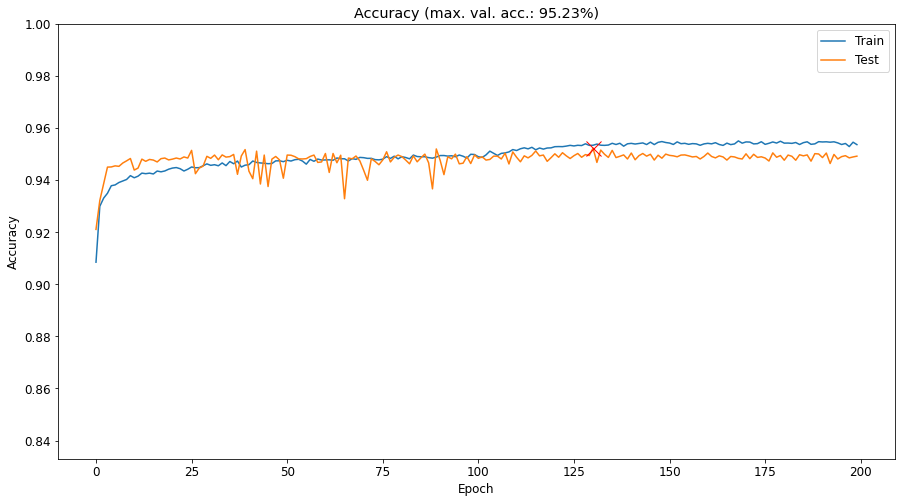

=============== STARTING TEST FOLD 6/6, ENSEMBLE FOLD 4/5 ===============
Selected fold 4/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.16998, saving model to results/ensemble_test/ensemble_test6_fold4.h5

Epoch 00002: val_loss improved from 0.16998 to 0.15096, saving model to results/ensemble_test/ensemble_test6_fold4.h5

Epoch 00003: val_loss did not improve from 0.15096

Epoch 00004: val_loss did not improve from 0.15096

Epoch 00005: val_loss improved from 0.15096 to 0.14278, saving model to results/ensemble_test/ensemble_test6_fold4.h5

Epoch 00006: val_loss did not improve from 0.14278

Epoch 00007: val_loss did not improve from 0.14278

Epoch 00008: val_loss did not improve from 0.14278

Epoch 00009: val_loss improved from 0.14278 to 0.13995, saving model to results/ensemble_test/ensemble_test6_fold4.h5

Epoch 00010: val_loss did not improve from 0.13995

Epoch 00011: val_loss improved from 0.13995 to 0.13828, saving model to results/ensemble_test/ensemble_test6_fold4.h5

Epoch 00012: val_loss did not improve from 0.1

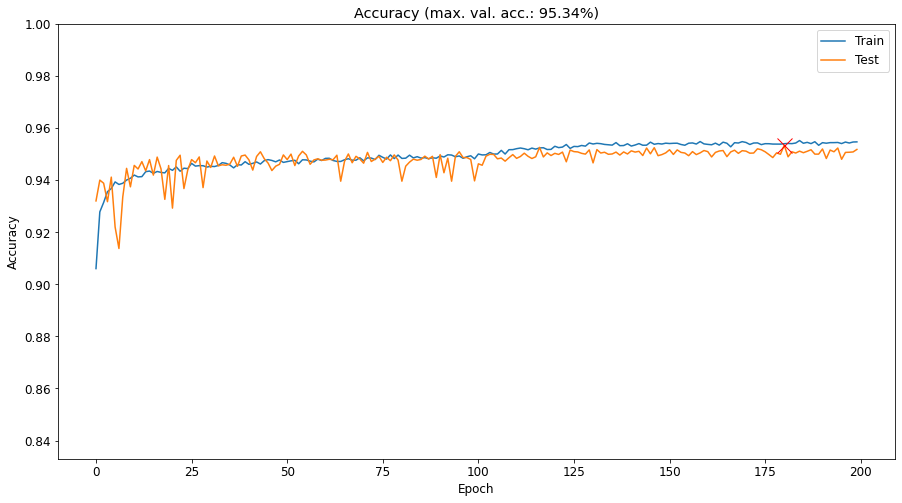

=============== STARTING TEST FOLD 6/6, ENSEMBLE FOLD 5/5 ===============
Selected fold 5/5 with 66666 train samples and 16667 validation samples


  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_loss improved from inf to 0.16891, saving model to results/ensemble_test/ensemble_test6_fold5.h5

Epoch 00002: val_loss improved from 0.16891 to 0.16605, saving model to results/ensemble_test/ensemble_test6_fold5.h5

Epoch 00003: val_loss improved from 0.16605 to 0.14548, saving model to results/ensemble_test/ensemble_test6_fold5.h5

Epoch 00004: val_loss improved from 0.14548 to 0.14416, saving model to results/ensemble_test/ensemble_test6_fold5.h5

Epoch 00005: val_loss did not improve from 0.14416

Epoch 00006: val_loss improved from 0.14416 to 0.14263, saving model to results/ensemble_test/ensemble_test6_fold5.h5

Epoch 00007: val_loss did not improve from 0.14263

Epoch 00008: val_loss did not improve from 0.14263

Epoch 00009: val_loss improved from 0.14263 to 0.14000, saving model to results/ensemble_test/ensemble_test6_fold5.h5

Epoch 00010: val_loss improved from 0.14000 to 0.13737, saving model to results/ens

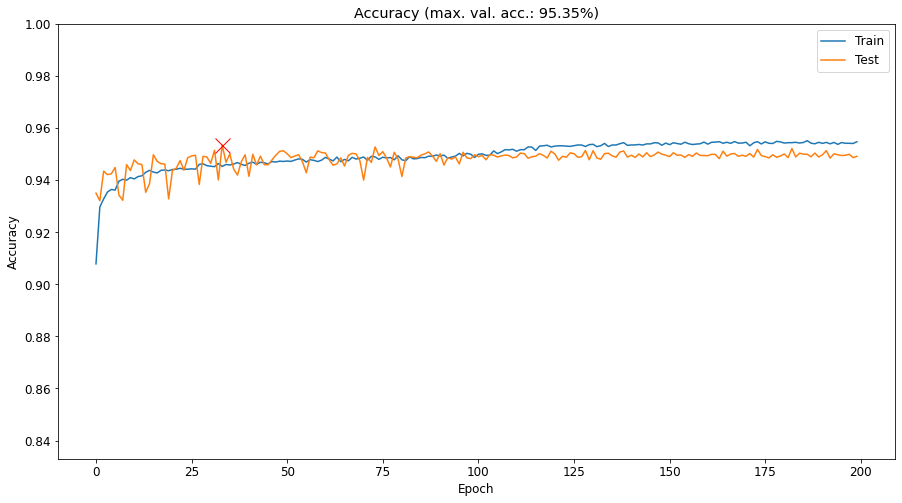

In [0]:
cv_splits = 5
for cv_test_iter in range(1, 1+cv_splits+1):
    if cv_test_iter == 1:
        continue # done

    # get general generator
    general_generator = GeneralGenerator(all_images=data_images, all_labels=data_labels,
                                         cv_splits=cv_splits, add_test_set=True, test_cv_it=cv_test_iter, batch_size=64)

    for cv_it in range(1, 1+cv_splits):
        if cv_test_iter == 2:
            if cv_it <= 3:
                continue # done
        
        print("=============== STARTING TEST FOLD {}/{}, ENSEMBLE FOLD {}/{} ===============".format(
            cv_test_iter, cv_splits+1, cv_it, cv_splits))
        # get generators
        test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=cv_it)

        # define arguments and start tracking
        args = make_args(name='Ensemble CV - test {} -  Fold {}/5'.format(cv_test_iter, cv_it), 
                         architecture='Conv', activation=LeakyReLU(0.01), final_activation='sigmoid', 
                         batch_size=64, epochs=200, verbose=False, wandb_init=True)

        # define model architecture
        model = models.Sequential()
        model.add(layers.Conv2D(16, (3, 3), activation=args.activation, input_shape=(32, 32, 15)))
        model.add(layers.Conv2D(16, (3, 3), activation=args.activation))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(rate=0.10))
        model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
        model.add(layers.Conv2D(32, (3, 3), activation=args.activation))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(rate=0.10))
        model.add(layers.Conv2D(64, (3, 3), activation=args.activation))
        model.add(layers.Flatten())
        model.add(layers.Dropout(rate=0.10))
        model.add(layers.Dense(64, activation=args.activation))
        model.add(layers.Dropout(rate=0.10))
        model.add(layers.Dense(1, activation=args.final_activation))

        model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['acc'])

        # get exponential decay learning rate scheduler
        lr_scheduler = LearningRateScheduler(
            get_exp_lr_decay_scheduler(lr_start=1e-3, lr_end=1e-6, epochs_total=200, epochs_warmup=100), verbose=0)

        # get model checkpoint callback
        checkpoint = ModelCheckpoint(MODEL_DIR+'ensemble_test{}_fold{}.h5'.format(cv_test_iter, cv_it),
                                    monitor='val_loss', 
                                    verbose=1,
                                    save_best_only=True, 
                                    mode='min', 
                                    period=1)
        

        # perform training
        history = model.fit(aug_wrapper(train_generator.flow(), flip_eta=True, skip_first_channel_flip=True), epochs=args.epochs,
                            steps_per_epoch = train_generator.n // train_generator.batch_size,
                            validation_data=val_generator.flow(),
                            validation_steps=val_generator.n // val_generator.batch_size,
                            callbacks=[checkpoint, lr_scheduler, WandbCallback()], verbose=0)

        # plot result and save final model
        plot_history(history, limits=True)
        model.save(MODEL_DIR+"final_weights_ensemble_test{}_fold{}.h5".format(cv_test_iter, cv_it))

## Performance of ensembles
Assumes availability of `data_images` and `data_labels`. Also requires the definition of `GeneralGenerator` and `DataGenerator`.  

This section uses soft voting (mean) and a threshold of 0.5. This is based on prior analysis (not shown). Further investigation is included in the next section. 

In [0]:
class EnsembleClassifier(object):
    def __init__(self, ypred_list, ytrue):
        self.names = [y[0] for y in ypred_list]
        self.ypreds = [y[1] for y in ypred_list]
        self.ytrue = ytrue

    # Soft voting: weighed mean of predictions
    def weighed_pred(self, w):
        """Soft voting with weighed averaging of predicted probabilities"""
        w = np.array(w)
        y = w @ self.ypreds / np.sum(w)
        return y
    
    def weighed_class(self, w, threshold):
        y = self.weighed_pred(w)
        return (y > threshold)
    
    # Soft voting: geometric mean of predictions
    def geom_mean_pred(self):
        """Soft voting with geometric mean of predicted probabilities"""
        y = gmean(self.ypreds)
        return y
    
    def geom_mean_class(self, threshold):
        y = self.geom_mean_pred()
        return (y > threshold)
    
    # Hard voring: most chosen classification
    def hard_vote(self, threshold_indiv):
        # threshold_indiv is the threshold for the individual predictions
        classifications = [y > threshold_indiv for y in self.ypreds]
        # classifications now contains a list of True/False entries for each sample, for each model
        votes = np.mean(classifications, axis=0)
        # most models voted for a signal if votes > 0.5 (only works for binary classification)
        return (votes > 0.5)
    
    # Metric: accuracy, for weighed_class
    def calc_acc(self, w, threshold):
        y = self.weighed_class(w, threshold)
        acc = np.mean(y == self.ytrue)
        return acc
    
    # Metric: loss, for weighed_class
    def calc_loss(self, w):
        y = self.weighed_pred(w)
        # calculate binary crossentropy loss
        return log_loss(self.ytrue, y)

Test fold 1/6:   0%|          | 0/5 [00:00<?, ?it/s]

Performing 5-fold cross-validation with 16667 test samples
Selected fold 1/5 with 66666 train samples and 16667 validation samples


Test fold 1/6:  20%|██        | 1/5 [00:07<00:28,  7.20s/it]

Selected fold 2/5 with 66666 train samples and 16667 validation samples


Test fold 1/6:  40%|████      | 2/5 [00:11<00:19,  6.35s/it]

Selected fold 3/5 with 66666 train samples and 16667 validation samples


Test fold 1/6:  60%|██████    | 3/5 [00:17<00:12,  6.11s/it]

Selected fold 4/5 with 66666 train samples and 16667 validation samples


Test fold 1/6:  80%|████████  | 4/5 [00:21<00:05,  5.72s/it]

Selected fold 5/5 with 66666 train samples and 16667 validation samples


Test fold 1/6: 100%|██████████| 5/5 [00:26<00:00,  5.31s/it]


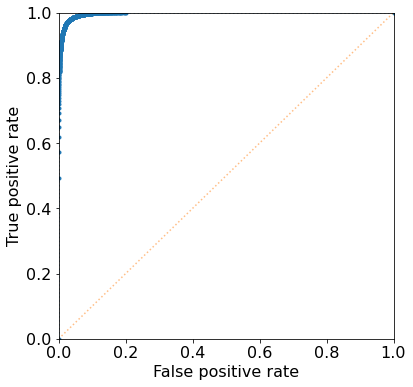

Test fold 2/6:   0%|          | 0/5 [00:00<?, ?it/s]

AUC: 0.99686
Performing 5-fold cross-validation with 16667 test samples
Selected fold 1/5 with 66666 train samples and 16667 validation samples


Test fold 2/6:  20%|██        | 1/5 [00:05<00:22,  5.62s/it]

Selected fold 2/5 with 66666 train samples and 16667 validation samples


Test fold 2/6:  40%|████      | 2/5 [00:10<00:16,  5.52s/it]

Selected fold 3/5 with 66666 train samples and 16667 validation samples


Test fold 2/6:  60%|██████    | 3/5 [00:18<00:12,  6.26s/it]

Selected fold 4/5 with 66666 train samples and 16667 validation samples


Test fold 2/6:  80%|████████  | 4/5 [00:23<00:05,  5.75s/it]

Selected fold 5/5 with 66666 train samples and 16667 validation samples


Test fold 2/6: 100%|██████████| 5/5 [00:28<00:00,  5.69s/it]


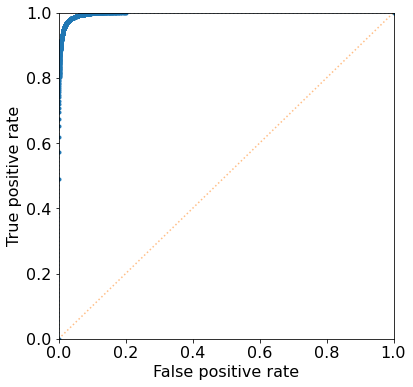

Test fold 3/6:   0%|          | 0/5 [00:00<?, ?it/s]

AUC: 0.99691
Performing 5-fold cross-validation with 16667 test samples
Selected fold 1/5 with 66666 train samples and 16667 validation samples


Test fold 3/6:  20%|██        | 1/5 [00:04<00:19,  4.80s/it]

Selected fold 2/5 with 66666 train samples and 16667 validation samples


Test fold 3/6:  40%|████      | 2/5 [00:09<00:14,  4.90s/it]

Selected fold 3/5 with 66666 train samples and 16667 validation samples


Test fold 3/6:  60%|██████    | 3/5 [00:14<00:09,  4.80s/it]

Selected fold 4/5 with 66666 train samples and 16667 validation samples


Test fold 3/6:  80%|████████  | 4/5 [00:19<00:04,  4.88s/it]

Selected fold 5/5 with 66666 train samples and 16667 validation samples


Test fold 3/6: 100%|██████████| 5/5 [00:24<00:00,  4.93s/it]


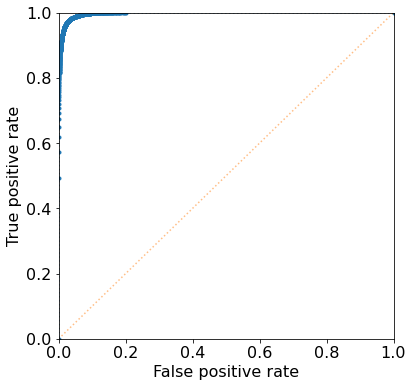

Test fold 4/6:   0%|          | 0/5 [00:00<?, ?it/s]

AUC: 0.99688
Performing 5-fold cross-validation with 16667 test samples
Selected fold 1/5 with 66666 train samples and 16667 validation samples


Test fold 4/6:  20%|██        | 1/5 [00:09<00:39,  9.83s/it]

Selected fold 2/5 with 66666 train samples and 16667 validation samples


Test fold 4/6:  40%|████      | 2/5 [00:23<00:32, 10.84s/it]

Selected fold 3/5 with 66666 train samples and 16667 validation samples


Test fold 4/6:  60%|██████    | 3/5 [00:30<00:19,  9.76s/it]

Selected fold 4/5 with 66666 train samples and 16667 validation samples


Test fold 4/6:  80%|████████  | 4/5 [00:34<00:08,  8.23s/it]

Selected fold 5/5 with 66666 train samples and 16667 validation samples


Test fold 4/6: 100%|██████████| 5/5 [00:40<00:00,  8.08s/it]


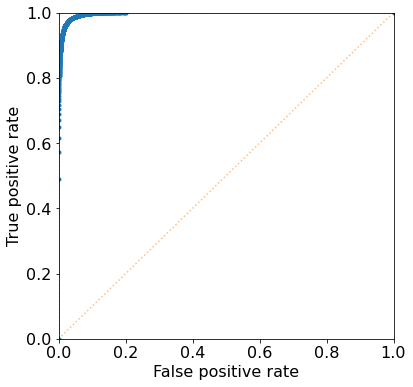

Test fold 5/6:   0%|          | 0/5 [00:00<?, ?it/s]

AUC: 0.99687
Performing 5-fold cross-validation with 16667 test samples
Selected fold 1/5 with 66666 train samples and 16667 validation samples


Test fold 5/6:  20%|██        | 1/5 [00:06<00:24,  6.09s/it]

Selected fold 2/5 with 66666 train samples and 16667 validation samples


Test fold 5/6:  40%|████      | 2/5 [00:11<00:17,  5.77s/it]

Selected fold 3/5 with 66666 train samples and 16667 validation samples


Test fold 5/6:  60%|██████    | 3/5 [00:16<00:11,  5.80s/it]

Selected fold 4/5 with 66666 train samples and 16667 validation samples


Test fold 5/6:  80%|████████  | 4/5 [00:21<00:05,  5.54s/it]

Selected fold 5/5 with 66666 train samples and 16667 validation samples


Test fold 5/6: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]


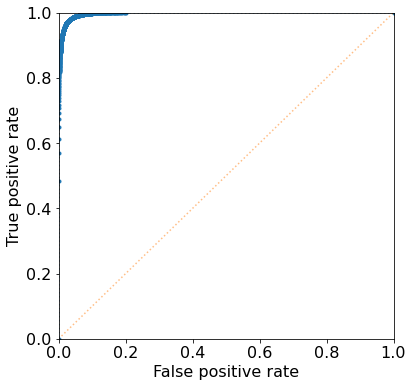

Test fold 6/6:   0%|          | 0/5 [00:00<?, ?it/s]

AUC: 0.99692
Performing 5-fold cross-validation with 16667 test samples
Selected fold 1/5 with 66666 train samples and 16667 validation samples


Test fold 6/6:  20%|██        | 1/5 [00:05<00:20,  5.16s/it]

Selected fold 2/5 with 66666 train samples and 16667 validation samples


Test fold 6/6:  40%|████      | 2/5 [00:11<00:16,  5.39s/it]

Selected fold 3/5 with 66666 train samples and 16667 validation samples


Test fold 6/6:  60%|██████    | 3/5 [00:16<00:10,  5.31s/it]

Selected fold 4/5 with 66666 train samples and 16667 validation samples


Test fold 6/6:  80%|████████  | 4/5 [00:21<00:05,  5.36s/it]

Selected fold 5/5 with 66666 train samples and 16667 validation samples


Test fold 6/6: 100%|██████████| 5/5 [00:26<00:00,  5.34s/it]


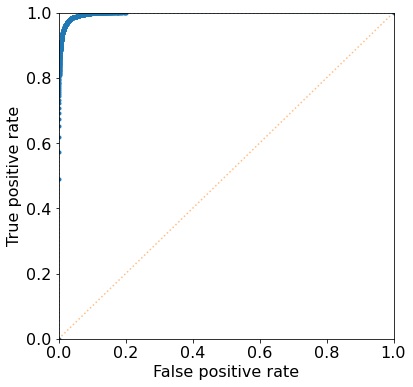

AUC: 0.99688


In [0]:
# gather test accuracies
test_accs = []
indiv_accs = []
test_accs_max_val_models = []
test_accs_final_ep_models = []

# loop over test folds
cv_splits = 5
for cv_test_iter in range(1, 1+cv_splits+1):

    # get general generator
    general_generator = GeneralGenerator(all_images=data_images, all_labels=data_labels,
                                         cv_splits=cv_splits, add_test_set=True, 
                                         test_cv_it=cv_test_iter, batch_size=64)

    # gather model predictions
    model_ypreds = []
    for cv_it in tqdm(range(1, 1+cv_splits), desc="Test fold {}/{}".format(cv_test_iter, 1+cv_splits), total=cv_splits):
        # load model
        model_max_val = load_model(MODEL_DIR+'ensemble_test{}_fold{}.h5'.format(cv_test_iter, cv_it),
                                   custom_objects={'LeakyReLU': LeakyReLU(0.01)})
        model_final_ep = load_model(MODEL_DIR+'final_weights_ensemble_test{}_fold{}.h5'.format(cv_test_iter, cv_it),
                                   custom_objects={'LeakyReLU': LeakyReLU(0.01)})

        # get generators
        test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=cv_it)

        # predict samples
        ypred = model_max_val.predict(test_generator, verbose=0)
        model_ypreds.append(("Test {}-fold {}-max val".format(cv_test_iter, cv_it), ypred.squeeze().copy()))

        ypred = model_final_ep.predict(test_generator, verbose=0)
        model_ypreds.append(("Test {}-fold {}-final ep".format(cv_test_iter, cv_it), ypred.squeeze().copy()))
    
    # Combine predictions into ensemble
    ytrue = test_generator.all_labels[test_generator.list_IDs]
    ensemble_classifier = EnsembleClassifier(model_ypreds, ytrue)
    # Calculate test accuracy of enemble
    w = np.ones(len(ensemble_classifier.ypreds))
    acc = ensemble_classifier.calc_acc(w, threshold=0.5)
    test_accs.append(acc)

    # calculate individual accuracies
    for i in range(len(w)):
        w = np.zeros_like(w)
        w[i] = 1
        acc = ensemble_classifier.calc_acc(w, threshold=0.5)
        indiv_accs.append(acc)
    
    # create ROC curve and obtain AUC
    w = np.ones(len(ensemble_classifier.ypreds))
    ypred = 1 - ensemble_classifier.weighed_pred(w) # ROC functions has class = (pred < threshold)
    wrapper = pd.DataFrame({'target': ytrue})
    TPR, FPR, AUC = ROC(ypred, wrapper, 'target', start=0, stop=1, stepsize=0.001)
    print("AUC: {:.5f}".format(AUC))

    # calculate test accuracy of ensemble of max. val. models
    w = [1 if (i % 2 == 0) else 0 for i in range(len(ensemble_classifier.ypreds))]
    acc = ensemble_classifier.calc_acc(w, threshold=0.5)
    test_accs_max_val_models.append(acc)

    # calculate test accuracy of ensemble of final ep. models
    w = [1 if (i % 2 != 0) else 0 for i in range(len(ensemble_classifier.ypreds))]
    acc = ensemble_classifier.calc_acc(w, threshold=0.5)
    test_accs_final_ep_models.append(acc)

In [0]:
print("Performance of ensembles (with cross-validation of test fold): {:.4f} ± {:.4f}".format(np.mean(test_accs), np.std(test_accs)))
print("Performance of ensembles of max. val. models: {:.4f} ± {:.4f}".format(np.mean(test_accs_max_val_models), np.std(test_accs_max_val_models)))
print("Performance of ensembles of final ep. models: {:.4f} ± {:.4f}".format(np.mean(test_accs_final_ep_models), np.std(test_accs_final_ep_models)))

Performance of ensembles (with cross-validation of test fold): 0.9538 ± 0.0002
Performance of ensembles of max. val. models: 0.9536 ± 0.0005
Performance of ensembles of final ep. models: 0.9541 ± 0.0002


In [0]:
print("Performance of individual models on test sets: {:.4f} ± {:.4f}".format(np.mean(indiv_accs), np.std(indiv_accs)))
print("Performance of individual max. val. models on test sets: {:.4f} ± {:.4f}".format(np.mean(indiv_accs[0::2]), np.std(indiv_accs[0::2])))
print("Performance of individual final ep. models on test sets: {:.4f} ± {:.4f}".format(np.mean(indiv_accs[1::2]), np.std(indiv_accs[1::2])))

Performance of individual models on test sets: 0.9525 ± 0.0008
Performance of individual max. val. models on test sets: 0.9523 ± 0.0009
Performance of individual final ep. models on test sets: 0.9527 ± 0.0006


In [0]:
test_accs

[0.9535609287814244,
 0.9539209215815684,
 0.9536209275814483,
 0.9536809263814724,
 0.9538009239815204,
 0.9542209155816883]

In [0]:
test_accs_final_ep_models

[0.9541009179816403,
 0.9541609167816644,
 0.9537409251814963,
 0.9542809143817124,
 0.9539809203815923,
 0.9542809143817124]

In [0]:
test_accs_max_val_models

[0.9530809383812324,
 0.9533809323813524,
 0.9538009239815204,
 0.9529609407811844,
 0.9538609227815443,
 0.9542809143817124]

**Result**: The ensembles of final epoch models achieve a local 'test' score of 95.41% ± 0.02% accuracy. Compared to the performance of the individual models, this is an increase of 0.16%. Also the variability is lower. 

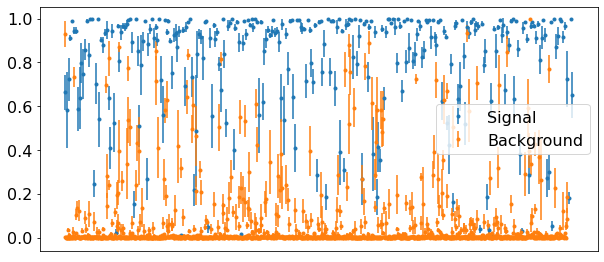

In [0]:
means, stds = np.mean(ensemble_classifier.ypreds, axis=0), np.std(ensemble_classifier.ypreds, axis=0)
mask = ensemble_classifier.ytrue

f, ax = plt.subplots(1, 1,)
filter_mask = np.array([True if i % 10 == 0 else False for i in range(len(mask))])
ax.errorbar(x=5*np.arange(len(means[mask & filter_mask])), y=means[mask & filter_mask], yerr=stds[mask & filter_mask], linestyle='', marker='.', label='Signal')
ax.errorbar(x=np.arange(len(means[~mask & filter_mask])), y=means[~mask & filter_mask], yerr=stds[~mask & filter_mask], linestyle='', marker='.', label='Background')
ax.legend(); ax.set_xticks([])
plt.show()

## Voting scheme and threshold
Analysis of voting schemes:
*   Majority voting (hard voting),
*   Mean voting (soft voting),
*   Geometric mean voting (soft voting).

Also optimize the decision threshold. 

In [0]:
cv_splits = 5

# gather test accuracies
threshold_range = np.arange(0, 1, 0.01)
mean_accs = np.zeros((cv_splits+1, len(threshold_range)))
gmean_accs = np.zeros((cv_splits+1, len(threshold_range)))
majority_accs = np.zeros((cv_splits+1, len(threshold_range)))

# also gather test recalls and precisions
mean_recalls = np.zeros((cv_splits+1, len(threshold_range)))
gmean_recalls = np.zeros((cv_splits+1, len(threshold_range)))
majority_recalls = np.zeros((cv_splits+1, len(threshold_range)))

mean_precisions = np.zeros((cv_splits+1, len(threshold_range)))
gmean_precisions = np.zeros((cv_splits+1, len(threshold_range)))
majority_precisions = np.zeros((cv_splits+1, len(threshold_range)))


# loop over test folds
for cv_test_iter in range(1, 1+cv_splits+1):

    # get general generator
    general_generator = GeneralGenerator(all_images=data_images, all_labels=data_labels,
                                         cv_splits=cv_splits, add_test_set=True, 
                                         test_cv_it=cv_test_iter, batch_size=64)

    # gather model predictions
    model_ypreds = []
    for cv_it in tqdm(range(1, 1+cv_splits), desc="Test fold {}/{}".format(cv_test_iter, 1+cv_splits), total=cv_splits):
        # load model
        model_max_val = load_model(MODEL_DIR+'ensemble_test{}_fold{}.h5'.format(cv_test_iter, cv_it),
                                   custom_objects={'LeakyReLU': LeakyReLU(0.01)})
        model_final_ep = load_model(MODEL_DIR+'final_weights_ensemble_test{}_fold{}.h5'.format(cv_test_iter, cv_it),
                                   custom_objects={'LeakyReLU': LeakyReLU(0.01)})

        # get generators
        test_generator, train_generator, val_generator = general_generator.get_generators(cv_it=cv_it)

        # predict samples
        ypred = model_max_val.predict(test_generator, verbose=0)
        model_ypreds.append(("Test {}-fold {}-max val".format(cv_test_iter, cv_it), ypred.squeeze().copy()))

        ypred = model_final_ep.predict(test_generator, verbose=0)
        model_ypreds.append(("Test {}-fold {}-final ep".format(cv_test_iter, cv_it), ypred.squeeze().copy()))
    
    # Combine predictions into ensemble
    ytrue = test_generator.all_labels[test_generator.list_IDs]
    ensemble_classifier = EnsembleClassifier(model_ypreds, ytrue)
    w = np.ones(len(ensemble_classifier.ypreds))

    ### Soft voting: mean of predictions ###
    # calculate test acccuracy for range of thresholds
    for i, threshold in enumerate(threshold_range):
        acc = ensemble_classifier.calc_acc(w, threshold)
        mean_accs[cv_test_iter-1, i] = acc

        # also calculate recall and precision
        classification = ensemble_classifier.weighed_class(w, threshold)
        recall = recall_score(ensemble_classifier.ytrue, classification)
        precision = precision_score(ensemble_classifier.ytrue, classification)
        mean_recalls[cv_test_iter-1, i] = recall
        mean_precisions[cv_test_iter-1, i] = precision
    

    ### Soft voting: geometric mean of predictions ###
    # calculate test acccuracy for range of thresholds
    for i, threshold in enumerate(threshold_range):
        geom_mean_classification = ensemble_classifier.geom_mean_class(threshold)
        acc = np.mean(geom_mean_classification == ensemble_classifier.ytrue)
        gmean_accs[cv_test_iter-1, i] = acc

        # also calculate recall and precision
        recall = recall_score(ensemble_classifier.ytrue, geom_mean_classification)
        precision = precision_score(ensemble_classifier.ytrue, geom_mean_classification)
        gmean_recalls[cv_test_iter-1, i] = recall
        gmean_precisions[cv_test_iter-1, i] = precision

    ### Hard voting: majority of predictions ###
    # calculate test acccuracy for range of thresholds
    for i, threshold in enumerate(threshold_range):
        hard_classification = ensemble_classifier.hard_vote(threshold_indiv=threshold)
        acc = np.mean(hard_classification == ensemble_classifier.ytrue)
        majority_accs[cv_test_iter-1, i] = acc

        # also calculate recall and precision
        recall = recall_score(ensemble_classifier.ytrue, hard_classification)
        precision = precision_score(ensemble_classifier.ytrue, hard_classification)
        majority_recalls[cv_test_iter-1, i] = recall
        majority_precisions[cv_test_iter-1, i] = precision

Test fold 1/6:   0%|          | 0/5 [00:00<?, ?it/s]

Performing 5-fold cross-validation with 16667 test samples
Selected fold 1/5 with 66666 train samples and 16667 validation samples


Test fold 1/6:  20%|██        | 1/5 [00:04<00:16,  4.02s/it]

Selected fold 2/5 with 66666 train samples and 16667 validation samples


Test fold 1/6:  40%|████      | 2/5 [00:08<00:12,  4.02s/it]

Selected fold 3/5 with 66666 train samples and 16667 validation samples


Test fold 1/6:  60%|██████    | 3/5 [00:12<00:08,  4.07s/it]

Selected fold 4/5 with 66666 train samples and 16667 validation samples


Test fold 1/6:  80%|████████  | 4/5 [00:16<00:04,  4.07s/it]

Selected fold 5/5 with 66666 train samples and 16667 validation samples


Test fold 2/6:   0%|          | 0/5 [00:00<?, ?it/s]

Performing 5-fold cross-validation with 16667 test samples
Selected fold 1/5 with 66666 train samples and 16667 validation samples


Test fold 2/6:  20%|██        | 1/5 [00:05<00:20,  5.01s/it]

Selected fold 2/5 with 66666 train samples and 16667 validation samples


Test fold 2/6:  40%|████      | 2/5 [00:09<00:14,  4.75s/it]

Selected fold 3/5 with 66666 train samples and 16667 validation samples


Test fold 2/6:  60%|██████    | 3/5 [00:13<00:09,  4.57s/it]

Selected fold 4/5 with 66666 train samples and 16667 validation samples


Test fold 2/6:  80%|████████  | 4/5 [00:17<00:04,  4.45s/it]

Selected fold 5/5 with 66666 train samples and 16667 validation samples


Test fold 3/6:   0%|          | 0/5 [00:00<?, ?it/s]

Performing 5-fold cross-validation with 16667 test samples
Selected fold 1/5 with 66666 train samples and 16667 validation samples


Test fold 3/6:  20%|██        | 1/5 [00:04<00:16,  4.12s/it]

Selected fold 2/5 with 66666 train samples and 16667 validation samples


Test fold 3/6:  40%|████      | 2/5 [00:08<00:12,  4.10s/it]

Selected fold 3/5 with 66666 train samples and 16667 validation samples


Test fold 3/6:  60%|██████    | 3/5 [00:12<00:08,  4.12s/it]

Selected fold 4/5 with 66666 train samples and 16667 validation samples


Test fold 3/6:  80%|████████  | 4/5 [00:16<00:04,  4.10s/it]

Selected fold 5/5 with 66666 train samples and 16667 validation samples


Test fold 4/6:   0%|          | 0/5 [00:00<?, ?it/s]

Performing 5-fold cross-validation with 16667 test samples
Selected fold 1/5 with 66666 train samples and 16667 validation samples


Test fold 4/6:  20%|██        | 1/5 [00:04<00:16,  4.23s/it]

Selected fold 2/5 with 66666 train samples and 16667 validation samples


Test fold 4/6:  40%|████      | 2/5 [00:08<00:12,  4.24s/it]

Selected fold 3/5 with 66666 train samples and 16667 validation samples


Test fold 4/6:  60%|██████    | 3/5 [00:12<00:08,  4.23s/it]

Selected fold 4/5 with 66666 train samples and 16667 validation samples


Test fold 4/6:  80%|████████  | 4/5 [00:16<00:04,  4.18s/it]

Selected fold 5/5 with 66666 train samples and 16667 validation samples


Test fold 5/6:   0%|          | 0/5 [00:00<?, ?it/s]

Performing 5-fold cross-validation with 16667 test samples
Selected fold 1/5 with 66666 train samples and 16667 validation samples


Test fold 5/6:  20%|██        | 1/5 [00:04<00:16,  4.16s/it]

Selected fold 2/5 with 66666 train samples and 16667 validation samples


Test fold 5/6:  40%|████      | 2/5 [00:08<00:12,  4.16s/it]

Selected fold 3/5 with 66666 train samples and 16667 validation samples


Test fold 5/6:  60%|██████    | 3/5 [00:12<00:08,  4.19s/it]

Selected fold 4/5 with 66666 train samples and 16667 validation samples


Test fold 5/6:  80%|████████  | 4/5 [00:16<00:04,  4.20s/it]

Selected fold 5/5 with 66666 train samples and 16667 validation samples


Test fold 6/6:   0%|          | 0/5 [00:00<?, ?it/s]

Performing 5-fold cross-validation with 16667 test samples
Selected fold 1/5 with 66666 train samples and 16667 validation samples


Test fold 6/6:  20%|██        | 1/5 [00:04<00:17,  4.28s/it]

Selected fold 2/5 with 66666 train samples and 16667 validation samples


Test fold 6/6:  40%|████      | 2/5 [00:08<00:12,  4.27s/it]

Selected fold 3/5 with 66666 train samples and 16667 validation samples


Test fold 6/6:  60%|██████    | 3/5 [00:12<00:08,  4.26s/it]

Selected fold 4/5 with 66666 train samples and 16667 validation samples


Test fold 6/6:  80%|████████  | 4/5 [00:17<00:04,  4.25s/it]

Selected fold 5/5 with 66666 train samples and 16667 validation samples


Test fold 6/6: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


### Results: soft voting (mean)

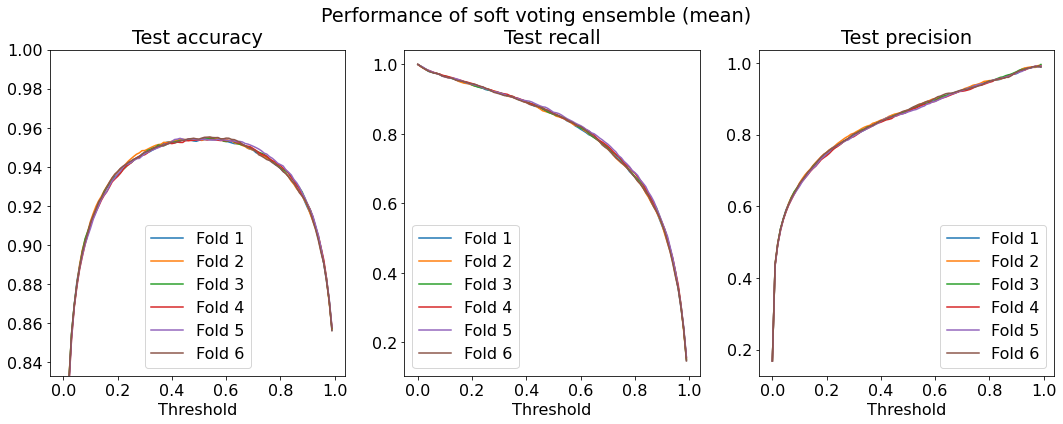

In [0]:
f, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (accs, recalls, precisions) in enumerate(zip(mean_accs, mean_recalls, mean_precisions)):
    ax = axes[0]; ax.plot(threshold_range, accs, label='Fold {}'.format(i+1))
    ax = axes[1]; ax.plot(threshold_range, recalls, label='Fold {}'.format(i+1))
    ax = axes[2]; ax.plot(threshold_range, precisions, label='Fold {}'.format(i+1))

for ax in axes:
    ax.legend()
    ax.set_xlabel("Threshold")

# Metric specific formatting
ax = axes[0]
ax.set_title("Test accuracy")
ax.set_ylim(0.833, 1)
ax = axes[1]
ax.set_title("Test recall")
ax = axes[2]
ax.set_title("Test precision")

plt.suptitle("Performance of soft voting ensemble (mean)")
plt.show()

In [0]:
best_accs = np.max(mean_accs, axis=1)
best_thresholds = threshold_range[np.argmax(mean_accs, axis=1)]

print("Best test accuracy of equally weighed ensemble: {:.2%} ± {:.2%}".format(np.mean(best_accs), np.std(best_accs)))
print("At threshold of: {}".format(best_thresholds))

Best test accuracy of equally weighed ensemble: 95.47% ± 0.04%
At threshold of: [0.57 0.54 0.55 0.52 0.43 0.54]


### Results: soft voting (geometric mean)

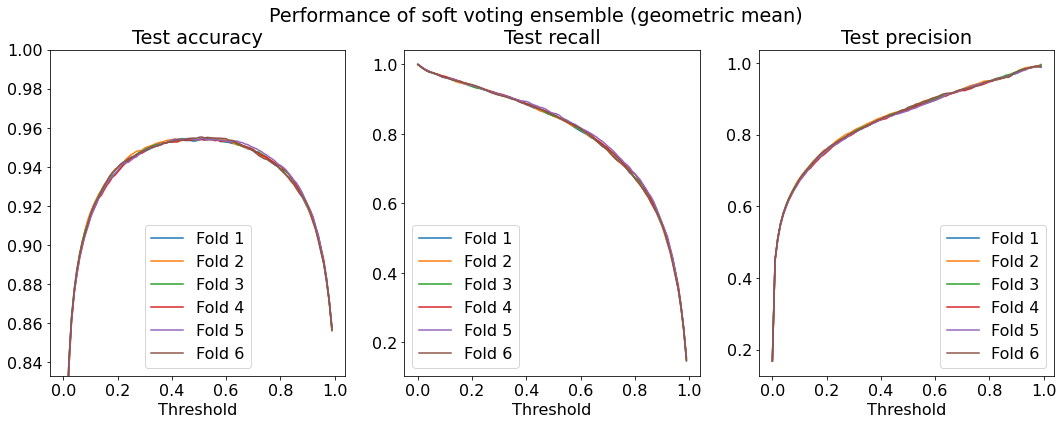

In [0]:
f, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (accs, recalls, precisions) in enumerate(zip(gmean_accs, gmean_recalls, gmean_precisions)):
    ax = axes[0]; ax.plot(threshold_range, accs, label='Fold {}'.format(i+1))
    ax = axes[1]; ax.plot(threshold_range, recalls, label='Fold {}'.format(i+1))
    ax = axes[2]; ax.plot(threshold_range, precisions, label='Fold {}'.format(i+1))

for ax in axes:
    ax.legend()
    ax.set_xlabel("Threshold")

# Metric specific formatting
ax = axes[0]
ax.set_title("Test accuracy")
ax.set_ylim(0.833, 1)
ax = axes[1]
ax.set_title("Test recall")
ax = axes[2]
ax.set_title("Test precision")

plt.suptitle("Performance of soft voting ensemble (geometric mean)")
plt.show()

In [0]:
best_accs = np.max(gmean_accs, axis=1)
best_thresholds = threshold_range[np.argmax(gmean_accs, axis=1)]

print("Best test accuracy of equally weighed ensemble: {:.2%} ± {:.2%}".format(np.mean(best_accs), np.std(best_accs)))
print("At threshold of: {}".format(best_thresholds))

Best test accuracy of equally weighed ensemble: 95.47% ± 0.03%
At threshold of: [0.55 0.53 0.51 0.53 0.51 0.51]


### Results: majority voting

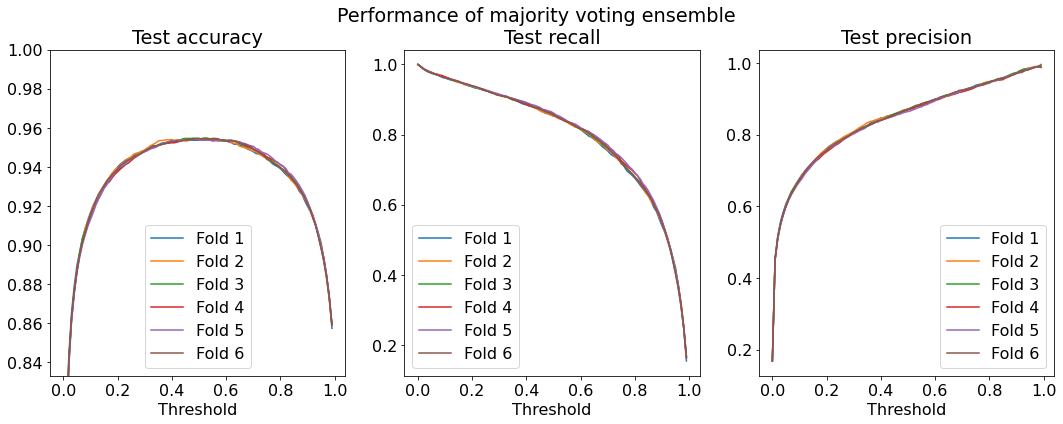

In [0]:
f, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (accs, recalls, precisions) in enumerate(zip(majority_accs, majority_recalls, majority_precisions)):
    ax = axes[0]; ax.plot(threshold_range, accs, label='Fold {}'.format(i+1))
    ax = axes[1]; ax.plot(threshold_range, recalls, label='Fold {}'.format(i+1))
    ax = axes[2]; ax.plot(threshold_range, precisions, label='Fold {}'.format(i+1))

for ax in axes:
    ax.legend()
    ax.set_xlabel("Threshold")

# Metric specific formatting
ax = axes[0]
ax.set_title("Test accuracy")
ax.set_ylim(0.833, 1)
ax = axes[1]
ax.set_title("Test recall")
ax = axes[2]
ax.set_title("Test precision")

plt.suptitle("Performance of majority voting ensemble")
plt.show()

In [0]:
best_accs = np.max(majority_accs, axis=1)
best_thresholds = threshold_range[np.argmax(majority_accs, axis=1)]

print("Best test accuracy of equally weighed ensemble: {:.2%} ± {:.2%}".format(np.mean(best_accs), np.std(best_accs)))
print("At individual threshold of: {}".format(best_thresholds))

Best test accuracy of equally weighed ensemble: 95.45% ± 0.02%
At individual threshold of: [0.53 0.53 0.52 0.5  0.49 0.55]


**Result**: the different voting schemes did not differ much in performance, but soft mean voting performed a bit better with a threshold of 0.5, and soft geometric mean voting performed a bit better with adaptable threshold. My expectation is that the geometric mean with threshold of 0.47 is not necesairily better in general. Because of this, I will apply soft voting with a mean of 0.5 for the 'real' test set. 

# Part 9: Final results

In [0]:
test_accs_final_ep_models

[0.9541009179816403,
 0.9541609167816644,
 0.9537409251814963,
 0.9542809143817124,
 0.9539809203815923,
 0.9542809143817124]

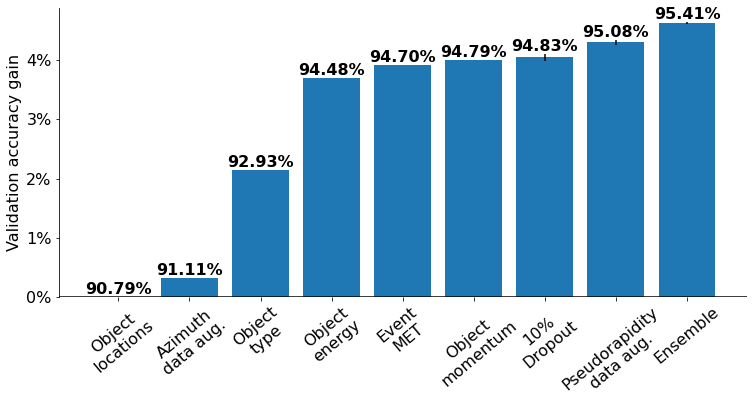

In [0]:
accuracies = [ # max. val. accuracies of:
              [0.9079], # location of objects
              [0.9111], # azimuth data augmentation
              [0.9293], # add object type
              [0.9448], # add object energy
              [0.9470], # add event energy
              [0.9479], # add object momentum
              [0.9477, 0.9481, 0.9488, 0.9491, 0.9479], # add 10% dropout
              [0.9510, 0.9514, 0.9503, 0.9507, 0.9508], # pseudorapidity data augmentation
              # ensemble 'test' scores:
              test_accs_final_ep_models,
]
labels = [
          'Object\nlocations',
          'Azimuth\ndata aug.',
          'Object\ntype',
          'Object\nenergy',
          'Event\nMET',
          'Object\nmomentum',
          '10%\nDropout',
          'Pseudorapidity\ndata aug.',
          'Ensemble'
]
plot_accuracy_gain(accuracies, labels, baseline=0, fn='CNN_acc_gain', figsize=(10.75, 6), label_rotation=40)

**Result**: providing additional information to the Convolutional Neural Network incrementally improved performance, indicating that the model was able to successfully extract useful information rather than overfitting (severely). Implementing data augmentation results is both better validation performance and better generalization. Combining multiple models into an ensemble also boosts performance. 